In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Mounted at /content/drive/


In [ ]:
# reading data 

In [4]:
data1 = pd.read_csv('../../data/stock_week_cluster.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [6]:
data1.head()

,StockCode,Quantity,Price,holiday,ds,year,timeelapsed,cumsum,cumdist,averagedistance,cluster
0,20677,96.000000,1.583599,-1.0,2010-05-31,2010,1.0,96.000000,0.0,0.013333,9
1,20677,10.500000,1.583599,-1.0,2010-06-07,2010,1.0,106.500000,0.0,0.013333,9
2,20677,32.000000,1.583599,-1.0,2010-06-14,2010,1.0,138.500000,0.0,0.013333,9
3,20677,30.833333,1.583599,-1.0,2010-06-21,2010,1.0,169.333333,0.0,0.013333,9
4,20677,123.666667,1.583599,-1.0,2010-06-28,2010,1.0,293.000000,0.0,0.013333,9


In [7]:
data1['ds'] = pd.to_datetime(data1['ds'])

In [8]:
# data1.drop(['week_start'],axis=1,inplace=True)

# Date related feature

In [9]:
def weekinmonth(x):
  x = pd.to_datetime(x)
  fdom = x.day // 7
  return fdom
data1['wom'] = data1['ds'].apply(weekinmonth)
data1['year'] = data1['ds'].dt.year
data1['week_no'] = data1['ds'].dt.week
data1['month'] = data1['ds'].dt.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [10]:
data1 = data1.loc[data1['year'] >= 2010,]

In [11]:
data1.shape

(305914, 14)

In [12]:
dtgc = data1.copy()

In [13]:
dtgc.head()

,StockCode,Quantity,Price,holiday,ds,year,timeelapsed,cumsum,cumdist,averagedistance,cluster,wom,week_no,month
0,20677,96.000000,1.583599,-1.0,2010-05-31,2010,1.0,96.000000,0.0,0.013333,9,4,22,22
1,20677,10.500000,1.583599,-1.0,2010-06-07,2010,1.0,106.500000,0.0,0.013333,9,1,23,23
2,20677,32.000000,1.583599,-1.0,2010-06-14,2010,1.0,138.500000,0.0,0.013333,9,2,24,24
3,20677,30.833333,1.583599,-1.0,2010-06-21,2010,1.0,169.333333,0.0,0.013333,9,3,25,25
4,20677,123.666667,1.583599,-1.0,2010-06-28,2010,1.0,293.000000,0.0,0.013333,9,4,26,26


In [14]:
dtgc.shape

(305914, 14)

In [15]:
dtgc.head()

,StockCode,Quantity,Price,holiday,ds,year,timeelapsed,cumsum,cumdist,averagedistance,cluster,wom,week_no,month
0,20677,96.000000,1.583599,-1.0,2010-05-31,2010,1.0,96.000000,0.0,0.013333,9,4,22,22
1,20677,10.500000,1.583599,-1.0,2010-06-07,2010,1.0,106.500000,0.0,0.013333,9,1,23,23
2,20677,32.000000,1.583599,-1.0,2010-06-14,2010,1.0,138.500000,0.0,0.013333,9,2,24,24
3,20677,30.833333,1.583599,-1.0,2010-06-21,2010,1.0,169.333333,0.0,0.013333,9,3,25,25
4,20677,123.666667,1.583599,-1.0,2010-06-28,2010,1.0,293.000000,0.0,0.013333,9,4,26,26


# data Standardization

In [16]:
mu = data1.groupby(['StockCode'])['Quantity'].mean().reset_index()
mu = mu.rename(columns={'Quantity':'mean'})
std = dtgc.groupby(['StockCode'])['Quantity'].std().reset_index()
std = std.rename(columns={'Quantity':'std'})
data1 = dtgc.merge(mu,on=['StockCode'],how='left')
data1 = data1.merge(std,on=['StockCode'],how='left')
data1['tQuantity'] = (data1['Quantity'] - data1['mean'])/(data1['std'])
data = data1.copy()
data['lag1'] = data.groupby('StockCode')['tQuantity'].shift(1)
data['lag4'] = data.groupby('StockCode')['tQuantity'].shift(4)
data['lag52'] = data.groupby('StockCode')['tQuantity'].shift(52)


In [17]:
data.isnull().sum()

StockCode               0
Quantity                0
Price                   0
holiday               612
ds                      0
year                    0
timeelapsed             0
cumsum                  0
cumdist                 0
averagedistance         0
cluster                 0
wom                     0
week_no                 0
month                   0
mean                    0
std                     0
tQuantity              96
lag1                 3553
lag4                13924
lag52              175238
dtype: int64

In [18]:
# train val test split

In [19]:
# data.drop(['cumsum'],axis=1,inplace=True)

In [20]:
data.fillna(-1,inplace = True)

In [21]:
max_date = pd.to_datetime(data['ds']).max()
mx1_dt = (max_date - pd.to_timedelta(7, unit='w'))

In [22]:
data['ds'] = pd.to_datetime(data['ds'])
train = data.loc[data['ds'] <= mx1_dt,]

In [23]:
val = data.loc[data['ds'] > mx1_dt,]
val_f = val[[x for x in val.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
val_f.index = val['ds']
val_f = val_f.drop(['ds'],axis=1)

In [24]:
train_f = train[[x for x in train.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
train_f.index = train.ds
train_f = train_f.drop(['ds'],axis=1)

In [25]:
mx_dt = (train['ds'].max() - pd.to_timedelta(6, unit='w'))

In [26]:
train1 = train.loc[train['ds'] <= mx_dt,]
train1.index = train1['ds']
train1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
val1 = train.loc[train['ds'] >  mx_dt,]

In [28]:
val1.index = val1['ds']
val1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
test = data.loc[data['ds'] > val1.index.max(),]
test.index = test['ds']
test.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
train_x = train1[[x for x in train1.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
train_y = train1['tQuantity']

# Required package installation

In [31]:
! pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


# ordinal encoding

In [32]:
import category_encoders as ce
id_encoder =  ce.OrdinalEncoder()
id_encoder.fit(train_x['StockCode'])
train_x['id_cat'] = id_encoder.transform(train_x['StockCode'])
train_x1 = train_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
val_x = val1[[x for x in val1.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
val_y = val1['tQuantity']

In [34]:
val_x['id_cat'] = id_encoder.transform(val_x['StockCode'])
val_x1 = val_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
test_x = test[[x for x in test.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
test_x['id_cat'] = id_encoder.transform(test_x['StockCode'])
test_x1 = test_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
train_f['id_cat'] = id_encoder.transform(train_f['StockCode'])
train_f = train_f.drop(['StockCode'],axis=1)

In [37]:
train_fy = train['tQuantity']

In [38]:
val_f['id_cat'] = id_encoder.transform(val_f['StockCode'])
val_f.drop(['StockCode'],axis=1,inplace=True)
val_fy = val['tQuantity']

# optuna installtion

In [39]:
! pip install optuna

     |████████████████████████████████| 296kB 4.2MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 1.2MB 9.6MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 112kB 29.4MB/s 
     |████████████████████████████████| 143kB 22.5MB/s 
     |████████████████████████████████| 481kB 19.6MB/s 
  Created wheel for alembic: filename=alembic-1.5.5-py2.py3-none-any.whl size=156597 sha256=0738f6df3e36122ec79a4eb48c20e31d49a940fb7c397ec8a5b2e815fb00c3a7
  Stored in directory: /root/.cache/pip/wheels/74/3f/61/7de6e3cef766d2680a5d81b1a388286e640f6a681eb589d643
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=1ec23e7b276db110eafb96f88fc33841f28ef33055d92eb72f2683cd1366dd5d
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp36-none-any.whl size=11108 sha256=e

# light gbm implementaion

In [40]:
import optuna
import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import LightGBMTuner

In [41]:
params = {
    'objective': 'regression',
    'boosting_type':'gbdt',
    "eval_metric":'mse',
    'metric':'mape'
}

In [42]:
train_x1.columns.tolist()

['Price',
 'holiday',
 'year',
 'cumdist',
 'averagedistance',
 'cluster',
 'wom',
 'week_no',
 'month',
 'std',
 'lag1',
 'lag4',
 'lag52',
 'id_cat']

In [43]:
categorical_feature = ['week_no','month','wom','id_cat','cluster']

In [44]:
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [45]:
tuned_model = LightGBMTuner(params, train_set=lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=300,
                                     early_stopping_rounds=30,
                                    )

[I 2021-02-22 15:53:42,292] A new study created in memory with name: no-name-c8b8ce44-d9b5-4303-b79d-6ba3b1fbf187


In [46]:
tuned_model.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['cluster', 'id_cat', 'month', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's mape: 0.427987
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42879
[3]	valid_0's mape: 0.412216
[4]	valid_0's mape: 0.397295
[5]	valid_0's mape: 0.384246
[6]	valid_0's mape: 0.38501
[7]	valid_0's mape: 0.374704
[8]	valid_0's mape: 0.36527
[9]	valid_0's mape: 0.363237
[10]	valid_0's mape: 0.3545
[11]	valid_0's mape: 0.347473
[12]	valid_0's mape: 0.340773
[13]	valid_0's mape: 0.339512
[14]	valid_0's mape: 0.333545
[15]	valid_0's mape: 0.329882
[16]	valid_0's mape: 0.32456
[17]	valid_0's mape: 0.322533
[18]	valid_0's mape: 0.32087
[19]	valid_0's mape: 0.318505
[20]	valid_0's mape: 0.315625
[21]	valid_0's mape: 0.313442
[22]	valid_0's mape: 0.312758
[23]	valid_0's mape: 0.311158
[24]	valid_0's mape: 0.309913
[25]	valid_0's mape: 0.309269
[26]	valid_0's mape: 0.308478
[27]	valid_0's mape: 0.307895
[28]	valid_0's mape: 0.307232
[29]	valid_0's mape: 0.306272
[30]	valid_0's mape: 0.306506
[31]	valid_0's mape: 0.304422
[32]	valid_0's mape: 0.3

feature_fraction, val_score: 0.293690:  14%|#4        | 1/7 [00:04<00:29,  4.88s/it][I 2021-02-22 15:53:47,193] Trial 0 finished with value: 0.29369019667784024 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.29369019667784024.



[236]	valid_0's mape: 0.294018
[237]	valid_0's mape: 0.294039
[238]	valid_0's mape: 0.294053
[239]	valid_0's mape: 0.293978
[240]	valid_0's mape: 0.293969
[241]	valid_0's mape: 0.294005
[242]	valid_0's mape: 0.294022
[243]	valid_0's mape: 0.29402
[244]	valid_0's mape: 0.293957
[245]	valid_0's mape: 0.294089
[246]	valid_0's mape: 0.294104
Early stopping, best iteration is:
[216]	valid_0's mape: 0.29369


feature_fraction, val_score: 0.293690:  14%|#4        | 1/7 [00:04<00:29,  4.88s/it]

[1]	valid_0's mape: 0.42631
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428537
[3]	valid_0's mape: 0.410783
[4]	valid_0's mape: 0.412869
[5]	valid_0's mape: 0.414222
[6]	valid_0's mape: 0.411754
[7]	valid_0's mape: 0.413371
[8]	valid_0's mape: 0.399649
[9]	valid_0's mape: 0.396117
[10]	valid_0's mape: 0.393606
[11]	valid_0's mape: 0.393029
[12]	valid_0's mape: 0.390672
[13]	valid_0's mape: 0.387436
[14]	valid_0's mape: 0.377334
[15]	valid_0's mape: 0.368719
[16]	valid_0's mape: 0.360675
[17]	valid_0's mape: 0.353874
[18]	valid_0's mape: 0.349324
[19]	valid_0's mape: 0.34324
[20]	valid_0's mape: 0.338255
[21]	valid_0's mape: 0.338732
[22]	valid_0's mape: 0.334272
[23]	valid_0's mape: 0.32876
[24]	valid_0's mape: 0.325529
[25]	valid_0's mape: 0.32217
[26]	valid_0's mape: 0.318185
[27]	valid_0's mape: 0.316682
[28]	valid_0's mape: 0.315244
[29]	valid_0's mape: 0.312751
[30]	valid_0's mape: 0.311456
[31]	valid_0's mape: 0.30967
[32]	valid_0's mape: 0

feature_fraction, val_score: 0.292896:  29%|##8       | 2/7 [00:08<00:22,  4.44s/it]

[1]	valid_0's mape: 0.426603
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.409714
[3]	valid_0's mape: 0.395356
[4]	valid_0's mape: 0.382659
[5]	valid_0's mape: 0.371513
[6]	valid_0's mape: 0.360051
[7]	valid_0's mape: 0.352335
[8]	valid_0's mape: 0.345854
[9]	valid_0's mape: 0.340116
[10]	valid_0's mape: 0.335983
[11]	valid_0's mape: 0.330641
[12]	valid_0's mape: 0.326606
[13]	valid_0's mape: 0.322676
[14]	valid_0's mape: 0.318733
[15]	valid_0's mape: 0.316579
[16]	valid_0's mape: 0.315065
[17]	valid_0's mape: 0.310742
[18]	valid_0's mape: 0.30891
[19]	valid_0's mape: 0.308692
[20]	valid_0's mape: 0.307726
[21]	valid_0's mape: 0.306708
[22]	valid_0's mape: 0.306396
[23]	valid_0's mape: 0.305884
[24]	valid_0's mape: 0.304102
[25]	valid_0's mape: 0.303797
[26]	valid_0's mape: 0.303182
[27]	valid_0's mape: 0.302884
[28]	valid_0's mape: 0.302713
[29]	valid_0's mape: 0.302608
[30]	valid_0's mape: 0.302388
[31]	valid_0's mape: 0.30197
[32]	valid_0's mape

feature_fraction, val_score: 0.292896:  43%|####2     | 3/7 [00:12<00:17,  4.26s/it]


[131]	valid_0's mape: 0.295529
[132]	valid_0's mape: 0.295493
[133]	valid_0's mape: 0.295545
[134]	valid_0's mape: 0.29581
[135]	valid_0's mape: 0.29591
[136]	valid_0's mape: 0.295936
[137]	valid_0's mape: 0.296183
Early stopping, best iteration is:
[107]	valid_0's mape: 0.295254
[1]	valid_0's mape: 0.427426
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.41099
[3]	valid_0's mape: 0.412633
[4]	valid_0's mape: 0.413666
[5]	valid_0's mape: 0.416012
[6]	valid_0's mape: 0.417049
[7]	valid_0's mape: 0.403783
[8]	valid_0's mape: 0.402555
[9]	valid_0's mape: 0.400218
[10]	valid_0's mape: 0.395361
[11]	valid_0's mape: 0.386002
[12]	valid_0's mape: 0.381386
[13]	valid_0's mape: 0.370351
[14]	valid_0's mape: 0.366935
[15]	valid_0's mape: 0.365383
[16]	valid_0's mape: 0.35633
[17]	valid_0's mape: 0.356723
[18]	valid_0's mape: 0.349336
[19]	valid_0's mape: 0.349118
[20]	valid_0's mape: 0.348504
[21]	valid_0's mape: 0.348059
[22]	valid_0's mape: 0.346084
[23]	va

feature_fraction, val_score: 0.292896:  57%|#####7    | 4/7 [00:15<00:12,  4.00s/it][I 2021-02-22 15:53:57,830] Trial 3 finished with value: 0.29405217129356104 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.29289616297684457.


[157]	valid_0's mape: 0.294731
[158]	valid_0's mape: 0.294646
[159]	valid_0's mape: 0.294652
[160]	valid_0's mape: 0.294524
[161]	valid_0's mape: 0.294379
[162]	valid_0's mape: 0.29447
[163]	valid_0's mape: 0.294521
[164]	valid_0's mape: 0.294639
[165]	valid_0's mape: 0.294545
[166]	valid_0's mape: 0.294395
[167]	valid_0's mape: 0.294226
[168]	valid_0's mape: 0.294261
[169]	valid_0's mape: 0.2943
Early stopping, best iteration is:
[139]	valid_0's mape: 0.294052


feature_fraction, val_score: 0.292896:  57%|#####7    | 4/7 [00:15<00:12,  4.00s/it]

[1]	valid_0's mape: 0.427987
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428778
[3]	valid_0's mape: 0.413336
[4]	valid_0's mape: 0.414941
[5]	valid_0's mape: 0.400641
[6]	valid_0's mape: 0.398251
[7]	valid_0's mape: 0.400312
[8]	valid_0's mape: 0.386891
[9]	valid_0's mape: 0.382973
[10]	valid_0's mape: 0.380982
[11]	valid_0's mape: 0.38057
[12]	valid_0's mape: 0.377142
[13]	valid_0's mape: 0.375132
[14]	valid_0's mape: 0.365499
[15]	valid_0's mape: 0.358138
[16]	valid_0's mape: 0.351077
[17]	valid_0's mape: 0.345997
[18]	valid_0's mape: 0.340148
[19]	valid_0's mape: 0.334493
[20]	valid_0's mape: 0.330913
[21]	valid_0's mape: 0.329719
[22]	valid_0's mape: 0.327134
[23]	valid_0's mape: 0.322859
[24]	valid_0's mape: 0.320951
[25]	valid_0's mape: 0.317695
[26]	valid_0's mape: 0.313853
[27]	valid_0's mape: 0.313049
[28]	valid_0's mape: 0.311726
[29]	valid_0's mape: 0.310808
[30]	valid_0's mape: 0.310531
[31]	valid_0's mape: 0.308792
[32]	valid_0's map

feature_fraction, val_score: 0.292821:  71%|#######1  | 5/7 [00:19<00:07,  3.95s/it]

[1]	valid_0's mape: 0.426902
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42894
[3]	valid_0's mape: 0.413512
[4]	valid_0's mape: 0.414175
[5]	valid_0's mape: 0.399751
[6]	valid_0's mape: 0.396366
[7]	valid_0's mape: 0.398482
[8]	valid_0's mape: 0.385004
[9]	valid_0's mape: 0.381126
[10]	valid_0's mape: 0.378564
[11]	valid_0's mape: 0.378184
[12]	valid_0's mape: 0.375356
[13]	valid_0's mape: 0.374222
[14]	valid_0's mape: 0.364918
[15]	valid_0's mape: 0.356942
[16]	valid_0's mape: 0.349771
[17]	valid_0's mape: 0.344148
[18]	valid_0's mape: 0.339386
[19]	valid_0's mape: 0.334409
[20]	valid_0's mape: 0.330787
[21]	valid_0's mape: 0.330188
[22]	valid_0's mape: 0.325268
[23]	valid_0's mape: 0.322779
[24]	valid_0's mape: 0.318353
[25]	valid_0's mape: 0.3153
[26]	valid_0's mape: 0.312398
[27]	valid_0's mape: 0.311595
[28]	valid_0's mape: 0.309513
[29]	valid_0's mape: 0.308569
[30]	valid_0's mape: 0.307116
[31]	valid_0's mape: 0.306186
[32]	valid_0's mape:

feature_fraction, val_score: 0.292821:  86%|########5 | 6/7 [00:22<00:03,  3.73s/it]

[161]	valid_0's mape: 0.296667
[162]	valid_0's mape: 0.296686
[163]	valid_0's mape: 0.296679
[164]	valid_0's mape: 0.296612
[165]	valid_0's mape: 0.296686
[166]	valid_0's mape: 0.296723
[167]	valid_0's mape: 0.296733
[168]	valid_0's mape: 0.296706
Early stopping, best iteration is:
[138]	valid_0's mape: 0.296558
[1]	valid_0's mape: 0.426603
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427792
[3]	valid_0's mape: 0.4111
[4]	valid_0's mape: 0.396385
[5]	valid_0's mape: 0.383959
[6]	valid_0's mape: 0.384655
[7]	valid_0's mape: 0.373591
[8]	valid_0's mape: 0.36467
[9]	valid_0's mape: 0.355388
[10]	valid_0's mape: 0.347998
[11]	valid_0's mape: 0.342031
[12]	valid_0's mape: 0.335837
[13]	valid_0's mape: 0.336049
[14]	valid_0's mape: 0.331373
[15]	valid_0's mape: 0.326879
[16]	valid_0's mape: 0.322521
[17]	valid_0's mape: 0.320866
[18]	valid_0's mape: 0.318251
[19]	valid_0's mape: 0.316983
[20]	valid_0's mape: 0.315013
[21]	valid_0's mape: 0.313153
[22]	v

num_leaves, val_score: 0.292821:   0%|          | 0/20 [00:00<?, ?it/s]

[123]	valid_0's mape: 0.293697
Early stopping, best iteration is:
[93]	valid_0's mape: 0.293174
[1]	valid_0's mape: 0.42519
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.423483
[3]	valid_0's mape: 0.407385
[4]	valid_0's mape: 0.406103
[5]	valid_0's mape: 0.391416
[6]	valid_0's mape: 0.388173
[7]	valid_0's mape: 0.387069
[8]	valid_0's mape: 0.375303
[9]	valid_0's mape: 0.371279
[10]	valid_0's mape: 0.368078
[11]	valid_0's mape: 0.367701
[12]	valid_0's mape: 0.365478
[13]	valid_0's mape: 0.364136
[14]	valid_0's mape: 0.354025
[15]	valid_0's mape: 0.346818
[16]	valid_0's mape: 0.339676
[17]	valid_0's mape: 0.333546
[18]	valid_0's mape: 0.327691
[19]	valid_0's mape: 0.322816
[20]	valid_0's mape: 0.319706
[21]	valid_0's mape: 0.319184
[22]	valid_0's mape: 0.315489
[23]	valid_0's mape: 0.313059
[24]	valid_0's mape: 0.310704
[25]	valid_0's mape: 0.308467
[26]	valid_0's mape: 0.306674
[27]	valid_0's mape: 0.305262
[28]	valid_0's mape: 0.303523
[29]	valid_0

num_leaves, val_score: 0.292821:   5%|5         | 1/20 [00:06<01:56,  6.11s/it]

[1]	valid_0's mape: 0.426877
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427922
[3]	valid_0's mape: 0.411591
[4]	valid_0's mape: 0.411275
[5]	valid_0's mape: 0.396318
[6]	valid_0's mape: 0.392586
[7]	valid_0's mape: 0.394684
[8]	valid_0's mape: 0.382394
[9]	valid_0's mape: 0.378675
[10]	valid_0's mape: 0.374473
[11]	valid_0's mape: 0.374967
[12]	valid_0's mape: 0.372342
[13]	valid_0's mape: 0.369724
[14]	valid_0's mape: 0.359494
[15]	valid_0's mape: 0.352036
[16]	valid_0's mape: 0.344989
[17]	valid_0's mape: 0.339315
[18]	valid_0's mape: 0.334553
[19]	valid_0's mape: 0.329646
[20]	valid_0's mape: 0.325136
[21]	valid_0's mape: 0.324245
[22]	valid_0's mape: 0.321317
[23]	valid_0's mape: 0.318678
[24]	valid_0's mape: 0.31509
[25]	valid_0's mape: 0.31284
[26]	valid_0's mape: 0.310452
[27]	valid_0's mape: 0.309583
[28]	valid_0's mape: 0.306576
[29]	valid_0's mape: 0.30559
[30]	valid_0's mape: 0.304762
[31]	valid_0's mape: 0.303008
[32]	valid_0's mape:

num_leaves, val_score: 0.291014:  10%|#         | 2/20 [00:10<01:39,  5.51s/it]

[140]	valid_0's mape: 0.29173
[141]	valid_0's mape: 0.291799
[142]	valid_0's mape: 0.29185
[143]	valid_0's mape: 0.291912
[144]	valid_0's mape: 0.292109
[145]	valid_0's mape: 0.292226
Early stopping, best iteration is:
[115]	valid_0's mape: 0.291014
[1]	valid_0's mape: 0.42861
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.435695
[3]	valid_0's mape: 0.421444
[4]	valid_0's mape: 0.423963
[5]	valid_0's mape: 0.410226
[6]	valid_0's mape: 0.410243
[7]	valid_0's mape: 0.410114
[8]	valid_0's mape: 0.397388
[9]	valid_0's mape: 0.393459
[10]	valid_0's mape: 0.395516
[11]	valid_0's mape: 0.395575
[12]	valid_0's mape: 0.396175
[13]	valid_0's mape: 0.391908
[14]	valid_0's mape: 0.38137
[15]	valid_0's mape: 0.374452
[16]	valid_0's mape: 0.366932
[17]	valid_0's mape: 0.361487
[18]	valid_0's mape: 0.357448
[19]	valid_0's mape: 0.35248
[20]	valid_0's mape: 0.350001
[21]	valid_0's mape: 0.349567
[22]	valid_0's mape: 0.347492
[23]	valid_0's mape: 0.345021
[24]	valid

num_leaves, val_score: 0.291014:  15%|#5        | 3/20 [00:12<01:19,  4.68s/it]

[219]	valid_0's mape: 0.302655
[220]	valid_0's mape: 0.302685
[221]	valid_0's mape: 0.302673
[222]	valid_0's mape: 0.302755
[223]	valid_0's mape: 0.303404
Early stopping, best iteration is:
[193]	valid_0's mape: 0.302202
[1]	valid_0's mape: 0.425595
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424481
[3]	valid_0's mape: 0.408007
[4]	valid_0's mape: 0.409142
[5]	valid_0's mape: 0.394461
[6]	valid_0's mape: 0.392424
[7]	valid_0's mape: 0.391103
[8]	valid_0's mape: 0.378442
[9]	valid_0's mape: 0.374409
[10]	valid_0's mape: 0.371595
[11]	valid_0's mape: 0.37237
[12]	valid_0's mape: 0.37057
[13]	valid_0's mape: 0.368314
[14]	valid_0's mape: 0.358204
[15]	valid_0's mape: 0.350521
[16]	valid_0's mape: 0.343309
[17]	valid_0's mape: 0.337144
[18]	valid_0's mape: 0.331784
[19]	valid_0's mape: 0.327105
[20]	valid_0's mape: 0.32406
[21]	valid_0's mape: 0.32407
[22]	valid_0's mape: 0.320981
[23]	valid_0's mape: 0.318185
[24]	valid_0's mape: 0.313201
[25]	valid

num_leaves, val_score: 0.291014:  20%|##        | 4/20 [00:18<01:17,  4.85s/it]

[1]	valid_0's mape: 0.427987
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428778
[3]	valid_0's mape: 0.413336
[4]	valid_0's mape: 0.414941
[5]	valid_0's mape: 0.400641
[6]	valid_0's mape: 0.398251
[7]	valid_0's mape: 0.400312
[8]	valid_0's mape: 0.386891
[9]	valid_0's mape: 0.382973
[10]	valid_0's mape: 0.380982
[11]	valid_0's mape: 0.38057
[12]	valid_0's mape: 0.377142
[13]	valid_0's mape: 0.375132
[14]	valid_0's mape: 0.365499
[15]	valid_0's mape: 0.358138
[16]	valid_0's mape: 0.351077
[17]	valid_0's mape: 0.345997
[18]	valid_0's mape: 0.340148
[19]	valid_0's mape: 0.334493
[20]	valid_0's mape: 0.330913
[21]	valid_0's mape: 0.329719
[22]	valid_0's mape: 0.327134
[23]	valid_0's mape: 0.322859
[24]	valid_0's mape: 0.320951
[25]	valid_0's mape: 0.317695
[26]	valid_0's mape: 0.313853
[27]	valid_0's mape: 0.313049
[28]	valid_0's mape: 0.311726
[29]	valid_0's mape: 0.310808
[30]	valid_0's mape: 0.310531
[31]	valid_0's mape: 0.308792
[32]	valid_0's map

num_leaves, val_score: 0.291014:  25%|##5       | 5/20 [00:22<01:08,  4.55s/it]

[1]	valid_0's mape: 0.426738
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427172
[3]	valid_0's mape: 0.410909
[4]	valid_0's mape: 0.411038
[5]	valid_0's mape: 0.395601
[6]	valid_0's mape: 0.391819
[7]	valid_0's mape: 0.393565
[8]	valid_0's mape: 0.382333
[9]	valid_0's mape: 0.378293
[10]	valid_0's mape: 0.375025
[11]	valid_0's mape: 0.375231
[12]	valid_0's mape: 0.372434
[13]	valid_0's mape: 0.370133
[14]	valid_0's mape: 0.359692
[15]	valid_0's mape: 0.352199
[16]	valid_0's mape: 0.344826
[17]	valid_0's mape: 0.33935
[18]	valid_0's mape: 0.334475
[19]	valid_0's mape: 0.32853
[20]	valid_0's mape: 0.325059
[21]	valid_0's mape: 0.32424
[22]	valid_0's mape: 0.321393
[23]	valid_0's mape: 0.318766
[24]	valid_0's mape: 0.314962
[25]	valid_0's mape: 0.312195
[26]	valid_0's mape: 0.309214
[27]	valid_0's mape: 0.308754
[28]	valid_0's mape: 0.30651
[29]	valid_0's mape: 0.304648
[30]	valid_0's mape: 0.304118
[31]	valid_0's mape: 0.302986
[32]	valid_0's mape: 

num_leaves, val_score: 0.291014:  25%|##5       | 5/20 [00:27<01:08,  4.55s/it]

[163]	valid_0's mape: 0.291986
[164]	valid_0's mape: 0.291979
[165]	valid_0's mape: 0.292042
[166]	valid_0's mape: 0.292109
[167]	valid_0's mape: 0.291994
[168]	valid_0's mape: 0.291961
Early stopping, best iteration is:
[138]	valid_0's mape: 0.291431


num_leaves, val_score: 0.291014:  30%|###       | 6/20 [00:27<01:06,  4.73s/it]

[1]	valid_0's mape: 0.424993
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.423277
[3]	valid_0's mape: 0.406966
[4]	valid_0's mape: 0.407667
[5]	valid_0's mape: 0.392825
[6]	valid_0's mape: 0.389669
[7]	valid_0's mape: 0.388493
[8]	valid_0's mape: 0.375925
[9]	valid_0's mape: 0.371808
[10]	valid_0's mape: 0.368632
[11]	valid_0's mape: 0.36895
[12]	valid_0's mape: 0.367505
[13]	valid_0's mape: 0.365342
[14]	valid_0's mape: 0.354216
[15]	valid_0's mape: 0.346401
[16]	valid_0's mape: 0.339229
[17]	valid_0's mape: 0.332391
[18]	valid_0's mape: 0.326455
[19]	valid_0's mape: 0.321399
[20]	valid_0's mape: 0.317999
[21]	valid_0's mape: 0.317176
[22]	valid_0's mape: 0.313898
[23]	valid_0's mape: 0.310389
[24]	valid_0's mape: 0.307872
[25]	valid_0's mape: 0.305051
[26]	valid_0's mape: 0.302737
[27]	valid_0's mape: 0.302777
[28]	valid_0's mape: 0.301509
[29]	valid_0's mape: 0.300812
[30]	valid_0's mape: 0.299555
[31]	valid_0's mape: 0.298665
[32]	valid_0's map

num_leaves, val_score: 0.291014:  35%|###5      | 7/20 [00:32<01:04,  5.00s/it]

[80]	valid_0's mape: 0.296239
Early stopping, best iteration is:
[50]	valid_0's mape: 0.295184
[1]	valid_0's mape: 0.426745
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427199
[3]	valid_0's mape: 0.410861
[4]	valid_0's mape: 0.410997
[5]	valid_0's mape: 0.395587
[6]	valid_0's mape: 0.39177
[7]	valid_0's mape: 0.393273
[8]	valid_0's mape: 0.381496
[9]	valid_0's mape: 0.377564
[10]	valid_0's mape: 0.374293
[11]	valid_0's mape: 0.37465
[12]	valid_0's mape: 0.371944
[13]	valid_0's mape: 0.370418
[14]	valid_0's mape: 0.360129
[15]	valid_0's mape: 0.352621
[16]	valid_0's mape: 0.345497
[17]	valid_0's mape: 0.340062
[18]	valid_0's mape: 0.335089
[19]	valid_0's mape: 0.329219
[20]	valid_0's mape: 0.325347
[21]	valid_0's mape: 0.324449
[22]	valid_0's mape: 0.32186
[23]	valid_0's mape: 0.319386
[24]	valid_0's mape: 0.316432
[25]	valid_0's mape: 0.312753
[26]	valid_0's mape: 0.309353
[27]	valid_0's mape: 0.308971
[28]	valid_0's mape: 0.306374
[29]	valid_0's 

num_leaves, val_score: 0.291014:  40%|####      | 8/20 [00:37<00:59,  4.94s/it]

[146]	valid_0's mape: 0.296383
[147]	valid_0's mape: 0.296343
[148]	valid_0's mape: 0.296301
[149]	valid_0's mape: 0.296312
Early stopping, best iteration is:
[119]	valid_0's mape: 0.295869
[1]	valid_0's mape: 0.425276
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424081
[3]	valid_0's mape: 0.407456
[4]	valid_0's mape: 0.406665
[5]	valid_0's mape: 0.392251
[6]	valid_0's mape: 0.389456
[7]	valid_0's mape: 0.388581
[8]	valid_0's mape: 0.376922
[9]	valid_0's mape: 0.373215
[10]	valid_0's mape: 0.369836
[11]	valid_0's mape: 0.369867
[12]	valid_0's mape: 0.368026
[13]	valid_0's mape: 0.365294
[14]	valid_0's mape: 0.355323
[15]	valid_0's mape: 0.347812
[16]	valid_0's mape: 0.340838
[17]	valid_0's mape: 0.334991
[18]	valid_0's mape: 0.329097
[19]	valid_0's mape: 0.324469
[20]	valid_0's mape: 0.321102
[21]	valid_0's mape: 0.320875
[22]	valid_0's mape: 0.317654
[23]	valid_0's mape: 0.31431
[24]	valid_0's mape: 0.311851
[25]	valid_0's mape: 0.309387
[26]	val

num_leaves, val_score: 0.291014:  45%|####5     | 9/20 [00:43<00:57,  5.23s/it]

[103]	valid_0's mape: 0.297012
[104]	valid_0's mape: 0.297094
Early stopping, best iteration is:
[74]	valid_0's mape: 0.294451


[I 2021-02-22 15:54:51,719] Trial 15 finished with value: 0.2944507709295202 and parameters: {'num_leaves': 176}. Best is trial 8 with value: 0.29101394394141944.
num_leaves, val_score: 0.291014:  45%|####5     | 9/20 [00:43<00:57,  5.23s/it]

[1]	valid_0's mape: 0.428569
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429486
[3]	valid_0's mape: 0.41463
[4]	valid_0's mape: 0.414853
[5]	valid_0's mape: 0.400494
[6]	valid_0's mape: 0.39774
[7]	valid_0's mape: 0.400204
[8]	valid_0's mape: 0.387865
[9]	valid_0's mape: 0.383654
[10]	valid_0's mape: 0.380928
[11]	valid_0's mape: 0.381992
[12]	valid_0's mape: 0.379589
[13]	valid_0's mape: 0.376865
[14]	valid_0's mape: 0.366591
[15]	valid_0's mape: 0.359204
[16]	valid_0's mape: 0.351528
[17]	valid_0's mape: 0.346433
[18]	valid_0's mape: 0.340448
[19]	valid_0's mape: 0.335372
[20]	valid_0's mape: 0.33222
[21]	valid_0's mape: 0.330877
[22]	valid_0's mape: 0.328581
[23]	valid_0's mape: 0.324747
[24]	valid_0's mape: 0.321022
[25]	valid_0's mape: 0.319695
[26]	valid_0's mape: 0.317233
[27]	valid_0's mape: 0.315112
[28]	valid_0's mape: 0.311707
[29]	valid_0's mape: 0.310767
[30]	valid_0's mape: 0.310135
[31]	valid_0's mape: 0.308731
[32]	valid_0's mape:

num_leaves, val_score: 0.290519:  50%|#####     | 10/20 [00:46<00:45,  4.57s/it]

[151]	valid_0's mape: 0.291397
[152]	valid_0's mape: 0.291404
[153]	valid_0's mape: 0.291312
[154]	valid_0's mape: 0.2914
[155]	valid_0's mape: 0.291384
[156]	valid_0's mape: 0.291364
[157]	valid_0's mape: 0.291355
[158]	valid_0's mape: 0.291303
Early stopping, best iteration is:
[128]	valid_0's mape: 0.290519
[1]	valid_0's mape: 0.426192
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.425106
[3]	valid_0's mape: 0.408548
[4]	valid_0's mape: 0.408834
[5]	valid_0's mape: 0.393992
[6]	valid_0's mape: 0.390484
[7]	valid_0's mape: 0.390039
[8]	valid_0's mape: 0.378728
[9]	valid_0's mape: 0.374857
[10]	valid_0's mape: 0.371807
[11]	valid_0's mape: 0.371894
[12]	valid_0's mape: 0.369451
[13]	valid_0's mape: 0.367401
[14]	valid_0's mape: 0.357425
[15]	valid_0's mape: 0.349584
[16]	valid_0's mape: 0.342646
[17]	valid_0's mape: 0.336607
[18]	valid_0's mape: 0.332164
[19]	valid_0's mape: 0.327436
[20]	valid_0's mape: 0.324898
[21]	valid_0's mape: 0.324296
[22]	

num_leaves, val_score: 0.290519:  55%|#####5    | 11/20 [00:51<00:43,  4.78s/it]

[1]	valid_0's mape: 0.428101
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429446
[3]	valid_0's mape: 0.413175
[4]	valid_0's mape: 0.414431
[5]	valid_0's mape: 0.400092
[6]	valid_0's mape: 0.397703
[7]	valid_0's mape: 0.399818
[8]	valid_0's mape: 0.387247
[9]	valid_0's mape: 0.383622
[10]	valid_0's mape: 0.38043
[11]	valid_0's mape: 0.380114
[12]	valid_0's mape: 0.37751
[13]	valid_0's mape: 0.375978
[14]	valid_0's mape: 0.365818
[15]	valid_0's mape: 0.358827
[16]	valid_0's mape: 0.35135
[17]	valid_0's mape: 0.346166
[18]	valid_0's mape: 0.34048
[19]	valid_0's mape: 0.3351
[20]	valid_0's mape: 0.331509
[21]	valid_0's mape: 0.330128
[22]	valid_0's mape: 0.327446
[23]	valid_0's mape: 0.325678
[24]	valid_0's mape: 0.321725
[25]	valid_0's mape: 0.318595
[26]	valid_0's mape: 0.316142
[27]	valid_0's mape: 0.31573
[28]	valid_0's mape: 0.313841
[29]	valid_0's mape: 0.313269
[30]	valid_0's mape: 0.312033
[31]	valid_0's mape: 0.310913
[32]	valid_0's mape: 0.3

num_leaves, val_score: 0.290519:  60%|######    | 12/20 [00:55<00:35,  4.41s/it]

[151]	valid_0's mape: 0.295629
[152]	valid_0's mape: 0.295629
Early stopping, best iteration is:
[122]	valid_0's mape: 0.295001
[1]	valid_0's mape: 0.428885
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.431974
[3]	valid_0's mape: 0.417061
[4]	valid_0's mape: 0.418707
[5]	valid_0's mape: 0.404786
[6]	valid_0's mape: 0.402212
[7]	valid_0's mape: 0.404
[8]	valid_0's mape: 0.391728
[9]	valid_0's mape: 0.387624
[10]	valid_0's mape: 0.385566
[11]	valid_0's mape: 0.385638
[12]	valid_0's mape: 0.383861
[13]	valid_0's mape: 0.385381
[14]	valid_0's mape: 0.375539
[15]	valid_0's mape: 0.368486
[16]	valid_0's mape: 0.361004
[17]	valid_0's mape: 0.355069
[18]	valid_0's mape: 0.349229
[19]	valid_0's mape: 0.344611
[20]	valid_0's mape: 0.341173
[21]	valid_0's mape: 0.340529
[22]	valid_0's mape: 0.337264
[23]	valid_0's mape: 0.333157
[24]	valid_0's mape: 0.33009
[25]	valid_0's mape: 0.328451
[26]	valid_0's mape: 0.326917
[27]	valid_0's mape: 0.326554
[28]	valid_0'

num_leaves, val_score: 0.290519:  65%|######5   | 13/20 [00:58<00:27,  3.89s/it]

[155]	valid_0's mape: 0.301223
[156]	valid_0's mape: 0.301176
[157]	valid_0's mape: 0.301191
[158]	valid_0's mape: 0.301167
[159]	valid_0's mape: 0.301272
[160]	valid_0's mape: 0.30129
[161]	valid_0's mape: 0.301286
[162]	valid_0's mape: 0.30109
[163]	valid_0's mape: 0.301104
[164]	valid_0's mape: 0.301109
[165]	valid_0's mape: 0.301092
[166]	valid_0's mape: 0.301102
[167]	valid_0's mape: 0.301372
[168]	valid_0's mape: 0.301348
[169]	valid_0's mape: 0.301346
Early stopping, best iteration is:
[139]	valid_0's mape: 0.30068
[1]	valid_0's mape: 0.426878
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427923
[3]	valid_0's mape: 0.411314
[4]	valid_0's mape: 0.409833
[5]	valid_0's mape: 0.395414
[6]	valid_0's mape: 0.39202
[7]	valid_0's mape: 0.394066
[8]	valid_0's mape: 0.381267
[9]	valid_0's mape: 0.37754
[10]	valid_0's mape: 0.374254
[11]	valid_0's mape: 0.374708
[12]	valid_0's mape: 0.372033
[13]	valid_0's mape: 0.369491
[14]	valid_0's mape: 0.358717
[

num_leaves, val_score: 0.290519:  70%|#######   | 14/20 [01:03<00:25,  4.22s/it]

[1]	valid_0's mape: 0.426588
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427147
[3]	valid_0's mape: 0.410801
[4]	valid_0's mape: 0.410363
[5]	valid_0's mape: 0.395733
[6]	valid_0's mape: 0.392396
[7]	valid_0's mape: 0.393974
[8]	valid_0's mape: 0.380934
[9]	valid_0's mape: 0.376964
[10]	valid_0's mape: 0.375984
[11]	valid_0's mape: 0.375923
[12]	valid_0's mape: 0.37309
[13]	valid_0's mape: 0.370761
[14]	valid_0's mape: 0.360567
[15]	valid_0's mape: 0.353132
[16]	valid_0's mape: 0.34583
[17]	valid_0's mape: 0.340247
[18]	valid_0's mape: 0.335257
[19]	valid_0's mape: 0.329349
[20]	valid_0's mape: 0.326699
[21]	valid_0's mape: 0.325549
[22]	valid_0's mape: 0.322886
[23]	valid_0's mape: 0.320579
[24]	valid_0's mape: 0.315936
[25]	valid_0's mape: 0.312832
[26]	valid_0's mape: 0.310501
[27]	valid_0's mape: 0.310181
[28]	valid_0's mape: 0.308468
[29]	valid_0's mape: 0.307502
[30]	valid_0's mape: 0.306236
[31]	valid_0's mape: 0.304881
[32]	valid_0's mape

num_leaves, val_score: 0.290519:  75%|#######5  | 15/20 [01:07<00:20,  4.19s/it]

[1]	valid_0's mape: 0.427058
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427932
[3]	valid_0's mape: 0.411719
[4]	valid_0's mape: 0.412746
[5]	valid_0's mape: 0.398512
[6]	valid_0's mape: 0.394873
[7]	valid_0's mape: 0.396993
[8]	valid_0's mape: 0.384331
[9]	valid_0's mape: 0.380539
[10]	valid_0's mape: 0.379915
[11]	valid_0's mape: 0.380586
[12]	valid_0's mape: 0.378236
[13]	valid_0's mape: 0.375583
[14]	valid_0's mape: 0.365091
[15]	valid_0's mape: 0.357904
[16]	valid_0's mape: 0.350612
[17]	valid_0's mape: 0.345366
[18]	valid_0's mape: 0.34142
[19]	valid_0's mape: 0.336415
[20]	valid_0's mape: 0.333197
[21]	valid_0's mape: 0.331767
[22]	valid_0's mape: 0.329113
[23]	valid_0's mape: 0.326428
[24]	valid_0's mape: 0.323231
[25]	valid_0's mape: 0.319365
[26]	valid_0's mape: 0.31643
[27]	valid_0's mape: 0.315371
[28]	valid_0's mape: 0.313761
[29]	valid_0's mape: 0.312602
[30]	valid_0's mape: 0.311203
[31]	valid_0's mape: 0.309225
[32]	valid_0's mape

num_leaves, val_score: 0.290519:  80%|########  | 16/20 [01:12<00:18,  4.58s/it]

[242]	valid_0's mape: 0.293715
[243]	valid_0's mape: 0.293742
[244]	valid_0's mape: 0.293694
[245]	valid_0's mape: 0.293728
Early stopping, best iteration is:
[215]	valid_0's mape: 0.29247
[1]	valid_0's mape: 0.428428
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.433772
[3]	valid_0's mape: 0.419413
[4]	valid_0's mape: 0.423644
[5]	valid_0's mape: 0.409962
[6]	valid_0's mape: 0.410259
[7]	valid_0's mape: 0.407569
[8]	valid_0's mape: 0.39519
[9]	valid_0's mape: 0.39142
[10]	valid_0's mape: 0.392206
[11]	valid_0's mape: 0.392679
[12]	valid_0's mape: 0.39132
[13]	valid_0's mape: 0.391741
[14]	valid_0's mape: 0.381262
[15]	valid_0's mape: 0.374736
[16]	valid_0's mape: 0.368115
[17]	valid_0's mape: 0.36214
[18]	valid_0's mape: 0.358884
[19]	valid_0's mape: 0.354994
[20]	valid_0's mape: 0.351796
[21]	valid_0's mape: 0.351389
[22]	valid_0's mape: 0.349604
[23]	valid_0's mape: 0.347364
[24]	valid_0's mape: 0.346759
[25]	valid_0's mape: 0.344555
[26]	valid_0

num_leaves, val_score: 0.290519:  85%|########5 | 17/20 [01:16<00:12,  4.20s/it]

[280]	valid_0's mape: 0.305494
[281]	valid_0's mape: 0.305487
[282]	valid_0's mape: 0.30551
[283]	valid_0's mape: 0.305511
[284]	valid_0's mape: 0.30559
[285]	valid_0's mape: 0.305586
[286]	valid_0's mape: 0.305587
[287]	valid_0's mape: 0.306197
[288]	valid_0's mape: 0.306191
[289]	valid_0's mape: 0.30621
[290]	valid_0's mape: 0.306206
[291]	valid_0's mape: 0.306206
[292]	valid_0's mape: 0.30636
[293]	valid_0's mape: 0.306424
[294]	valid_0's mape: 0.306419
[295]	valid_0's mape: 0.306626
[296]	valid_0's mape: 0.306622
[297]	valid_0's mape: 0.306553
[298]	valid_0's mape: 0.306569
[299]	valid_0's mape: 0.306264
Early stopping, best iteration is:
[269]	valid_0's mape: 0.305333
[1]	valid_0's mape: 0.42615
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42607
[3]	valid_0's mape: 0.409737
[4]	valid_0's mape: 0.409443
[5]	valid_0's mape: 0.394782
[6]	valid_0's mape: 0.390957
[7]	valid_0's mape: 0.390663
[8]	valid_0's mape: 0.379232
[9]	valid_0's mape: 0.3753

num_leaves, val_score: 0.290519:  90%|######### | 18/20 [01:20<00:08,  4.34s/it]

[96]	valid_0's mape: 0.2939
[97]	valid_0's mape: 0.293807
[98]	valid_0's mape: 0.293834
Early stopping, best iteration is:
[68]	valid_0's mape: 0.29247
[1]	valid_0's mape: 0.428194
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429376
[3]	valid_0's mape: 0.414108
[4]	valid_0's mape: 0.416114
[5]	valid_0's mape: 0.401908
[6]	valid_0's mape: 0.399798
[7]	valid_0's mape: 0.401975
[8]	valid_0's mape: 0.389168
[9]	valid_0's mape: 0.385139
[10]	valid_0's mape: 0.382361
[11]	valid_0's mape: 0.382647
[12]	valid_0's mape: 0.379887
[13]	valid_0's mape: 0.377687
[14]	valid_0's mape: 0.367282
[15]	valid_0's mape: 0.359781
[16]	valid_0's mape: 0.352189
[17]	valid_0's mape: 0.34682
[18]	valid_0's mape: 0.341655
[19]	valid_0's mape: 0.3368
[20]	valid_0's mape: 0.333257
[21]	valid_0's mape: 0.332759
[22]	valid_0's mape: 0.329575
[23]	valid_0's mape: 0.327605
[24]	valid_0's mape: 0.32156
[25]	valid_0's mape: 0.319396
[26]	valid_0's mape: 0.31654
[27]	valid_0's mape:

num_leaves, val_score: 0.290519:  95%|#########5| 19/20 [01:23<00:03,  3.99s/it]

[144]	valid_0's mape: 0.295213
[145]	valid_0's mape: 0.295249
[146]	valid_0's mape: 0.295283
[147]	valid_0's mape: 0.29513
[148]	valid_0's mape: 0.295167
[149]	valid_0's mape: 0.29518
[150]	valid_0's mape: 0.295092
[151]	valid_0's mape: 0.29512
[152]	valid_0's mape: 0.294914
[153]	valid_0's mape: 0.294915
[154]	valid_0's mape: 0.295184
[155]	valid_0's mape: 0.295176
[156]	valid_0's mape: 0.295161
[157]	valid_0's mape: 0.295095
Early stopping, best iteration is:
[127]	valid_0's mape: 0.29452
[1]	valid_0's mape: 0.42693
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427977
[3]	valid_0's mape: 0.411763
[4]	valid_0's mape: 0.41167
[5]	valid_0's mape: 0.396706
[6]	valid_0's mape: 0.392946
[7]	valid_0's mape: 0.39506
[8]	valid_0's mape: 0.382542
[9]	valid_0's mape: 0.378773
[10]	valid_0's mape: 0.375537
[11]	valid_0's mape: 0.375956
[12]	valid_0's mape: 0.373219
[13]	valid_0's mape: 0.370449
[14]	valid_0's mape: 0.360334
[15]	valid_0's mape: 0.353088
[16]

bagging, val_score: 0.290519:   0%|          | 0/10 [00:00<?, ?it/s]

[158]	valid_0's mape: 0.293249
Early stopping, best iteration is:
[128]	valid_0's mape: 0.292596
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape: 0.313394
[29]	valid_0's mape

bagging, val_score: 0.289827:   0%|          | 0/10 [00:04<?, ?it/s]

[136]	valid_0's mape: 0.290399
[137]	valid_0's mape: 0.290347
[138]	valid_0's mape: 0.290332
[139]	valid_0's mape: 0.290276
[140]	valid_0's mape: 0.290308
[141]	valid_0's mape: 0.29035
[142]	valid_0's mape: 0.290333
[143]	valid_0's mape: 0.290293
[144]	valid_0's mape: 0.290295
[145]	valid_0's mape: 0.29028
Early stopping, best iteration is:
[115]	valid_0's mape: 0.289827


bagging, val_score: 0.289827:  10%|#         | 1/10 [00:04<00:43,  4.85s/it]

[1]	valid_0's mape: 0.42567
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.426242
[3]	valid_0's mape: 0.411365
[4]	valid_0's mape: 0.413342
[5]	valid_0's mape: 0.399199
[6]	valid_0's mape: 0.39692
[7]	valid_0's mape: 0.400239
[8]	valid_0's mape: 0.387219
[9]	valid_0's mape: 0.383738
[10]	valid_0's mape: 0.384443
[11]	valid_0's mape: 0.386674
[12]	valid_0's mape: 0.383389
[13]	valid_0's mape: 0.383376
[14]	valid_0's mape: 0.37266
[15]	valid_0's mape: 0.36557
[16]	valid_0's mape: 0.35713
[17]	valid_0's mape: 0.351975
[18]	valid_0's mape: 0.346002
[19]	valid_0's mape: 0.340737
[20]	valid_0's mape: 0.338108
[21]	valid_0's mape: 0.337848
[22]	valid_0's mape: 0.334624
[23]	valid_0's mape: 0.331769
[24]	valid_0's mape: 0.330039
[25]	valid_0's mape: 0.328581
[26]	valid_0's mape: 0.326102
[27]	valid_0's mape: 0.325652
[28]	valid_0's mape: 0.323611
[29]	valid_0's mape: 0.322874
[30]	valid_0's mape: 0.322266
[31]	valid_0's mape: 0.320464
[32]	valid_0's mape: 0

bagging, val_score: 0.289827:  20%|##        | 2/10 [00:08<00:36,  4.58s/it]

[116]	valid_0's mape: 0.310462
[117]	valid_0's mape: 0.310543
[118]	valid_0's mape: 0.310474
Early stopping, best iteration is:
[88]	valid_0's mape: 0.308309
[1]	valid_0's mape: 0.428571
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429406
[3]	valid_0's mape: 0.41349
[4]	valid_0's mape: 0.415195
[5]	valid_0's mape: 0.401133
[6]	valid_0's mape: 0.399151
[7]	valid_0's mape: 0.401217
[8]	valid_0's mape: 0.388306
[9]	valid_0's mape: 0.384212
[10]	valid_0's mape: 0.382215
[11]	valid_0's mape: 0.383553
[12]	valid_0's mape: 0.380766
[13]	valid_0's mape: 0.381446
[14]	valid_0's mape: 0.370094
[15]	valid_0's mape: 0.363031
[16]	valid_0's mape: 0.355688
[17]	valid_0's mape: 0.350818
[18]	valid_0's mape: 0.34498
[19]	valid_0's mape: 0.340226
[20]	valid_0's mape: 0.337239
[21]	valid_0's mape: 0.336191
[22]	valid_0's mape: 0.3327
[23]	valid_0's mape: 0.330325
[24]	valid_0's mape: 0.326995
[25]	valid_0's mape: 0.324426
[26]	valid_0's mape: 0.32013
[27]	valid_0's

bagging, val_score: 0.289827:  30%|###       | 3/10 [00:12<00:31,  4.45s/it]

[1]	valid_0's mape: 0.428568
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429484
[3]	valid_0's mape: 0.414632
[4]	valid_0's mape: 0.414856
[5]	valid_0's mape: 0.400497
[6]	valid_0's mape: 0.397742
[7]	valid_0's mape: 0.400205
[8]	valid_0's mape: 0.387872
[9]	valid_0's mape: 0.383669
[10]	valid_0's mape: 0.380947
[11]	valid_0's mape: 0.381989
[12]	valid_0's mape: 0.379387
[13]	valid_0's mape: 0.376958
[14]	valid_0's mape: 0.367057
[15]	valid_0's mape: 0.359596
[16]	valid_0's mape: 0.351902
[17]	valid_0's mape: 0.346726
[18]	valid_0's mape: 0.340444
[19]	valid_0's mape: 0.33528
[20]	valid_0's mape: 0.331872
[21]	valid_0's mape: 0.330474
[22]	valid_0's mape: 0.327485
[23]	valid_0's mape: 0.325036
[24]	valid_0's mape: 0.322646
[25]	valid_0's mape: 0.318466
[26]	valid_0's mape: 0.31596
[27]	valid_0's mape: 0.315646
[28]	valid_0's mape: 0.31355
[29]	valid_0's mape: 0.312707
[30]	valid_0's mape: 0.311341
[31]	valid_0's mape: 0.308771
[32]	valid_0's mape:

bagging, val_score: 0.289827:  40%|####      | 4/10 [00:15<00:23,  3.94s/it]

[106]	valid_0's mape: 0.293406
[107]	valid_0's mape: 0.293303
[108]	valid_0's mape: 0.293289
[109]	valid_0's mape: 0.293306
[110]	valid_0's mape: 0.293005
[111]	valid_0's mape: 0.293
[112]	valid_0's mape: 0.292927
[113]	valid_0's mape: 0.292916
[114]	valid_0's mape: 0.292787
[115]	valid_0's mape: 0.292786
[116]	valid_0's mape: 0.292829
Early stopping, best iteration is:
[86]	valid_0's mape: 0.292656
[1]	valid_0's mape: 0.426274
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427216
[3]	valid_0's mape: 0.412283
[4]	valid_0's mape: 0.413721
[5]	valid_0's mape: 0.400379
[6]	valid_0's mape: 0.398021
[7]	valid_0's mape: 0.401582
[8]	valid_0's mape: 0.388028
[9]	valid_0's mape: 0.383844
[10]	valid_0's mape: 0.381235
[11]	valid_0's mape: 0.382093
[12]	valid_0's mape: 0.379003
[13]	valid_0's mape: 0.378205
[14]	valid_0's mape: 0.368056
[15]	valid_0's mape: 0.361079
[16]	valid_0's mape: 0.353505
[17]	valid_0's mape: 0.347606
[18]	valid_0's mape: 0.342646
[19]

bagging, val_score: 0.289827:  50%|#####     | 5/10 [00:19<00:19,  3.97s/it]

[138]	valid_0's mape: 0.304536
[139]	valid_0's mape: 0.304343
[140]	valid_0's mape: 0.304371
[141]	valid_0's mape: 0.30416
[142]	valid_0's mape: 0.304154
Early stopping, best iteration is:
[112]	valid_0's mape: 0.302878
[1]	valid_0's mape: 0.425941
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427278
[3]	valid_0's mape: 0.412621
[4]	valid_0's mape: 0.413338
[5]	valid_0's mape: 0.399668
[6]	valid_0's mape: 0.397348
[7]	valid_0's mape: 0.399543
[8]	valid_0's mape: 0.385979
[9]	valid_0's mape: 0.382022
[10]	valid_0's mape: 0.379648
[11]	valid_0's mape: 0.38019
[12]	valid_0's mape: 0.378973
[13]	valid_0's mape: 0.376936
[14]	valid_0's mape: 0.365623
[15]	valid_0's mape: 0.358285
[16]	valid_0's mape: 0.350757
[17]	valid_0's mape: 0.345136
[18]	valid_0's mape: 0.339776
[19]	valid_0's mape: 0.334622
[20]	valid_0's mape: 0.331219
[21]	valid_0's mape: 0.329291
[22]	valid_0's mape: 0.326985
[23]	valid_0's mape: 0.322995
[24]	valid_0's mape: 0.319396
[25]	val

bagging, val_score: 0.289827:  60%|######    | 6/10 [00:23<00:15,  3.83s/it]

[115]	valid_0's mape: 0.301743
[116]	valid_0's mape: 0.301782
[117]	valid_0's mape: 0.301607
Early stopping, best iteration is:
[87]	valid_0's mape: 0.30086
[1]	valid_0's mape: 0.426048
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427996
[3]	valid_0's mape: 0.412861
[4]	valid_0's mape: 0.415766
[5]	valid_0's mape: 0.402173
[6]	valid_0's mape: 0.400295
[7]	valid_0's mape: 0.40302
[8]	valid_0's mape: 0.389948
[9]	valid_0's mape: 0.386519
[10]	valid_0's mape: 0.383169
[11]	valid_0's mape: 0.381935
[12]	valid_0's mape: 0.37865
[13]	valid_0's mape: 0.379957
[14]	valid_0's mape: 0.368125
[15]	valid_0's mape: 0.361065
[16]	valid_0's mape: 0.353384
[17]	valid_0's mape: 0.348055
[18]	valid_0's mape: 0.342078
[19]	valid_0's mape: 0.336948
[20]	valid_0's mape: 0.333323
[21]	valid_0's mape: 0.333364
[22]	valid_0's mape: 0.330044
[23]	valid_0's mape: 0.327526
[24]	valid_0's mape: 0.322528
[25]	valid_0's mape: 0.321355
[26]	valid_0's mape: 0.319015
[27]	valid_0

bagging, val_score: 0.289827:  70%|#######   | 7/10 [00:27<00:12,  4.02s/it]

[120]	valid_0's mape: 0.298487
[121]	valid_0's mape: 0.298575
[122]	valid_0's mape: 0.298671
[123]	valid_0's mape: 0.298934
[124]	valid_0's mape: 0.299086
Early stopping, best iteration is:
[94]	valid_0's mape: 0.298001
[1]	valid_0's mape: 0.42781
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429359
[3]	valid_0's mape: 0.413653
[4]	valid_0's mape: 0.414655
[5]	valid_0's mape: 0.40125
[6]	valid_0's mape: 0.399346
[7]	valid_0's mape: 0.401922
[8]	valid_0's mape: 0.389031
[9]	valid_0's mape: 0.385533
[10]	valid_0's mape: 0.385121
[11]	valid_0's mape: 0.385091
[12]	valid_0's mape: 0.382509
[13]	valid_0's mape: 0.38373
[14]	valid_0's mape: 0.372601
[15]	valid_0's mape: 0.365592
[16]	valid_0's mape: 0.358019
[17]	valid_0's mape: 0.353268
[18]	valid_0's mape: 0.350088
[19]	valid_0's mape: 0.344848
[20]	valid_0's mape: 0.340918
[21]	valid_0's mape: 0.339616
[22]	valid_0's mape: 0.336878
[23]	valid_0's mape: 0.33419
[24]	valid_0's mape: 0.330846
[25]	valid_

bagging, val_score: 0.289827:  80%|########  | 8/10 [00:30<00:07,  3.75s/it]

[81]	valid_0's mape: 0.311982
Early stopping, best iteration is:
[51]	valid_0's mape: 0.310588
[1]	valid_0's mape: 0.42601
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429538
[3]	valid_0's mape: 0.414831
[4]	valid_0's mape: 0.416891
[5]	valid_0's mape: 0.403148
[6]	valid_0's mape: 0.40058
[7]	valid_0's mape: 0.402872
[8]	valid_0's mape: 0.389352
[9]	valid_0's mape: 0.385578
[10]	valid_0's mape: 0.382812
[11]	valid_0's mape: 0.383732
[12]	valid_0's mape: 0.380621
[13]	valid_0's mape: 0.381382
[14]	valid_0's mape: 0.370189
[15]	valid_0's mape: 0.363177
[16]	valid_0's mape: 0.355696
[17]	valid_0's mape: 0.349557
[18]	valid_0's mape: 0.345145
[19]	valid_0's mape: 0.340081
[20]	valid_0's mape: 0.337018
[21]	valid_0's mape: 0.335455
[22]	valid_0's mape: 0.332669
[23]	valid_0's mape: 0.329649
[24]	valid_0's mape: 0.326771
[25]	valid_0's mape: 0.324639
[26]	valid_0's mape: 0.322362
[27]	valid_0's mape: 0.319542
[28]	valid_0's mape: 0.317952
[29]	valid_0's

bagging, val_score: 0.289827:  90%|######### | 9/10 [00:34<00:03,  3.68s/it]

[1]	valid_0's mape: 0.428523
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429647
[3]	valid_0's mape: 0.414818
[4]	valid_0's mape: 0.416948
[5]	valid_0's mape: 0.40253
[6]	valid_0's mape: 0.400699
[7]	valid_0's mape: 0.402909
[8]	valid_0's mape: 0.390721
[9]	valid_0's mape: 0.386762
[10]	valid_0's mape: 0.383758
[11]	valid_0's mape: 0.38411
[12]	valid_0's mape: 0.380291
[13]	valid_0's mape: 0.377777
[14]	valid_0's mape: 0.36735
[15]	valid_0's mape: 0.359948
[16]	valid_0's mape: 0.351474
[17]	valid_0's mape: 0.346288
[18]	valid_0's mape: 0.34146
[19]	valid_0's mape: 0.336408
[20]	valid_0's mape: 0.333695
[21]	valid_0's mape: 0.332007
[22]	valid_0's mape: 0.329378
[23]	valid_0's mape: 0.328098
[24]	valid_0's mape: 0.323144
[25]	valid_0's mape: 0.321642
[26]	valid_0's mape: 0.319481
[27]	valid_0's mape: 0.317547
[28]	valid_0's mape: 0.315215
[29]	valid_0's mape: 0.314798
[30]	valid_0's mape: 0.314264
[31]	valid_0's mape: 0.31317
[32]	valid_0's mape: 0

feature_fraction_stage2, val_score: 0.289827:   0%|          | 0/6 [00:00<?, ?it/s]

[103]	valid_0's mape: 0.299686
Early stopping, best iteration is:
[73]	valid_0's mape: 0.298953
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429912
[3]	valid_0's mape: 0.414825
[4]	valid_0's mape: 0.415564
[5]	valid_0's mape: 0.401225
[6]	valid_0's mape: 0.399294
[7]	valid_0's mape: 0.388104
[8]	valid_0's mape: 0.376865
[9]	valid_0's mape: 0.375297
[10]	valid_0's mape: 0.365216
[11]	valid_0's mape: 0.362815
[12]	valid_0's mape: 0.361041
[13]	valid_0's mape: 0.359031
[14]	valid_0's mape: 0.351599
[15]	valid_0's mape: 0.346396
[16]	valid_0's mape: 0.339934
[17]	valid_0's mape: 0.336518
[18]	valid_0's mape: 0.33207
[19]	valid_0's mape: 0.328931
[20]	valid_0's mape: 0.327266
[21]	valid_0's mape: 0.322976
[22]	valid_0's mape: 0.321119
[23]	valid_0's mape: 0.319614
[24]	valid_0's mape: 0.318616
[25]	valid_0's mape: 0.317789
[26]	valid_0's mape: 0.316177
[27]	valid_0's mape: 0.314654
[28]	valid_0's mape: 0.312125
[29]	valid_0'

feature_fraction_stage2, val_score: 0.289827:  17%|#6        | 1/6 [00:08<00:40,  8.13s/it]

[286]	valid_0's mape: 0.291792
[287]	valid_0's mape: 0.2918
[288]	valid_0's mape: 0.291763
[289]	valid_0's mape: 0.291764
[290]	valid_0's mape: 0.291779
[291]	valid_0's mape: 0.291782
Early stopping, best iteration is:
[261]	valid_0's mape: 0.291618
[1]	valid_0's mape: 0.428042
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.430423
[3]	valid_0's mape: 0.415534
[4]	valid_0's mape: 0.417681
[5]	valid_0's mape: 0.403327
[6]	valid_0's mape: 0.401327
[7]	valid_0's mape: 0.403514
[8]	valid_0's mape: 0.391524
[9]	valid_0's mape: 0.387715
[10]	valid_0's mape: 0.385065
[11]	valid_0's mape: 0.383796
[12]	valid_0's mape: 0.381021
[13]	valid_0's mape: 0.37866
[14]	valid_0's mape: 0.368448
[15]	valid_0's mape: 0.361142
[16]	valid_0's mape: 0.353139
[17]	valid_0's mape: 0.347701
[18]	valid_0's mape: 0.341916
[19]	valid_0's mape: 0.336777
[20]	valid_0's mape: 0.33319
[21]	valid_0's mape: 0.332446
[22]	valid_0's mape: 0.329793
[23]	valid_0's mape: 0.326894
[24]	vali

feature_fraction_stage2, val_score: 0.289827:  33%|###3      | 2/6 [00:12<00:27,  6.99s/it]

[125]	valid_0's mape: 0.298008
[126]	valid_0's mape: 0.297967
[127]	valid_0's mape: 0.297774
[128]	valid_0's mape: 0.297781
Early stopping, best iteration is:
[98]	valid_0's mape: 0.297225
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429912
[3]	valid_0's mape: 0.414825
[4]	valid_0's mape: 0.415564
[5]	valid_0's mape: 0.401225
[6]	valid_0's mape: 0.399294
[7]	valid_0's mape: 0.388104
[8]	valid_0's mape: 0.376865
[9]	valid_0's mape: 0.375297
[10]	valid_0's mape: 0.365216
[11]	valid_0's mape: 0.362815
[12]	valid_0's mape: 0.361041
[13]	valid_0's mape: 0.359031
[14]	valid_0's mape: 0.351599
[15]	valid_0's mape: 0.346396
[16]	valid_0's mape: 0.339934
[17]	valid_0's mape: 0.336518
[18]	valid_0's mape: 0.33207
[19]	valid_0's mape: 0.328931
[20]	valid_0's mape: 0.327266
[21]	valid_0's mape: 0.322976
[22]	valid_0's mape: 0.321119
[23]	valid_0's mape: 0.319614
[24]	valid_0's mape: 0.318616
[25]	valid_0's mape: 0.317789
[26]	valid

feature_fraction_stage2, val_score: 0.289827:  50%|#####     | 3/6 [00:20<00:21,  7.32s/it]

[286]	valid_0's mape: 0.291792
[287]	valid_0's mape: 0.2918
[288]	valid_0's mape: 0.291763
[289]	valid_0's mape: 0.291764
[290]	valid_0's mape: 0.291779
[291]	valid_0's mape: 0.291782
Early stopping, best iteration is:
[261]	valid_0's mape: 0.291618
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429912
[3]	valid_0's mape: 0.414825
[4]	valid_0's mape: 0.415564
[5]	valid_0's mape: 0.401225
[6]	valid_0's mape: 0.399294
[7]	valid_0's mape: 0.388104
[8]	valid_0's mape: 0.376865
[9]	valid_0's mape: 0.375297
[10]	valid_0's mape: 0.365216
[11]	valid_0's mape: 0.362815
[12]	valid_0's mape: 0.361041
[13]	valid_0's mape: 0.359031
[14]	valid_0's mape: 0.351599
[15]	valid_0's mape: 0.346396
[16]	valid_0's mape: 0.339934
[17]	valid_0's mape: 0.336518
[18]	valid_0's mape: 0.33207
[19]	valid_0's mape: 0.328931
[20]	valid_0's mape: 0.327266
[21]	valid_0's mape: 0.322976
[22]	valid_0's mape: 0.321119
[23]	valid_0's mape: 0.319614
[24]	vali

feature_fraction_stage2, val_score: 0.289827:  67%|######6   | 4/6 [00:28<00:15,  7.57s/it]

[286]	valid_0's mape: 0.291792
[287]	valid_0's mape: 0.2918
[288]	valid_0's mape: 0.291763
[289]	valid_0's mape: 0.291764
[290]	valid_0's mape: 0.291779
[291]	valid_0's mape: 0.291782
Early stopping, best iteration is:
[261]	valid_0's mape: 0.291618
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's

feature_fraction_stage2, val_score: 0.289827:  83%|########3 | 5/6 [00:33<00:06,  6.77s/it]

[144]	valid_0's mape: 0.290295
[145]	valid_0's mape: 0.29028
Early stopping, best iteration is:
[115]	valid_0's mape: 0.289827
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape

regularization_factors, val_score: 0.289827:   0%|          | 0/20 [00:00<?, ?it/s]

[145]	valid_0's mape: 0.29028
Early stopping, best iteration is:
[115]	valid_0's mape: 0.289827
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape: 0.313394
[29]	valid_0's mape:

regularization_factors, val_score: 0.289827:   5%|5         | 1/20 [00:04<01:33,  4.90s/it]

[136]	valid_0's mape: 0.290399
[137]	valid_0's mape: 0.290347
[138]	valid_0's mape: 0.290332
[139]	valid_0's mape: 0.290276
[140]	valid_0's mape: 0.290308
[141]	valid_0's mape: 0.29035
[142]	valid_0's mape: 0.290333
[143]	valid_0's mape: 0.290293
[144]	valid_0's mape: 0.290295
[145]	valid_0's mape: 0.29028
Early stopping, best iteration is:
[115]	valid_0's mape: 0.289827


[I 2021-02-22 15:56:58,290] Trial 43 finished with value: 0.2898274235003371 and parameters: {'lambda_l1': 6.750940001040097e-06, 'lambda_l2': 5.3871338832635764e-08}. Best is trial 43 with value: 0.2898274235003371.
regularization_factors, val_score: 0.289827:   5%|5         | 1/20 [00:04<01:33,  4.90s/it]

[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.414659
[4]	valid_0's mape: 0.417891
[5]	valid_0's mape: 0.403875
[6]	valid_0's mape: 0.401829
[7]	valid_0's mape: 0.404001
[8]	valid_0's mape: 0.391432
[9]	valid_0's mape: 0.387465
[10]	valid_0's mape: 0.384635
[11]	valid_0's mape: 0.383451
[12]	valid_0's mape: 0.380671
[13]	valid_0's mape: 0.378908
[14]	valid_0's mape: 0.369065
[15]	valid_0's mape: 0.361699
[16]	valid_0's mape: 0.354092
[17]	valid_0's mape: 0.348911
[18]	valid_0's mape: 0.342831
[19]	valid_0's mape: 0.337265
[20]	valid_0's mape: 0.333515
[21]	valid_0's mape: 0.33225
[22]	valid_0's mape: 0.329076
[23]	valid_0's mape: 0.327429
[24]	valid_0's mape: 0.321954
[25]	valid_0's mape: 0.319907
[26]	valid_0's mape: 0.316642
[27]	valid_0's mape: 0.315632
[28]	valid_0's mape: 0.313372
[29]	valid_0's mape: 0.312904
[30]	valid_0's mape: 0.311866
[31]	valid_0's mape: 0.311276
[32]	valid_0's mape

regularization_factors, val_score: 0.289827:  10%|#         | 2/20 [00:09<01:28,  4.94s/it]

[143]	valid_0's mape: 0.290586
[144]	valid_0's mape: 0.290583
[145]	valid_0's mape: 0.290583
Early stopping, best iteration is:
[115]	valid_0's mape: 0.2904
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape

regularization_factors, val_score: 0.289827:  10%|#         | 2/20 [00:14<01:28,  4.94s/it]

[136]	valid_0's mape: 0.290399
[137]	valid_0's mape: 0.290347
[138]	valid_0's mape: 0.290332
[139]	valid_0's mape: 0.290276
[140]	valid_0's mape: 0.290308
[141]	valid_0's mape: 0.29035
[142]	valid_0's mape: 0.290333
[143]	valid_0's mape: 0.290293
[144]	valid_0's mape: 0.290295
[145]	valid_0's mape: 0.29028
Early stopping, best iteration is:
[115]	valid_0's mape: 0.289827


regularization_factors, val_score: 0.289827:  15%|#5        | 3/20 [00:14<01:23,  4.92s/it]

[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape: 0.313394
[29]	valid_0's mape: 0.312244
[30]	valid_0's mape: 0.310783
[31]	valid_0's mape: 0.31071
[32]	valid_0's mape: 0.31

regularization_factors, val_score: 0.287422:  20%|##        | 4/20 [00:20<01:24,  5.27s/it]

[1]	valid_0's mape: 0.428565
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429499
[3]	valid_0's mape: 0.414597
[4]	valid_0's mape: 0.417866
[5]	valid_0's mape: 0.403802
[6]	valid_0's mape: 0.40201
[7]	valid_0's mape: 0.404191
[8]	valid_0's mape: 0.391612
[9]	valid_0's mape: 0.387508
[10]	valid_0's mape: 0.384421
[11]	valid_0's mape: 0.3847
[12]	valid_0's mape: 0.38225
[13]	valid_0's mape: 0.379511
[14]	valid_0's mape: 0.369639
[15]	valid_0's mape: 0.362442
[16]	valid_0's mape: 0.354867
[17]	valid_0's mape: 0.349618
[18]	valid_0's mape: 0.343475
[19]	valid_0's mape: 0.338784
[20]	valid_0's mape: 0.335486
[21]	valid_0's mape: 0.334295
[22]	valid_0's mape: 0.331615
[23]	valid_0's mape: 0.330143
[24]	valid_0's mape: 0.324818
[25]	valid_0's mape: 0.323252
[26]	valid_0's mape: 0.320316
[27]	valid_0's mape: 0.319664
[28]	valid_0's mape: 0.317699
[29]	valid_0's mape: 0.316514
[30]	valid_0's mape: 0.315768
[31]	valid_0's mape: 0.314983
[32]	valid_0's mape: 

regularization_factors, val_score: 0.287422:  25%|##5       | 5/20 [00:26<01:18,  5.25s/it]

[144]	valid_0's mape: 0.295129
Early stopping, best iteration is:
[114]	valid_0's mape: 0.295086
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape: 0.313394
[29]	valid_0's mape

regularization_factors, val_score: 0.287422:  30%|###       | 6/20 [00:31<01:14,  5.33s/it]

[161]	valid_0's mape: 0.290752
[162]	valid_0's mape: 0.290612
[163]	valid_0's mape: 0.290653
[164]	valid_0's mape: 0.290629
Early stopping, best iteration is:
[134]	valid_0's mape: 0.290601
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's 

regularization_factors, val_score: 0.287422:  35%|###5      | 7/20 [00:36<01:05,  5.06s/it]

[117]	valid_0's mape: 0.290674
[118]	valid_0's mape: 0.290905
[119]	valid_0's mape: 0.290867
[120]	valid_0's mape: 0.290858
[121]	valid_0's mape: 0.290933
[122]	valid_0's mape: 0.290909
[123]	valid_0's mape: 0.290883
Early stopping, best iteration is:
[93]	valid_0's mape: 0.290136
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_

regularization_factors, val_score: 0.287422:  40%|####      | 8/20 [00:41<01:00,  5.03s/it]

[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape: 0.313394
[29]	valid_0's mape: 0.312244
[30]	valid_0's mape: 0.310783
[31]	valid_0's mape: 0.31071
[32]	valid_0's mape: 0.3101

regularization_factors, val_score: 0.287422:  45%|####5     | 9/20 [00:45<00:55,  5.01s/it]

[145]	valid_0's mape: 0.29028
Early stopping, best iteration is:
[115]	valid_0's mape: 0.289827
[1]	valid_0's mape: 0.428567
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429495
[3]	valid_0's mape: 0.41458
[4]	valid_0's mape: 0.417832
[5]	valid_0's mape: 0.403763
[6]	valid_0's mape: 0.401882
[7]	valid_0's mape: 0.40402
[8]	valid_0's mape: 0.391444
[9]	valid_0's mape: 0.387386
[10]	valid_0's mape: 0.384376
[11]	valid_0's mape: 0.383852
[12]	valid_0's mape: 0.38105
[13]	valid_0's mape: 0.37785
[14]	valid_0's mape: 0.36787
[15]	valid_0's mape: 0.3604
[16]	valid_0's mape: 0.353536
[17]	valid_0's mape: 0.348288
[18]	valid_0's mape: 0.342461
[19]	valid_0's mape: 0.337369
[20]	valid_0's mape: 0.333808
[21]	valid_0's mape: 0.332835
[22]	valid_0's mape: 0.329743
[23]	valid_0's mape: 0.327244
[24]	valid_0's mape: 0.321343
[25]	valid_0's mape: 0.319324
[26]	valid_0's mape: 0.316629
[27]	valid_0's mape: 0.31554
[28]	valid_0's mape: 0.313259
[29]	valid_0's mape

regularization_factors, val_score: 0.287422:  50%|#####     | 10/20 [00:50<00:48,  4.85s/it]

[116]	valid_0's mape: 0.293936
Early stopping, best iteration is:
[86]	valid_0's mape: 0.293289
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape: 0.313394
[29]	valid_0's map

regularization_factors, val_score: 0.286281:  55%|#####5    | 11/20 [00:58<00:51,  5.70s/it]

[260]	valid_0's mape: 0.287445
[261]	valid_0's mape: 0.287445
Early stopping, best iteration is:
[231]	valid_0's mape: 0.286281
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's m

regularization_factors, val_score: 0.286281:  60%|######    | 12/20 [01:03<00:44,  5.54s/it]

[149]	valid_0's mape: 0.290019
[150]	valid_0's mape: 0.290029
Early stopping, best iteration is:
[120]	valid_0's mape: 0.289449
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's map

regularization_factors, val_score: 0.286281:  65%|######5   | 13/20 [01:11<00:44,  6.38s/it]

[288]	valid_0's mape: 0.287852
Early stopping, best iteration is:
[258]	valid_0's mape: 0.28766
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387469
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337645
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324259
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316766
[28]	valid_0's mape: 0.313394
[29]	valid_0's map

regularization_factors, val_score: 0.286281:  70%|#######   | 14/20 [01:18<00:38,  6.39s/it]

[200]	valid_0's mape: 0.288498
[201]	valid_0's mape: 0.28852
[202]	valid_0's mape: 0.288477
[203]	valid_0's mape: 0.288402
Early stopping, best iteration is:
[173]	valid_0's mape: 0.287897
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's m

regularization_factors, val_score: 0.286281:  75%|#######5  | 15/20 [01:22<00:29,  5.82s/it]

[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417891
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404005
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387469
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380674
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348886
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337645
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332167
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.327611
[24]	valid_0's mape: 0.324259
[25]	valid_0's mape: 0.321111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316766
[28]	valid_0's mape: 0.313395
[29]	valid_0's mape: 0.312245
[30]	valid_0's mape: 0.310784
[31]	valid_0's mape: 0.310711
[32]	valid_0's mape: 0

regularization_factors, val_score: 0.286281:  80%|########  | 16/20 [01:27<00:21,  5.48s/it]

[127]	valid_0's mape: 0.288314
[128]	valid_0's mape: 0.288254
[129]	valid_0's mape: 0.28829
[130]	valid_0's mape: 0.288304
[131]	valid_0's mape: 0.288243
[132]	valid_0's mape: 0.28821
[133]	valid_0's mape: 0.288163
[134]	valid_0's mape: 0.288155
Early stopping, best iteration is:
[104]	valid_0's mape: 0.287345


[I 2021-02-22 15:58:20,615] Trial 58 finished with value: 0.2873447542915022 and parameters: {'lambda_l1': 0.09171858138310929, 'lambda_l2': 1.6158891697796587e-06}. Best is trial 53 with value: 0.2862809710997284.
regularization_factors, val_score: 0.286281:  80%|########  | 16/20 [01:27<00:21,  5.48s/it]

[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.414659
[4]	valid_0's mape: 0.417891
[5]	valid_0's mape: 0.403879
[6]	valid_0's mape: 0.401833
[7]	valid_0's mape: 0.404005
[8]	valid_0's mape: 0.391436
[9]	valid_0's mape: 0.387469
[10]	valid_0's mape: 0.384639
[11]	valid_0's mape: 0.383455
[12]	valid_0's mape: 0.380676
[13]	valid_0's mape: 0.378912
[14]	valid_0's mape: 0.369069
[15]	valid_0's mape: 0.361703
[16]	valid_0's mape: 0.354097
[17]	valid_0's mape: 0.348887
[18]	valid_0's mape: 0.342806
[19]	valid_0's mape: 0.337646
[20]	valid_0's mape: 0.333788
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.327612
[24]	valid_0's mape: 0.324265
[25]	valid_0's mape: 0.321121
[26]	valid_0's mape: 0.318459
[27]	valid_0's mape: 0.316776
[28]	valid_0's mape: 0.313404
[29]	valid_0's mape: 0.312261
[30]	valid_0's mape: 0.310394
[31]	valid_0's mape: 0.309819
[32]	valid_0's map

regularization_factors, val_score: 0.286281:  85%|########5 | 17/20 [01:32<00:15,  5.32s/it]

[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.414659
[4]	valid_0's mape: 0.417891
[5]	valid_0's mape: 0.403879
[6]	valid_0's mape: 0.401833
[7]	valid_0's mape: 0.404005
[8]	valid_0's mape: 0.391436
[9]	valid_0's mape: 0.387469
[10]	valid_0's mape: 0.384639
[11]	valid_0's mape: 0.383455
[12]	valid_0's mape: 0.380676
[13]	valid_0's mape: 0.378912
[14]	valid_0's mape: 0.369069
[15]	valid_0's mape: 0.361703
[16]	valid_0's mape: 0.354097
[17]	valid_0's mape: 0.348888
[18]	valid_0's mape: 0.342806
[19]	valid_0's mape: 0.337646
[20]	valid_0's mape: 0.333788
[21]	valid_0's mape: 0.332167
[22]	valid_0's mape: 0.32916
[23]	valid_0's mape: 0.327612
[24]	valid_0's mape: 0.324265
[25]	valid_0's mape: 0.321121
[26]	valid_0's mape: 0.31846
[27]	valid_0's mape: 0.316776
[28]	valid_0's mape: 0.313405
[29]	valid_0's mape: 0.312261
[30]	valid_0's mape: 0.310394
[31]	valid_0's mape: 0.30982
[32]	valid_0's mape: 

regularization_factors, val_score: 0.286281:  90%|######### | 18/20 [01:36<00:10,  5.02s/it]

[112]	valid_0's mape: 0.295213
[113]	valid_0's mape: 0.295272
[114]	valid_0's mape: 0.295601
[115]	valid_0's mape: 0.295458
Early stopping, best iteration is:
[85]	valid_0's mape: 0.294737
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.3617
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's m

regularization_factors, val_score: 0.286281:  95%|#########5| 19/20 [01:41<00:04,  4.87s/it]

[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387469
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337645
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324259
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316766
[28]	valid_0's mape: 0.313395
[29]	valid_0's mape: 0.312244
[30]	valid_0's mape: 0.310784
[31]	valid_0's mape: 0.310711
[32]	valid_0's mape: 0.3

min_data_in_leaf, val_score: 0.286281:   0%|          | 0/5 [00:00<?, ?it/s]

[152]	valid_0's mape: 0.290209
[153]	valid_0's mape: 0.290258
[154]	valid_0's mape: 0.290214
[155]	valid_0's mape: 0.290141
[156]	valid_0's mape: 0.290019
[157]	valid_0's mape: 0.290024
Early stopping, best iteration is:
[127]	valid_0's mape: 0.289936
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.402292
[7]	valid_0's mape: 0.404464
[8]	valid_0's mape: 0.391895
[9]	valid_0's mape: 0.387914
[10]	valid_0's mape: 0.385114
[11]	valid_0's mape: 0.383933
[12]	valid_0's mape: 0.381148
[13]	valid_0's mape: 0.379393
[14]	valid_0's mape: 0.369547
[15]	valid_0's mape: 0.36202
[16]	valid_0's mape: 0.354356
[17]	valid_0's mape: 0.349243
[18]	valid_0's mape: 0.342945
[19]	valid_0's mape: 0.337979
[20]	valid_0's mape: 0.3343
[21]	valid_0's mape: 0.334278
[22]	valid_0's mape: 0.331191
[23]	valid_0's mape: 0.328762
[24]	valid_

min_data_in_leaf, val_score: 0.286281:  20%|##        | 1/5 [00:04<00:18,  4.62s/it]

[1]	valid_0's mape: 0.449271
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.430884
[3]	valid_0's mape: 0.432035
[4]	valid_0's mape: 0.415702
[5]	valid_0's mape: 0.401468
[6]	valid_0's mape: 0.388847
[7]	valid_0's mape: 0.378876
[8]	valid_0's mape: 0.368791
[9]	valid_0's mape: 0.360431
[10]	valid_0's mape: 0.359373
[11]	valid_0's mape: 0.353447
[12]	valid_0's mape: 0.345769
[13]	valid_0's mape: 0.345185
[14]	valid_0's mape: 0.343355
[15]	valid_0's mape: 0.342335
[16]	valid_0's mape: 0.335926
[17]	valid_0's mape: 0.331878
[18]	valid_0's mape: 0.327431
[19]	valid_0's mape: 0.322893
[20]	valid_0's mape: 0.32184
[21]	valid_0's mape: 0.319858
[22]	valid_0's mape: 0.318738
[23]	valid_0's mape: 0.31752
[24]	valid_0's mape: 0.315886
[25]	valid_0's mape: 0.315335
[26]	valid_0's mape: 0.314926
[27]	valid_0's mape: 0.31531
[28]	valid_0's mape: 0.31455
[29]	valid_0's mape: 0.313396
[30]	valid_0's mape: 0.312404
[31]	valid_0's mape: 0.31191
[32]	valid_0's mape: 0

min_data_in_leaf, val_score: 0.286281:  40%|####      | 2/5 [00:09<00:14,  4.74s/it]

[136]	valid_0's mape: 0.30021
[137]	valid_0's mape: 0.300243
[138]	valid_0's mape: 0.300294
[139]	valid_0's mape: 0.30037
Early stopping, best iteration is:
[109]	valid_0's mape: 0.299539
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369008
[15]	valid_0's mape: 0.361507
[16]	valid_0's mape: 0.353839
[17]	valid_0's mape: 0.348672
[18]	valid_0's mape: 0.342527
[19]	valid_0's mape: 0.337545
[20]	valid_0's mape: 0.333856
[21]	valid_0's mape: 0.333787
[22]	valid_0's mape: 0.3307
[23]	valid_0's mape: 0.329138
[24]	valid_0's mape: 0.323573
[25]	valid_0's mape: 0.320631
[26]	valid_0's 

min_data_in_leaf, val_score: 0.286281:  60%|######    | 3/5 [00:18<00:11,  5.86s/it]

[293]	valid_0's mape: 0.288572
[294]	valid_0's mape: 0.288508
[295]	valid_0's mape: 0.288425
[296]	valid_0's mape: 0.288423
[297]	valid_0's mape: 0.288392
[298]	valid_0's mape: 0.288377
[299]	valid_0's mape: 0.288346
[300]	valid_0's mape: 0.288382
Did not meet early stopping. Best iteration is:
[299]	valid_0's mape: 0.288346
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.3

min_data_in_leaf, val_score: 0.286281:  80%|########  | 4/5 [00:23<00:05,  5.63s/it]

[142]	valid_0's mape: 0.291822
[143]	valid_0's mape: 0.291829
[144]	valid_0's mape: 0.291835
[145]	valid_0's mape: 0.291805
Early stopping, best iteration is:
[115]	valid_0's mape: 0.291166
[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369008
[15]	valid_0's mape: 0.361507
[16]	valid_0's mape: 0.353839
[17]	valid_0's mape: 0.348672
[18]	valid_0's mape: 0.342527
[19]	valid_0's mape: 0.337545
[20]	valid_0's mape: 0.333856
[21]	valid_0's mape: 0.333742
[22]	valid_0's mape: 0.330704
[23]	valid_0's mape: 0.329122
[24]	valid_0's mape: 0.323556
[25]	valid_0's mape: 0.320613
[26]	valid_

min_data_in_leaf, val_score: 0.286281: 100%|##########| 5/5 [00:28<00:00,  5.64s/it]

[137]	valid_0's mape: 0.29454
[138]	valid_0's mape: 0.294511
[139]	valid_0's mape: 0.294529
[140]	valid_0's mape: 0.294598
[141]	valid_0's mape: 0.2946
[142]	valid_0's mape: 0.294642
[143]	valid_0's mape: 0.2947
[144]	valid_0's mape: 0.294704
[145]	valid_0's mape: 0.294704
Early stopping, best iteration is:
[115]	valid_0's mape: 0.293861


In [47]:
best_params = tuned_model.best_params

In [48]:
best_params

{'bagging_fraction': 0.9855020870637814,
 'bagging_freq': 2,
 'boosting_type': 'gbdt',
 'eval_metric': 'mse',
 'feature_fraction': 0.7,
 'feature_pre_filter': False,
 'lambda_l1': 0.011832468975573461,
 'lambda_l2': 1.563640306357331e-07,
 'metric': 'mape',
 'min_child_samples': 20,
 'num_leaves': 19,
 'objective': 'regression'}

In [ ]:
# best_params = {'bagging_fraction': .8,
#  'bagging_freq': 5,
#  'boosting_type': 'gbdt',
#  'eval_metric': 'mse',
#  'feature_fraction': 0.8999999999999999,
#  'feature_pre_filter': False,
#  'lambda_l1': 0.0021003972777256016,
#  'lambda_l2': 0.040700450743286085,
#  'metric': 'mape',
#  'min_child_samples': 20,
#  'num_leaves': 31,
#  'objective': 'regression'}

In [49]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [50]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=1000,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['cluster', 'id_cat', 'month', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's mape: 0.42856
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429482
[3]	valid_0's mape: 0.41466
[4]	valid_0's mape: 0.417892
[5]	valid_0's mape: 0.40388
[6]	valid_0's mape: 0.401832
[7]	valid_0's mape: 0.404004
[8]	valid_0's mape: 0.391435
[9]	valid_0's mape: 0.387468
[10]	valid_0's mape: 0.384638
[11]	valid_0's mape: 0.383454
[12]	valid_0's mape: 0.380673
[13]	valid_0's mape: 0.37891
[14]	valid_0's mape: 0.369067
[15]	valid_0's mape: 0.361701
[16]	valid_0's mape: 0.354094
[17]	valid_0's mape: 0.348885
[18]	valid_0's mape: 0.342804
[19]	valid_0's mape: 0.337644
[20]	valid_0's mape: 0.333789
[21]	valid_0's mape: 0.332166
[22]	valid_0's mape: 0.329159
[23]	valid_0's mape: 0.32761
[24]	valid_0's mape: 0.324258
[25]	valid_0's mape: 0.32111
[26]	valid_0's mape: 0.31845
[27]	valid_0's mape: 0.316765
[28]	valid_0's mape: 0.313394
[29]	valid_0's mape: 0.312244
[30]	valid_0's mape: 0.310784
[31]	valid_0's mape: 0.31071
[32]	valid_0's mape: 0.31

In [51]:
import seaborn as sns

In [52]:
val_x1.head()

,Price,holiday,year,cumdist,averagedistance,cluster,wom,week_no,month,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,,,,,,,
2011-08-08,1.583599,-1.0,2011,0.0,0.013333,9,1,32,32,40.057125,1.636363,-1.109715,-0.248445,1
2011-08-15,1.583599,-1.0,2011,0.0,0.013333,9,2,33,33,40.057125,-0.510571,1.461613,-0.572982,1
2011-08-22,1.583599,-1.0,2011,0.0,0.013333,9,3,34,34,40.057125,-0.086177,-0.660357,0.375664,1
2011-08-29,1.583599,-1.0,2011,0.0,0.013333,9,4,35,35,40.057125,-0.223481,1.636363,0.088574,1
2011-09-05,1.583599,-1.0,2011,0.0,0.013333,9,0,36,36,40.057125,-0.435678,-0.510571,0.612825,1


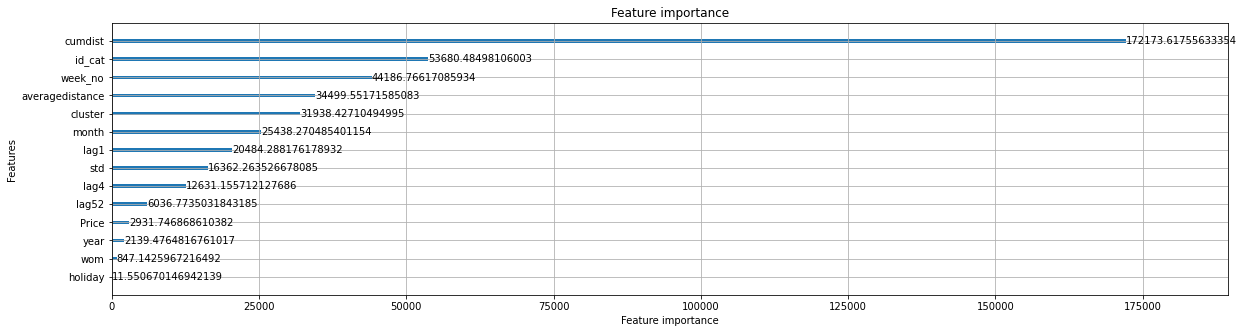

In [53]:
lgb.plot_importance(model,importance_type='gain',figsize=(20,5))

In [54]:
val_x1.head()

,Price,holiday,year,cumdist,averagedistance,cluster,wom,week_no,month,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,,,,,,,
2011-08-08,1.583599,-1.0,2011,0.0,0.013333,9,1,32,32,40.057125,1.636363,-1.109715,-0.248445,1
2011-08-15,1.583599,-1.0,2011,0.0,0.013333,9,2,33,33,40.057125,-0.510571,1.461613,-0.572982,1
2011-08-22,1.583599,-1.0,2011,0.0,0.013333,9,3,34,34,40.057125,-0.086177,-0.660357,0.375664,1
2011-08-29,1.583599,-1.0,2011,0.0,0.013333,9,4,35,35,40.057125,-0.223481,1.636363,0.088574,1
2011-09-05,1.583599,-1.0,2011,0.0,0.013333,9,0,36,36,40.057125,-0.435678,-0.510571,0.612825,1


In [55]:
val1['forecast'] = model.predict(val_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
train1['forecast'] = model.predict(train_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
train_val = pd.concat([train1,val1],axis=0)

In [58]:
vale = train_val.copy()
vale.head()

,StockCode,Quantity,Price,holiday,year,timeelapsed,cumsum,cumdist,averagedistance,cluster,wom,week_no,month,mean,std,tQuantity,lag1,lag4,lag52,forecast
ds,,,,,,,,,,,,,,,,,,,,
2010-05-31,20677,96.000000,1.583599,-1.0,2010,1.0,96.000000,0.0,0.013333,9,4,22,22,45.452,40.057125,1.261898,-1.000000,-1.000000,-1.0,-0.157390
2010-06-07,20677,10.500000,1.583599,-1.0,2010,1.0,106.500000,0.0,0.013333,9,1,23,23,45.452,40.057125,-0.872554,1.261898,-1.000000,-1.0,-0.160433
2010-06-14,20677,32.000000,1.583599,-1.0,2010,1.0,138.500000,0.0,0.013333,9,2,24,24,45.452,40.057125,-0.335820,-0.872554,-1.000000,-1.0,0.058505
2010-06-21,20677,30.833333,1.583599,-1.0,2010,1.0,169.333333,0.0,0.013333,9,3,25,25,45.452,40.057125,-0.364945,-0.335820,-1.000000,-1.0,-0.171867
2010-06-28,20677,123.666667,1.583599,-1.0,2010,1.0,293.000000,0.0,0.013333,9,4,26,26,45.452,40.057125,1.952578,-0.364945,1.261898,-1.0,1.079233


In [59]:
vale['forecast'].max()

4.897125724444363

In [60]:
vale = vale.reset_index()

In [61]:
for lag in range(2,5):
  vale['lag'+str(lag)] = vale.groupby(['StockCode'])['tQuantity'].shift(lag)

In [62]:
val_x1.columns

Index(['Price', 'holiday', 'year', 'cumdist', 'averagedistance', 'cluster',
       'wom', 'week_no', 'month', 'std', 'lag1', 'lag4', 'lag52', 'id_cat'],
      dtype='object')

In [63]:
data.shape

(305914, 20)

In [64]:
def recursive_forecast(val,data,model,id_encoder,forecast_range=7,var='Quantity'):
  dat = val.copy()
  dat1 =data.copy()
  colname= dat.columns.tolist()
  for lag in range(2,5):
    dat['lag'+str(lag)] = dat.groupby(['StockCode'])[var].shift(lag)
  
  dat = dat.groupby(['StockCode'])[colname].tail(1).reset_index()
  da = dat.copy()
  # print(da)
  da_f = pd.DataFrame()  
  for fr in range(1,forecast_range):
    
    da['ds'] = da['ds'] + pd.DateOffset(days=7)
    if fr < 5:
      for i in range(1,5):
        if i == 1:
          da['lag'+str(i)] = dat['forecast'].values
                   
        else:
          da['lag'+str(i+1)] = dat['lag'+str(i)].values
          
        if i == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          # print(datt)
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          # print(dat12)
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] = datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          # print(da11)

          da['lag52'] = da11['lag52']
                  
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          da1 = da[['week_no', 'wom', 'year', 'timeelapsed', 'cumdist', 'std', 'lag1',
                    'lag4', 'lag52', 'id_cat']]
          da1.fillna(-1,inplace=True)
          
          da.loc[:,'forecast'] = model.predict(da1)
          da['lforecast'] = np.where(da['forecast']*da['std']+da['mean'] < 0,0,da['forecast']*da['std']+da['mean'])
          da['cumsum'] = da['cumsum']+da['lforecast']
          da['cumdist'] = da.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1 
          da.fillna(-1,inplace=True)
          print(da)
      da_f = pd.concat([da_f,da],axis=0)
    
    else:
      for j in range(1,5):
        if j == 1 :
          da['lag'+str(j)] = da['forecast']
          
        elif j < 5:
          # print(da['lag'+str(j+1)])
          da['lag'+str(j+1)] = da['lag'+str(j)]
        if j == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          # print(datt,'\n',da['ds'])
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] =datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          # da11 = da11.rename(columns={})
          # print(da11)
          da['lag52'] = da11['lag52']
          
          # print(da)
          # print(da['lag365'])
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          da1 = da[['week_no', 'wom', 'year', 'timeelapsed', 'cumdist', 'std', 'lag1',
                    'lag4', 'lag52', 'id_cat']]
          da1.fillna(-1,inplace=True)
          # print(da1)
          # print(da1.head())
          da.loc[:,'forecast'] = model.predict(da1)
          da['lforecast'] = np.where(da['forecast']*da['std']+da['mean'] < 0,0,da['forecast']*da['std']+da['mean'])
          # da['cumsum'] = da.groupby(['StockCode'])['lforecast'].cumsum()
          da['cumsum'] = da['cumsum']+da['lforecast']
          da['cumdist'] = da.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1
          da.fillna(-1,inplace=True)
          print(da)
          
      da_f = pd.concat([da_f,da],axis=0)
  return da_f
 

In [65]:
(pd.to_datetime('2011-09-12') + pd.DateOffset(days=7))-pd.to_timedelta(52, unit='w')

Timestamp('2010-09-20 00:00:00')

In [66]:
data1.min()

Quantity                             0
Price                        0.0514286
holiday                             -1
ds                 2010-01-04 00:00:00
year                              2010
timeelapsed                          0
cumsum                               0
cumdist                             -1
averagedistance                      0
cluster                              0
wom                                  0
week_no                              1
month                                1
mean                                 0
std                                  0
tQuantity                     -1.91374
dtype: object

In [67]:
data.loc[data['ds']<'2010-09-20']

,StockCode,Quantity,Price,holiday,ds,year,timeelapsed,cumsum,cumdist,averagedistance,cluster,wom,week_no,month,mean,std,tQuantity,lag1,lag4,lag52
0,20677,96.000000,1.583599,-1.0,2010-05-31,2010,1.0,96.000000,0.0,0.013333,9,4,22,22,45.452000,40.057125,1.261898,-1.000000,-1.000000,-1.0
1,20677,10.500000,1.583599,-1.0,2010-06-07,2010,1.0,106.500000,0.0,0.013333,9,1,23,23,45.452000,40.057125,-0.872554,1.261898,-1.000000,-1.0
2,20677,32.000000,1.583599,-1.0,2010-06-14,2010,1.0,138.500000,0.0,0.013333,9,2,24,24,45.452000,40.057125,-0.335820,-0.872554,-1.000000,-1.0
3,20677,30.833333,1.583599,-1.0,2010-06-21,2010,1.0,169.333333,0.0,0.013333,9,3,25,25,45.452000,40.057125,-0.364945,-0.335820,-1.000000,-1.0
4,20677,123.666667,1.583599,-1.0,2010-06-28,2010,1.0,293.000000,0.0,0.013333,9,4,26,26,45.452000,40.057125,1.952578,-0.364945,1.261898,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305850,gift_0001_30,0.000000,25.420417,-1.0,2010-08-16,2010,1.0,22.000000,1.0,3.343750,14,2,33,33,0.578125,1.979272,-0.292090,0.213147,0.213147,-1.0
305851,gift_0001_30,0.000000,25.420417,-1.0,2010-08-23,2010,1.0,22.000000,2.0,3.343750,14,3,34,34,0.578125,1.979272,-0.292090,-0.292090,-0.292090,-1.0
305852,gift_0001_30,0.000000,25.420417,-1.0,2010-08-30,2010,1.0,22.000000,3.0,3.343750,14,4,35,35,0.578125,1.979272,-0.292090,-0.292090,-0.292090,-1.0
305853,gift_0001_30,10.000000,25.420417,-1.0,2010-09-06,2010,1.0,32.000000,0.0,3.343750,14,0,36,36,0.578125,1.979272,4.760274,-0.292090,0.213147,-1.0


In [68]:
fr = recursive_forecast(vale,data1,model,id_encoder,8,'tQuantity')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



       index         ds     StockCode  ...       ds52  id_cat  lforecast
0     113313 2010-06-21         22554  ... 2009-06-22    1367  24.440153
1     161353 2010-06-07         20677  ... 2009-06-08    2052  35.760424
2     260986 2011-09-19         20677  ... 2010-09-20       1  13.384670
3     260992 2011-09-19         20679  ... 2010-09-20       2   0.000000
4     260998 2011-09-19         20681  ... 2010-09-20       3   2.589298
...      ...        ...           ...  ...        ...     ...        ...
3452  281692 2011-09-19             M  ... 2010-09-20    3453   0.000000
3453  281698 2011-09-19          PADS  ... 2010-09-20    3454   0.000000
3454  281704 2011-09-19          POST  ... 2010-09-20    3455   0.000000
3455  281710 2011-09-19  gift_0001_20  ... 2010-09-20    3456   0.000000
3456  281716 2011-09-19  gift_0001_30  ... 2010-09-20    3457   0.000000

[3457 rows x 28 columns]
       index         ds     StockCode  ...       ds52  id_cat  lforecast
0     113313 2010-06-28  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



       index         ds     StockCode  ...       ds52  id_cat  lforecast
0     113313 2010-07-12         22554  ... 2009-07-13    1367  24.440153
1     161353 2010-06-28         20677  ... 2009-06-29    2052  26.903451
2     260986 2011-10-10         20677  ... 2010-10-11       1  13.384670
3     260992 2011-10-10         20679  ... 2010-10-11       2   0.000000
4     260998 2011-10-10         20681  ... 2010-10-11       3   0.000000
...      ...        ...           ...  ...        ...     ...        ...
3452  281692 2011-10-10             M  ... 2010-10-11    3453   0.000000
3453  281698 2011-10-10          PADS  ... 2010-10-11    3454   0.000000
3454  281704 2011-10-10          POST  ... 2010-10-11    3455   0.000000
3455  281710 2011-10-10  gift_0001_20  ... 2010-10-11    3456   0.000000
3456  281716 2011-10-10  gift_0001_30  ... 2010-10-11    3457   0.000000

[3457 rows x 28 columns]
       index         ds     StockCode  ...       ds52  id_cat  lforecast
0     113313 2010-07-19  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



       index         ds     StockCode  ...       ds52  id_cat  lforecast
0     113313 2010-07-26         22554  ... 2009-07-27    1367  24.440153
1     161353 2010-07-12         20677  ... 2009-07-13    2052  26.903451
2     260986 2011-10-24         20677  ... 2010-10-25       1  13.983282
3     260992 2011-10-24         20679  ... 2010-10-25       2   0.000000
4     260998 2011-10-24         20681  ... 2010-10-25       3   0.000000
...      ...        ...           ...  ...        ...     ...        ...
3452  281692 2011-10-24             M  ... 2010-10-25    3453   0.000000
3453  281698 2011-10-24          PADS  ... 2010-10-25    3454   0.000000
3454  281704 2011-10-24          POST  ... 2010-10-25    3455   0.000000
3455  281710 2011-10-24  gift_0001_20  ... 2010-10-25    3456   0.000000
3456  281716 2011-10-24  gift_0001_30  ... 2010-10-25    3457   0.000000

[3457 rows x 28 columns]
       index         ds     StockCode  ...       ds52  id_cat  lforecast
0     113313 2010-08-02  

In [69]:
fr.isnull().sum()

index              0
ds                 0
StockCode          0
Quantity           0
Price              0
holiday            0
year               0
timeelapsed        0
cumsum             0
cumdist            0
averagedistance    0
cluster            0
wom                0
week_no            0
month              0
mean               0
std                0
tQuantity          0
lag1               0
lag4               0
lag52              0
forecast           0
lag2               0
lag3               0
lag5               0
ds52               0
id_cat             0
lforecast          0
dtype: int64

In [70]:
test = test.reset_index()

In [71]:
# train_val.loc[train_val['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),]

In [72]:
test.isnull().sum()

ds                 0
StockCode          0
Quantity           0
Price              0
holiday            0
year               0
timeelapsed        0
cumsum             0
cumdist            0
averagedistance    0
cluster            0
wom                0
week_no            0
month              0
mean               0
std                0
tQuantity          0
lag1               0
lag4               0
lag52              0
dtype: int64

In [73]:
test1 = test.merge(fr[['StockCode','ds','lforecast']],on=['StockCode','ds'],how='left')
# test1['forecast'] = test1['forecast']*test1['std'] + test1['mean']
test1['error'] = np.abs(test1['Quantity']-test1['lforecast'])/(test1['Quantity']+1)
t2 = test1.loc[test1['Quantity']>0,]
t = test1.groupby('StockCode')['error'].mean().reset_index()

In [74]:
test1.isnull().sum()

ds                 0
StockCode          0
Quantity           0
Price              0
holiday            0
year               0
timeelapsed        0
cumsum             0
cumdist            0
averagedistance    0
cluster            0
wom                0
week_no            0
month              0
mean               0
std                0
tQuantity          0
lag1               0
lag4               0
lag52              0
lforecast          4
error              4
dtype: int64

In [75]:
t = t.sort_values(by=['error'])

In [76]:
t.groupby(['StockCode'])['error'].mean().mean()

0.5574310956470026

In [77]:
t.sort_values(by=['error'])

,StockCode,error
2986,84877B,0.000000
2719,82607E,0.000000
134,20957,0.000000
2718,82607C,0.000000
2717,82607A,0.000000
...,...,...
761,21829,6.761912
938,22088,6.972188
2715,82600,8.338288
2660,79000,12.673022


In [78]:
t3  = t2.groupby('StockCode')['error'].mean().reset_index()

In [79]:
t3.to_csv('../../data/lgb_cluster_mape.csv',index=False)

In [80]:
t2.groupby(['StockCode'])['error'].mean().mean()

0.7705935575832141

In [81]:
stock_cont = data1.groupby(['StockCode'])['Quantity'].sum()/data1['Quantity'].sum()

In [82]:
t = t.merge(stock_cont,on=['StockCode'],how='left')

In [83]:
t.sort_values(by=['Quantity'],ascending=False).head(60)

,StockCode,error,Quantity
1927,84077,0.618794,0.008825
3296,17003,0.987801,0.007283
1646,21212,0.528071,0.005959
2423,22492,0.757368,0.005075
2129,84568,0.681166,0.004837
85,37410,0.000000,0.004460
1824,21977,0.588277,0.003986
2458,22197,0.766979,0.003751
1572,84991,0.506394,0.003651
3285,21980,0.982341,0.003643


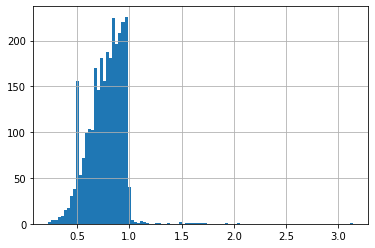

In [84]:
t3.loc[~t3['error'].isnull(),'error'].hist(bins=100)

In [85]:
test1.loc[test1['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),'lforecast'] = test1.loc[test1['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),'lforecast']

In [86]:
# len(t3[t3 <.2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

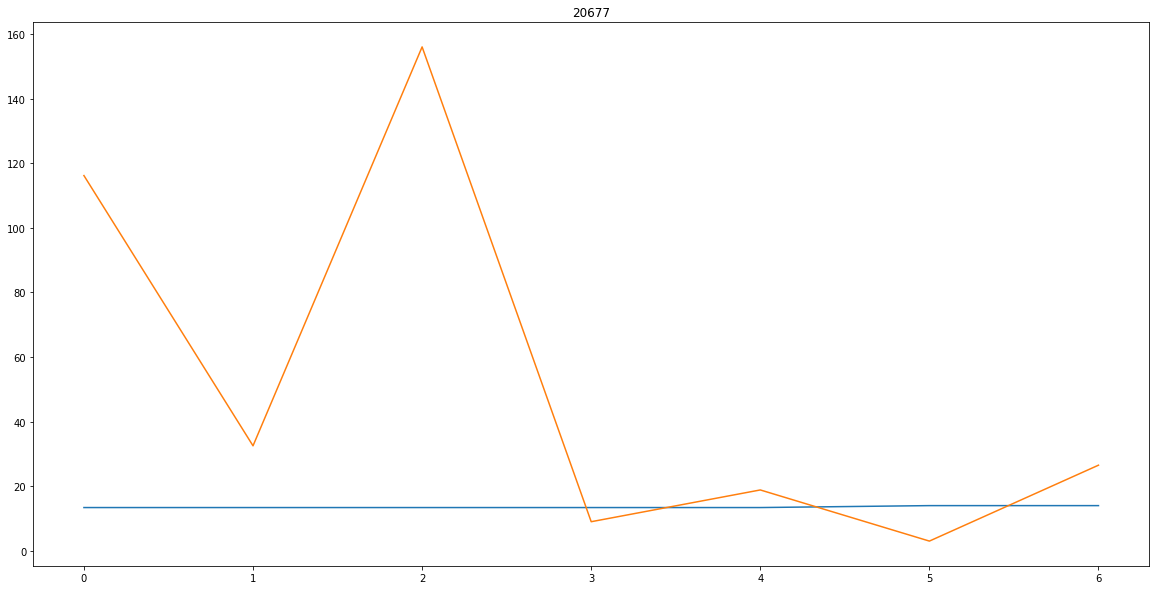

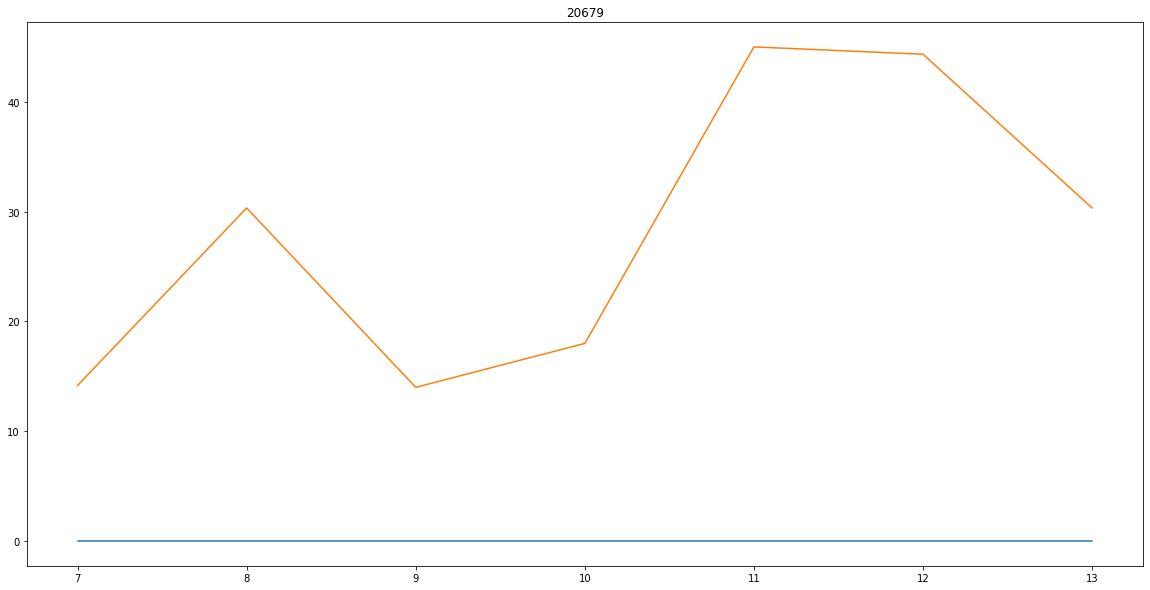

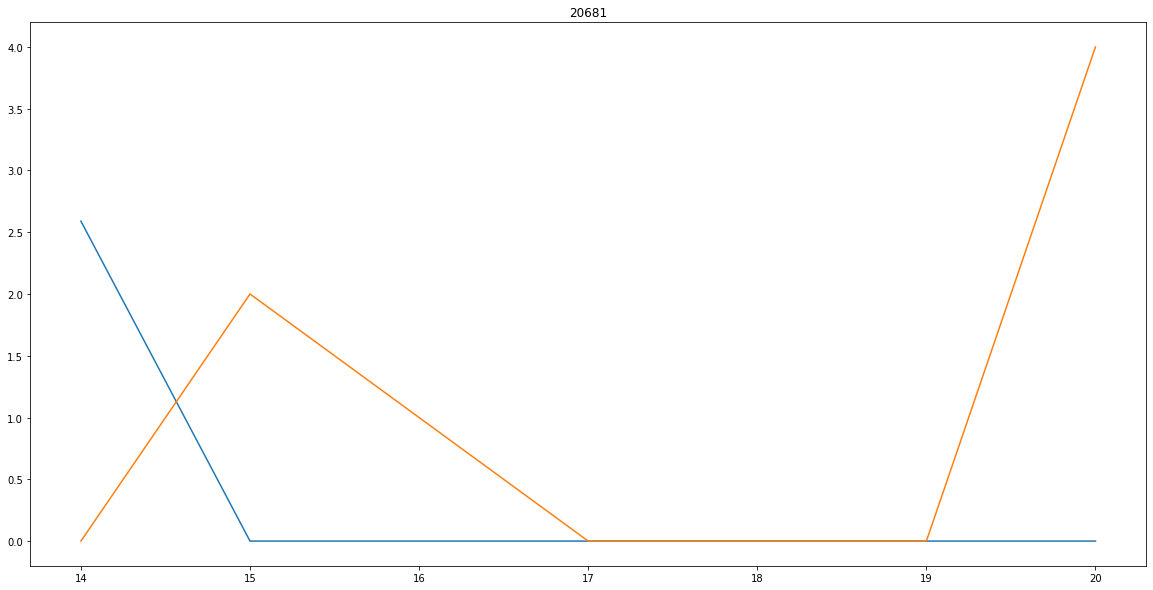

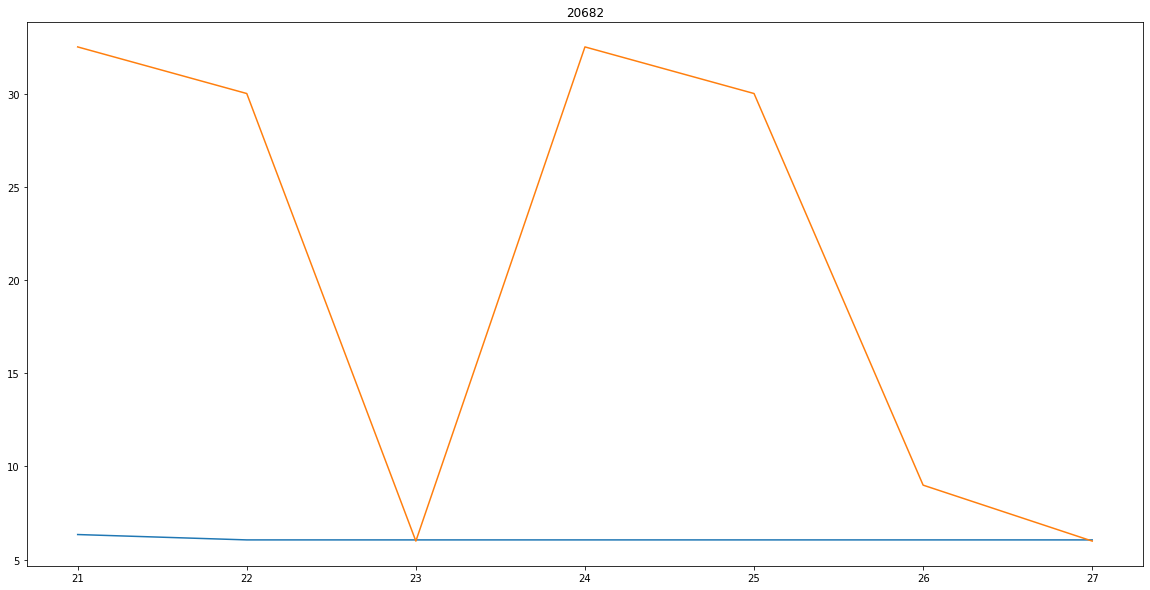

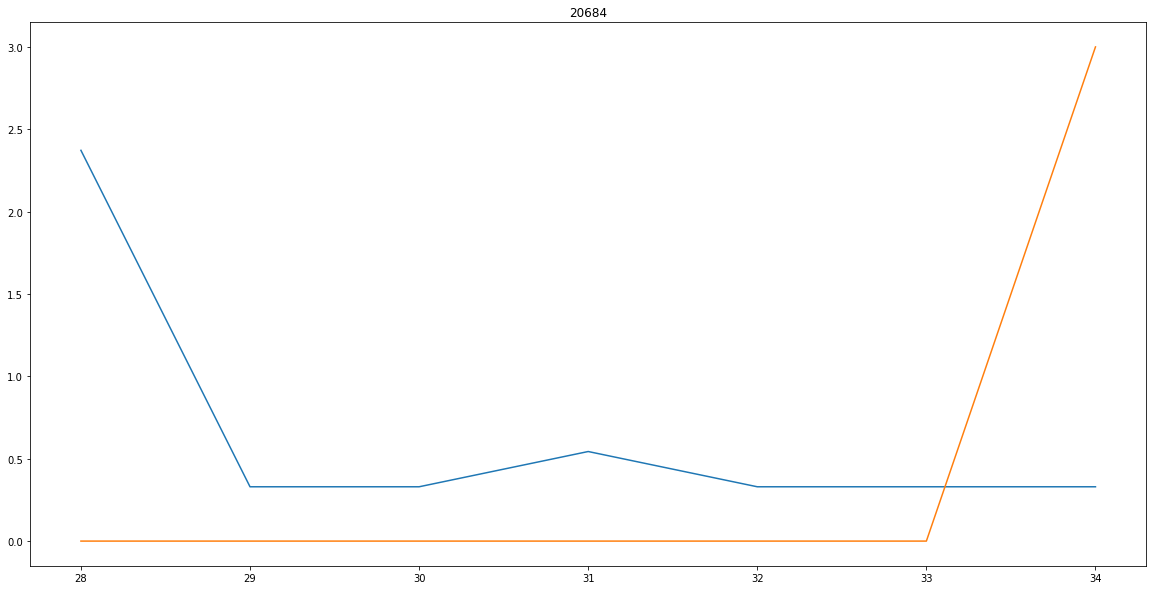

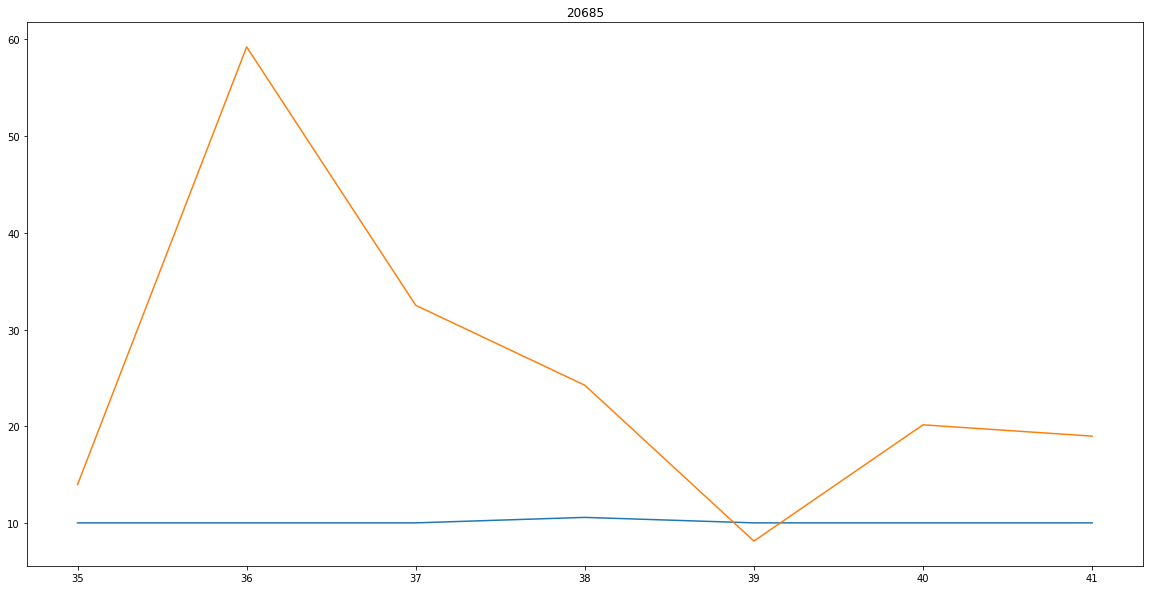

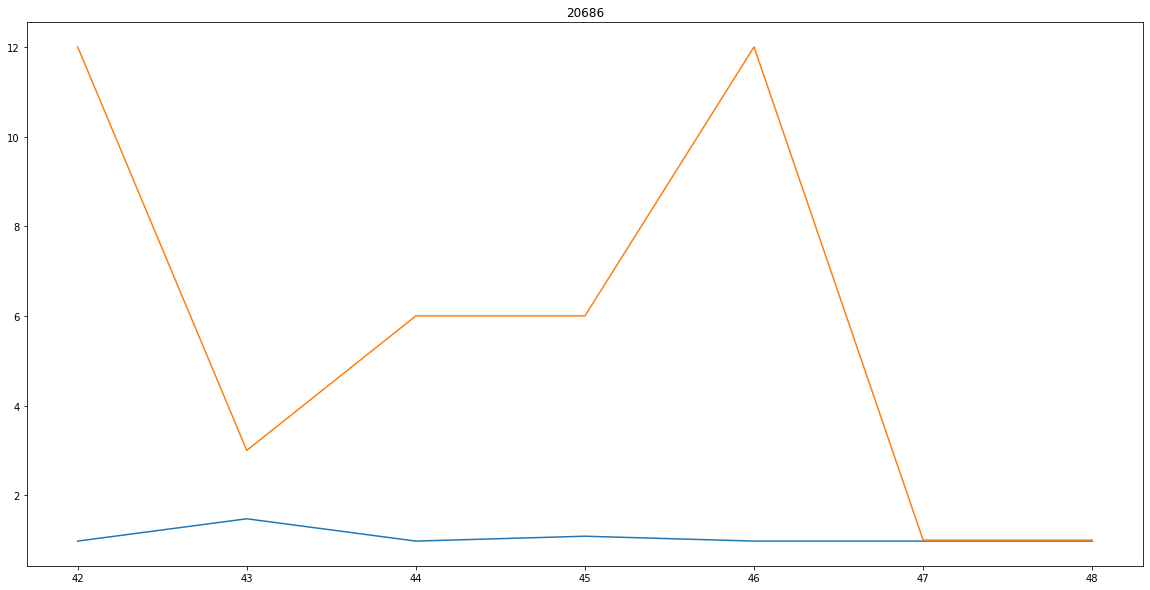

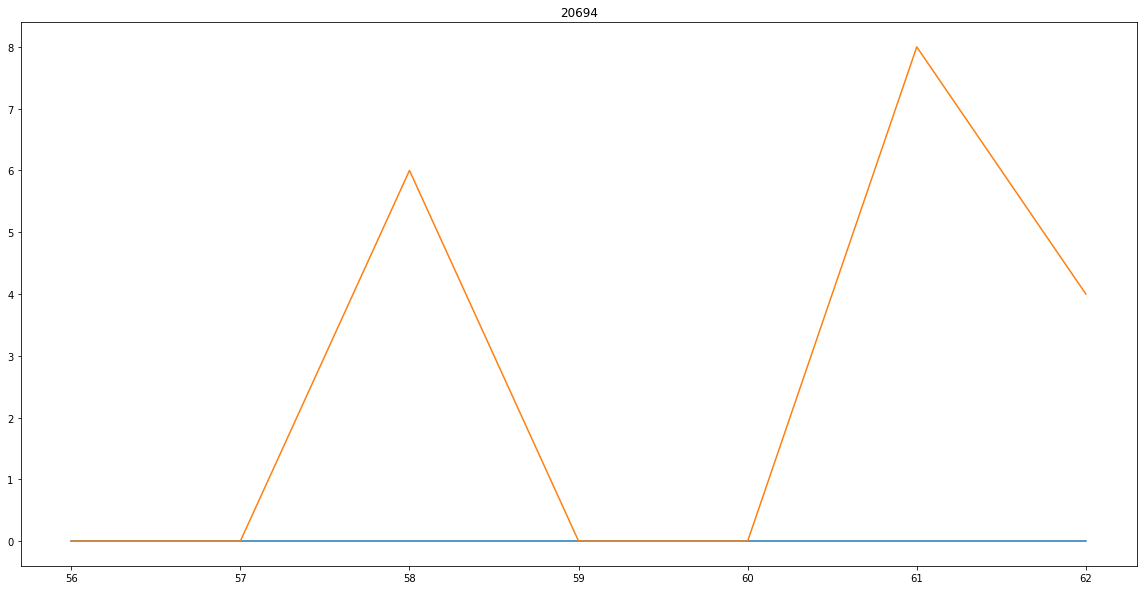

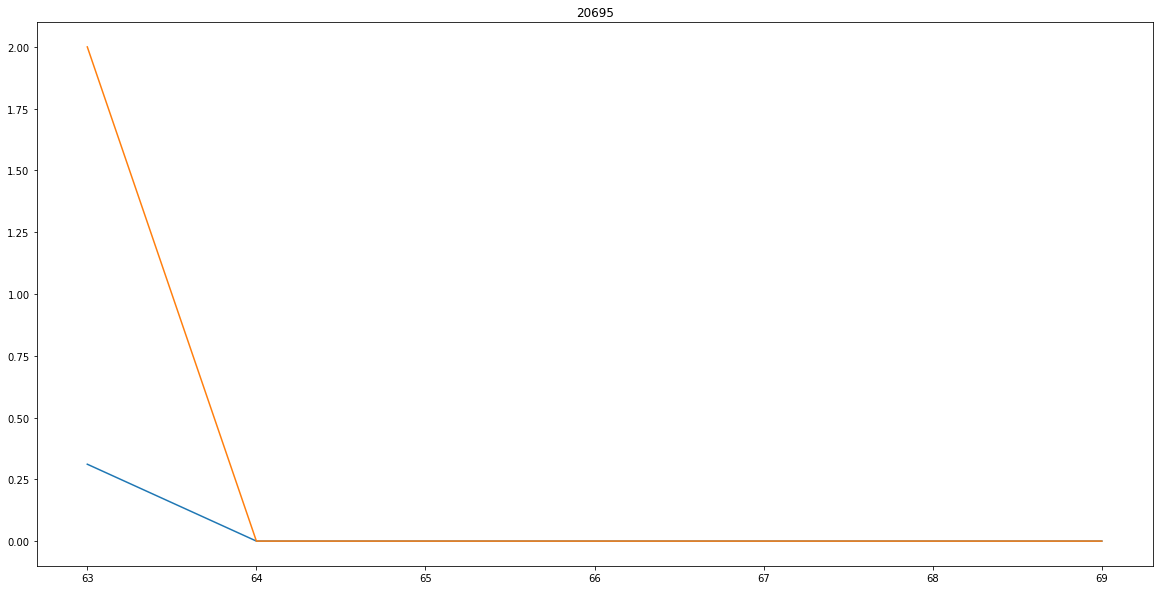

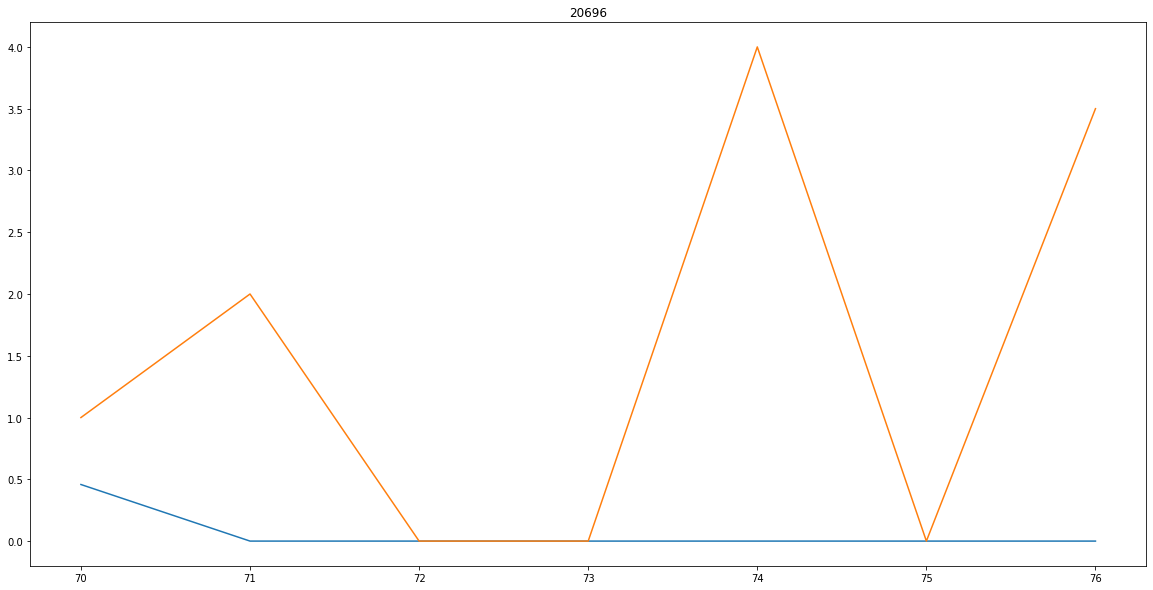

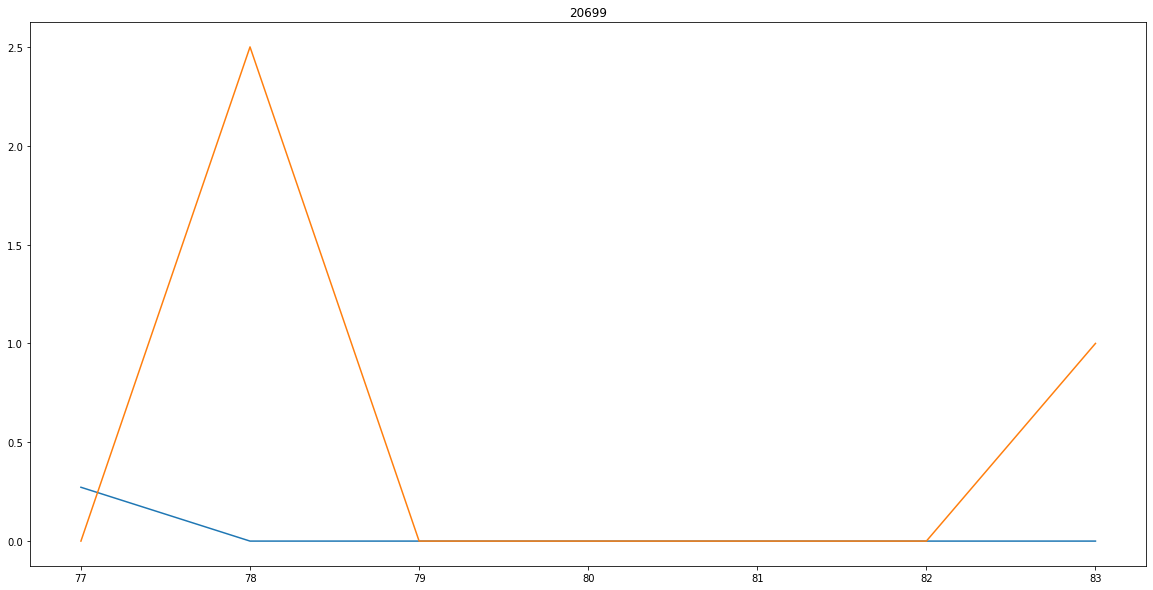

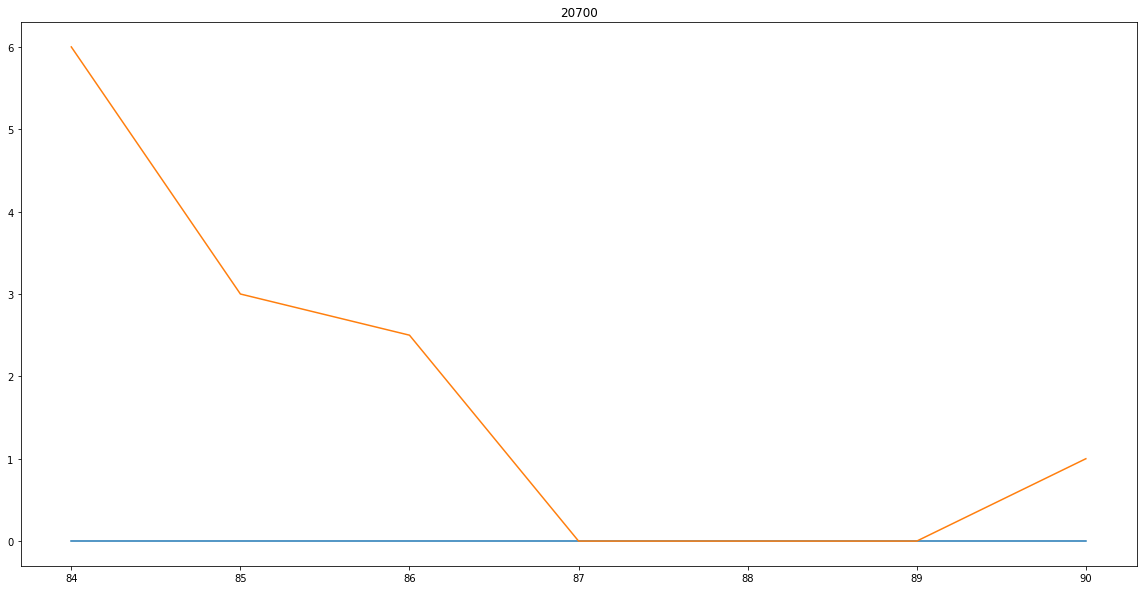

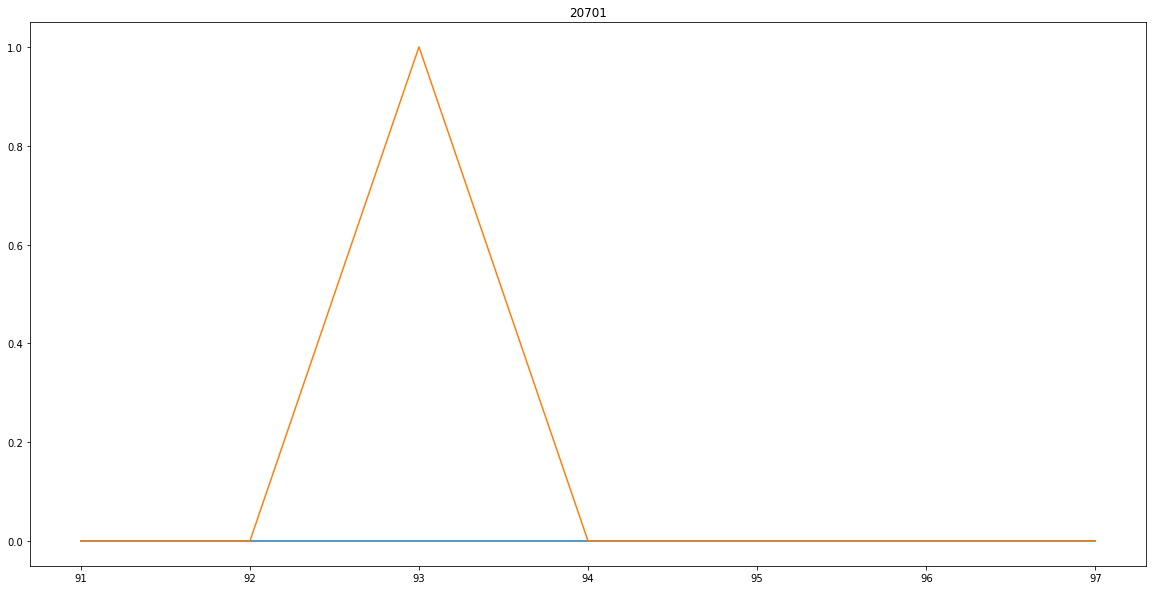

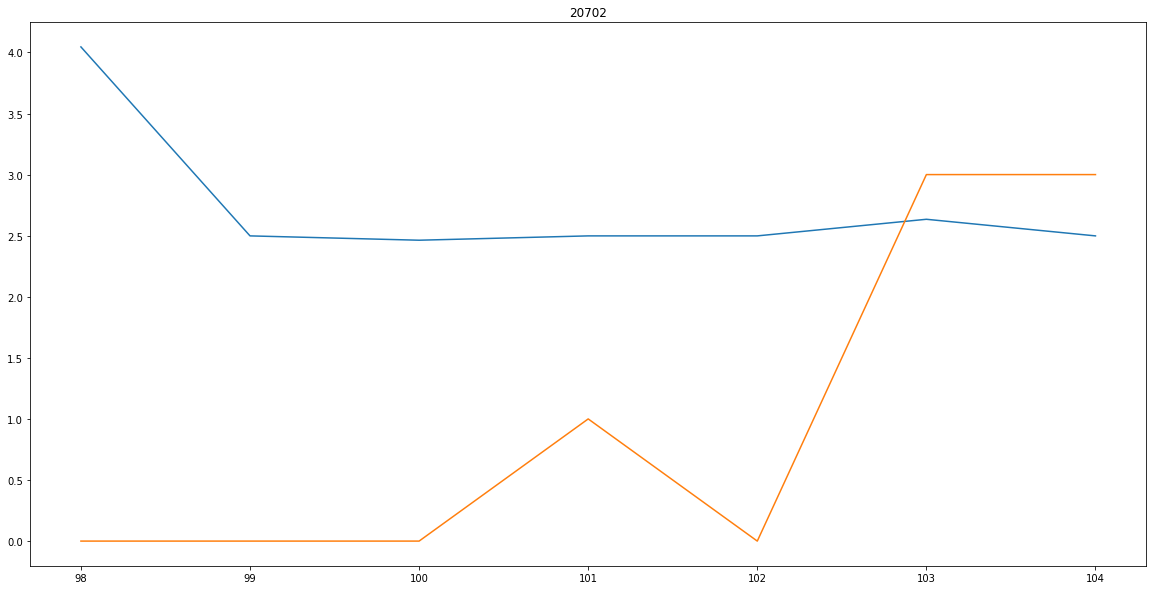

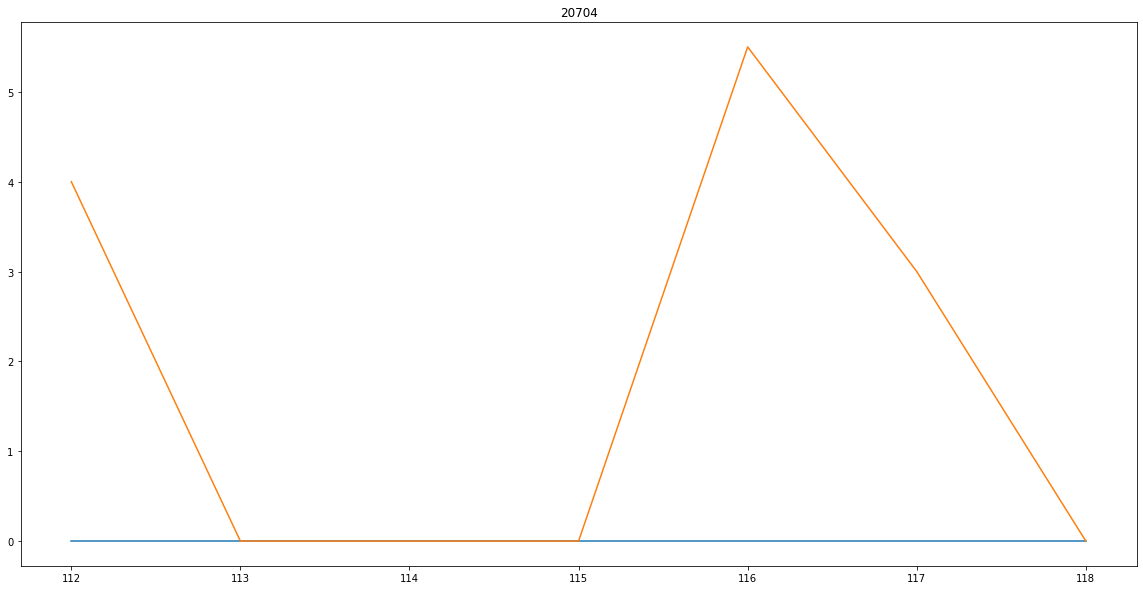

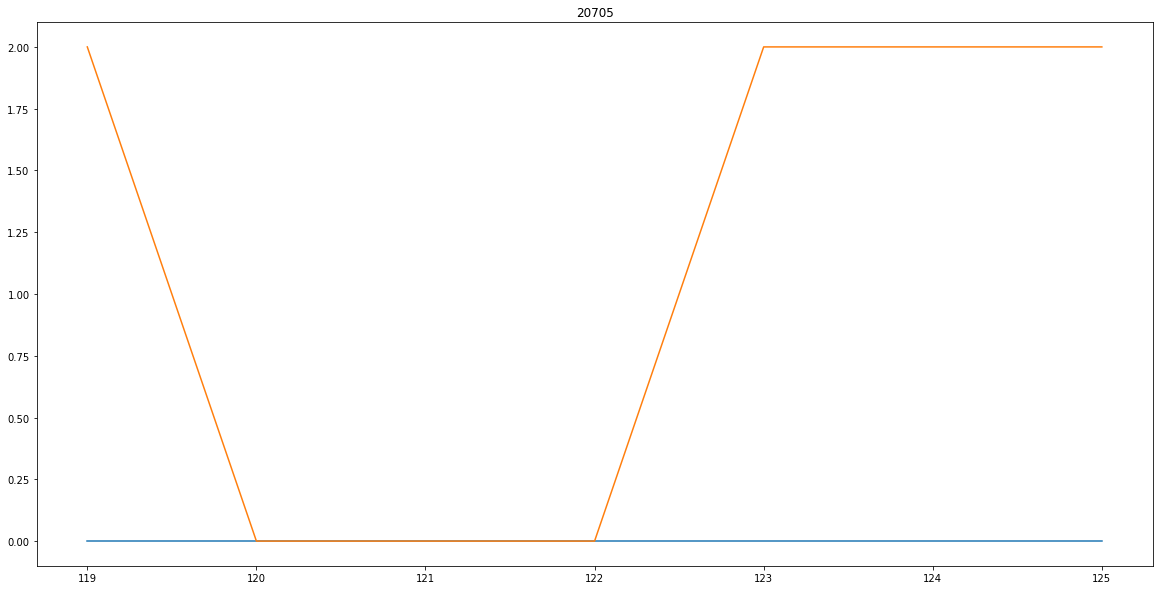

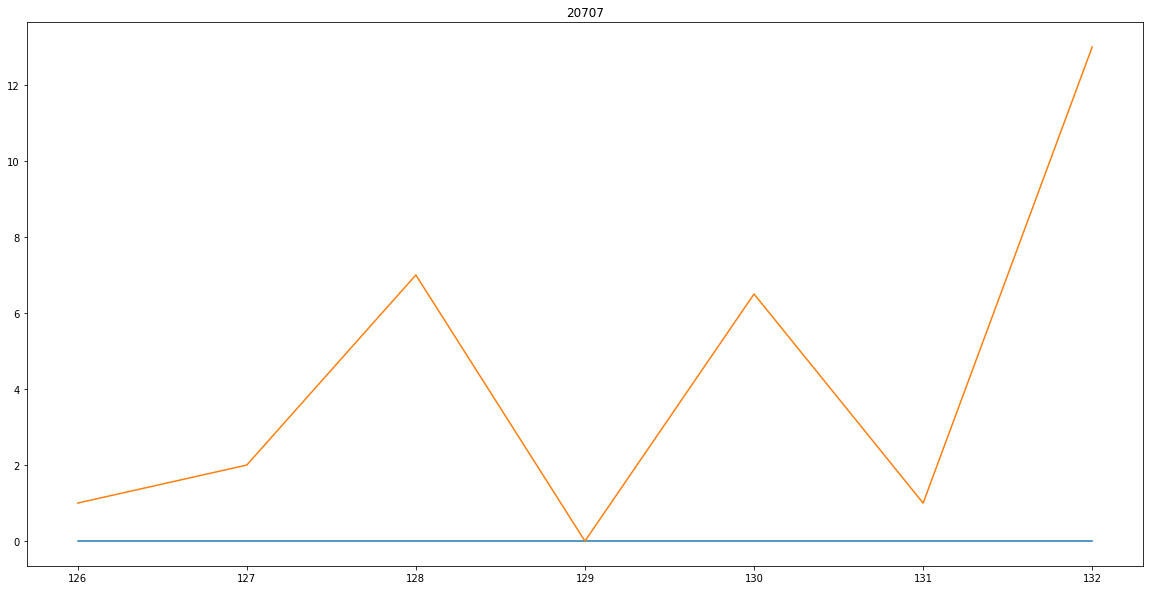

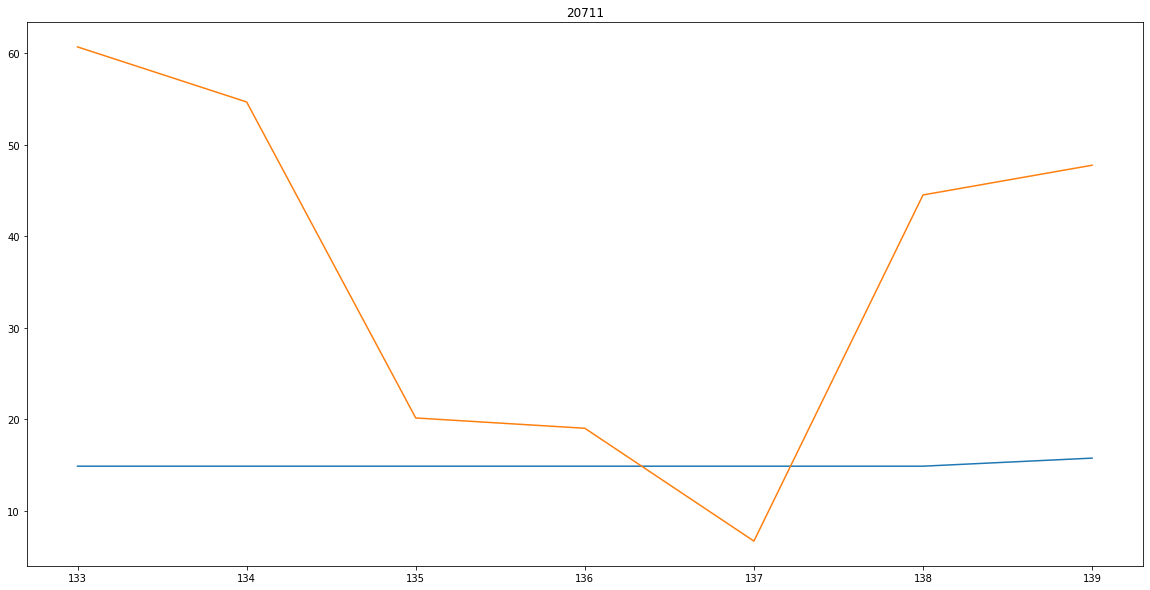

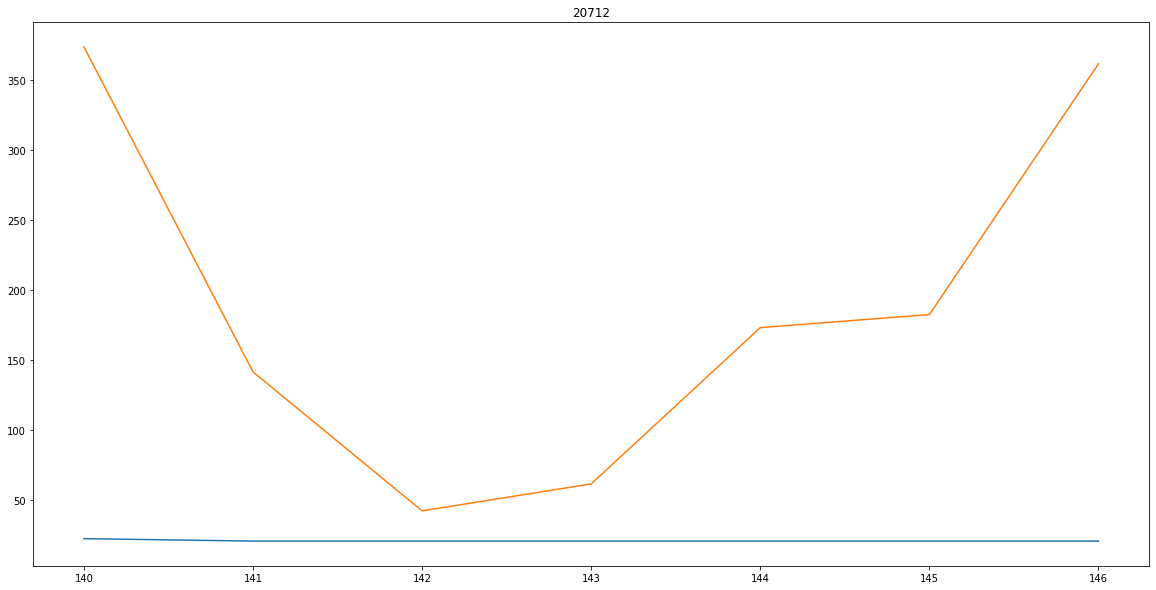

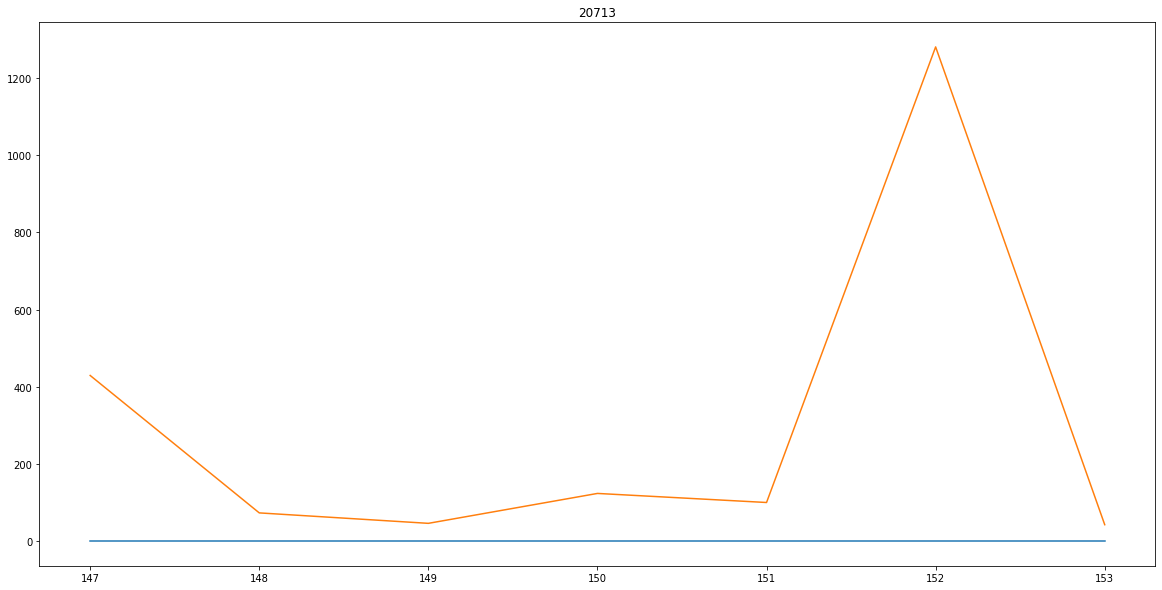

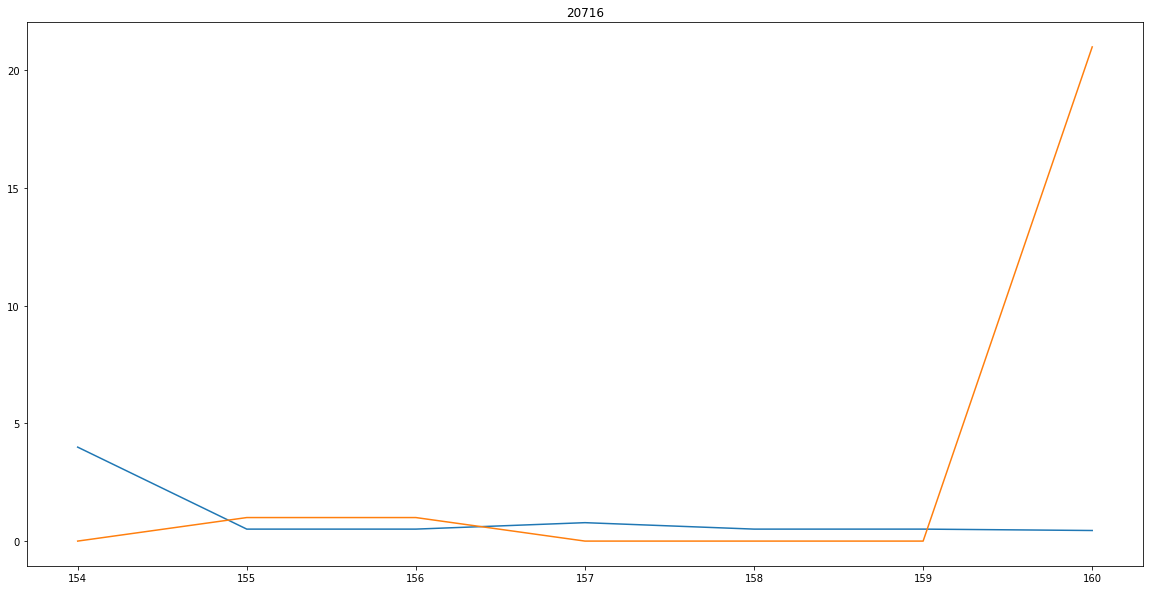

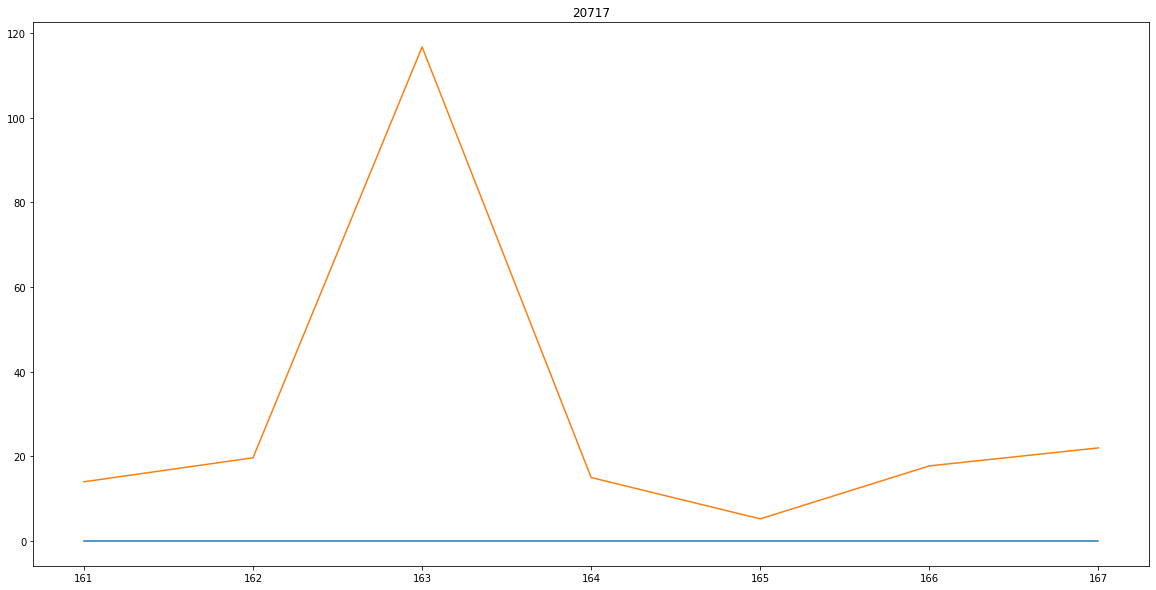

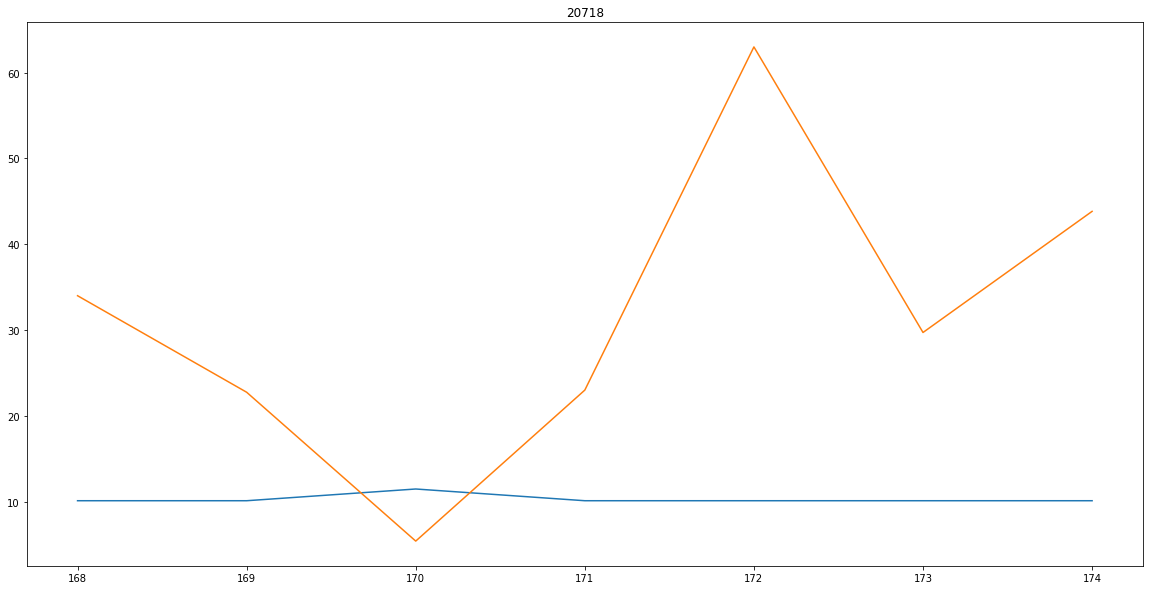

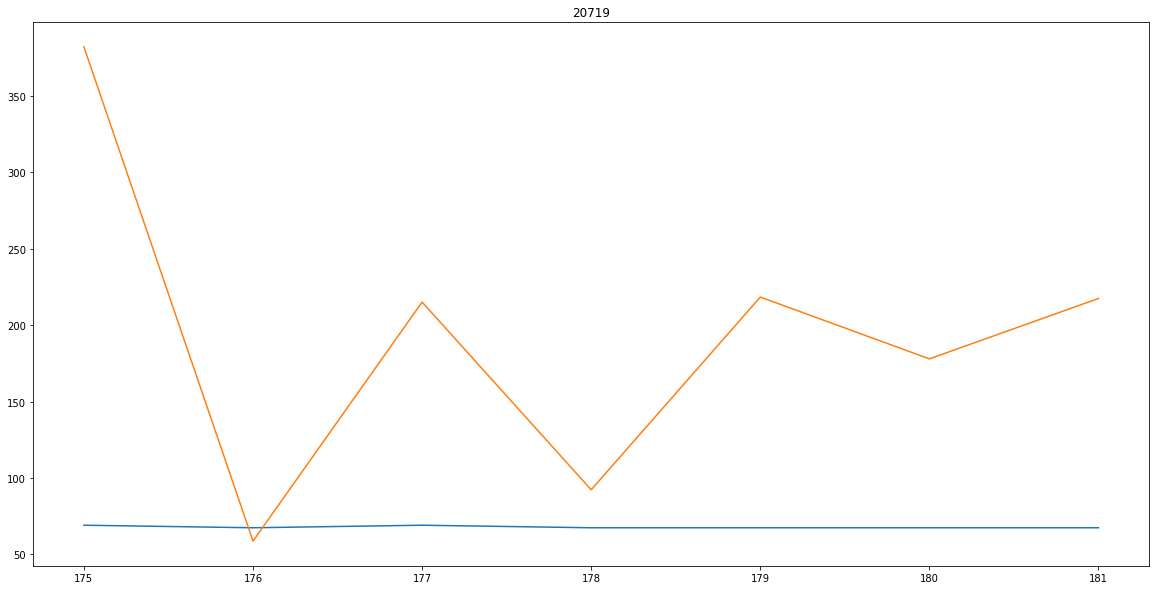

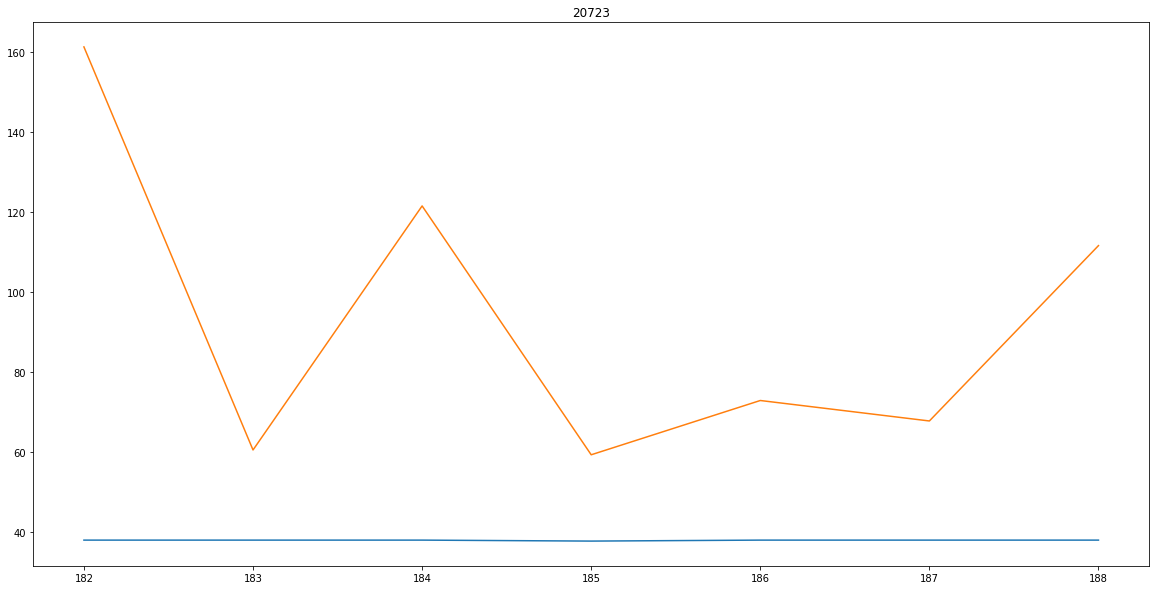

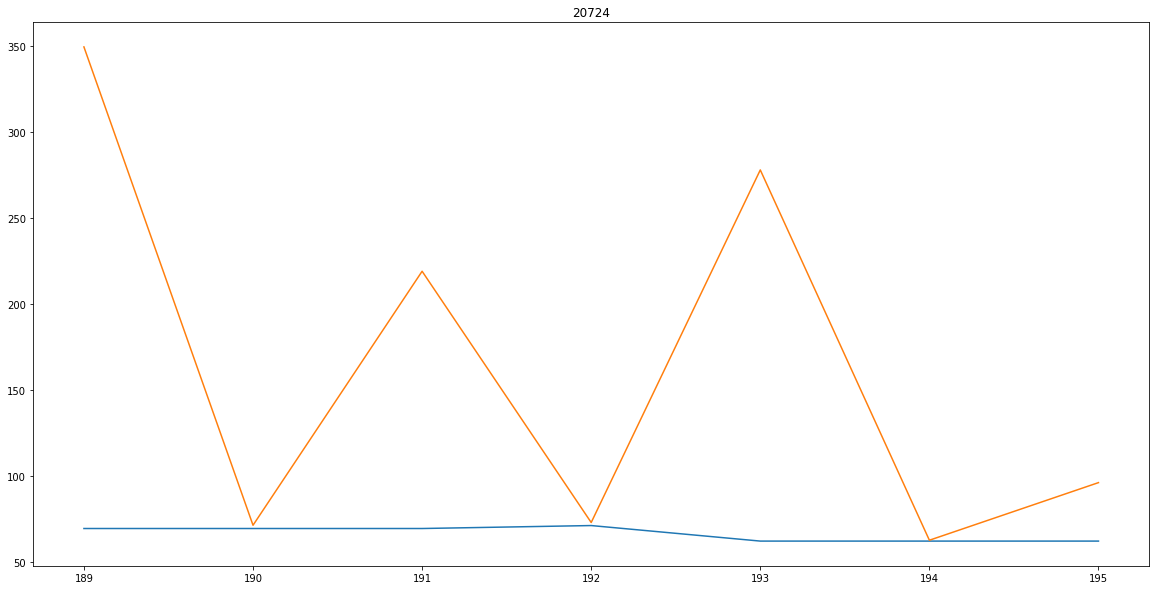

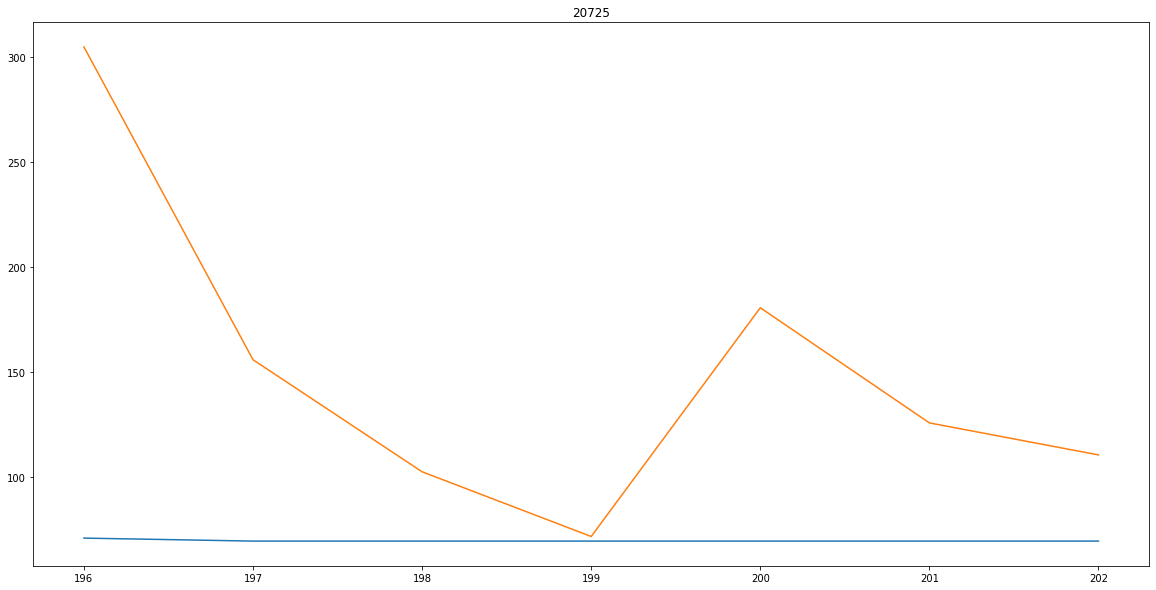

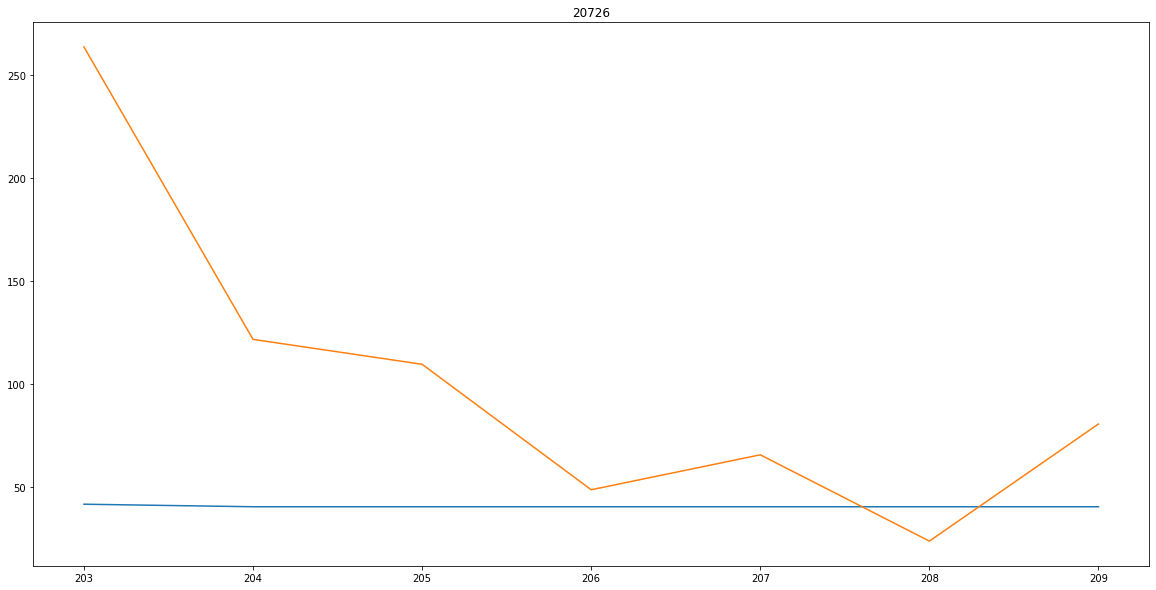

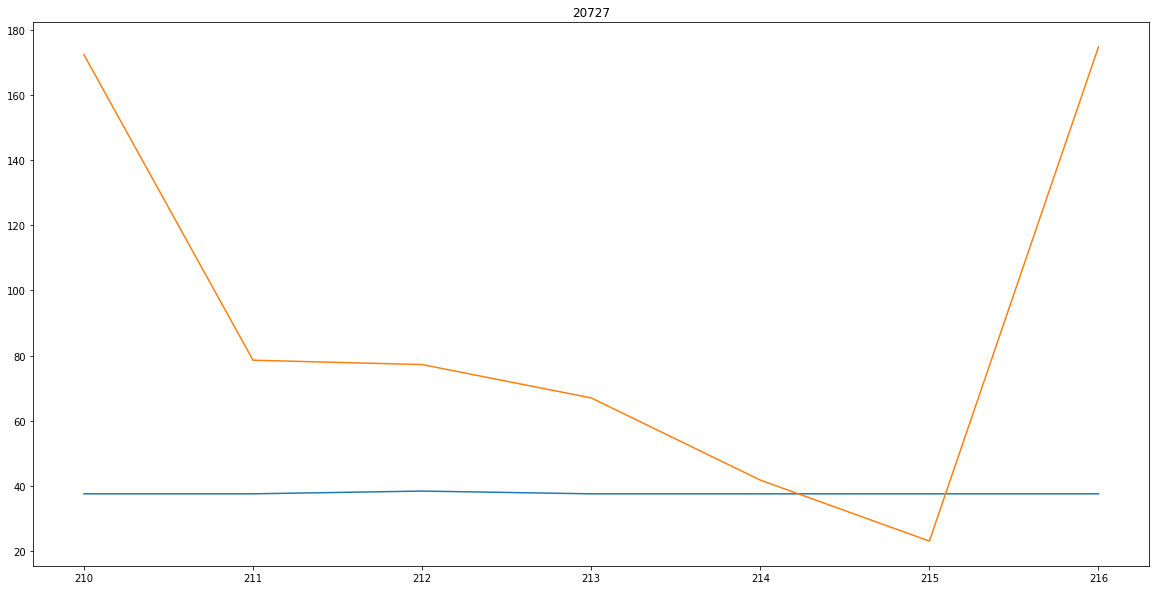

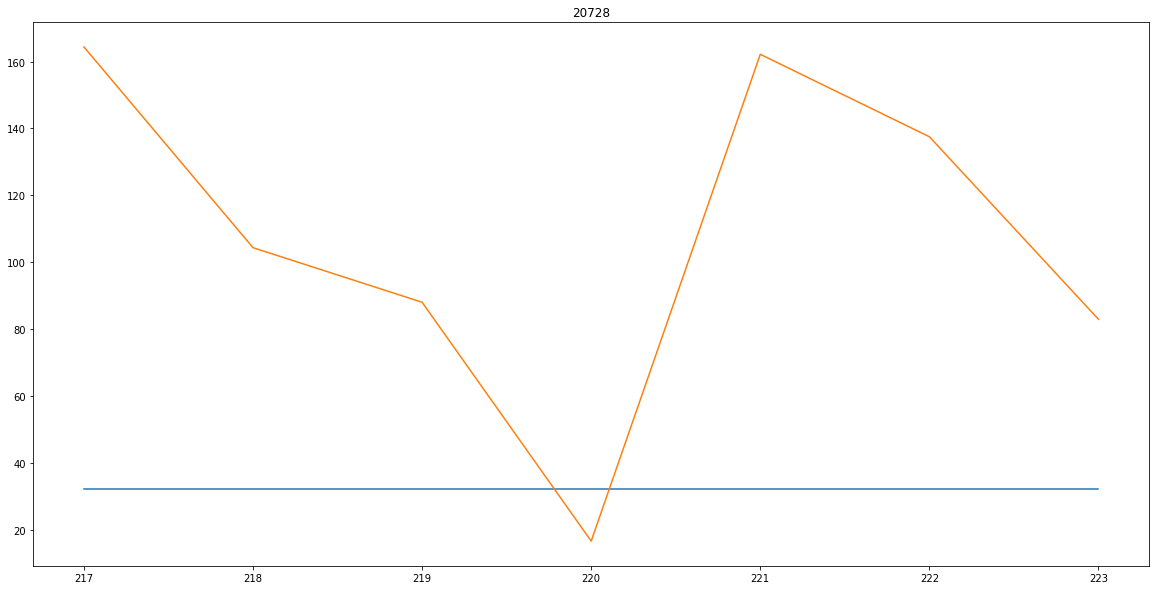

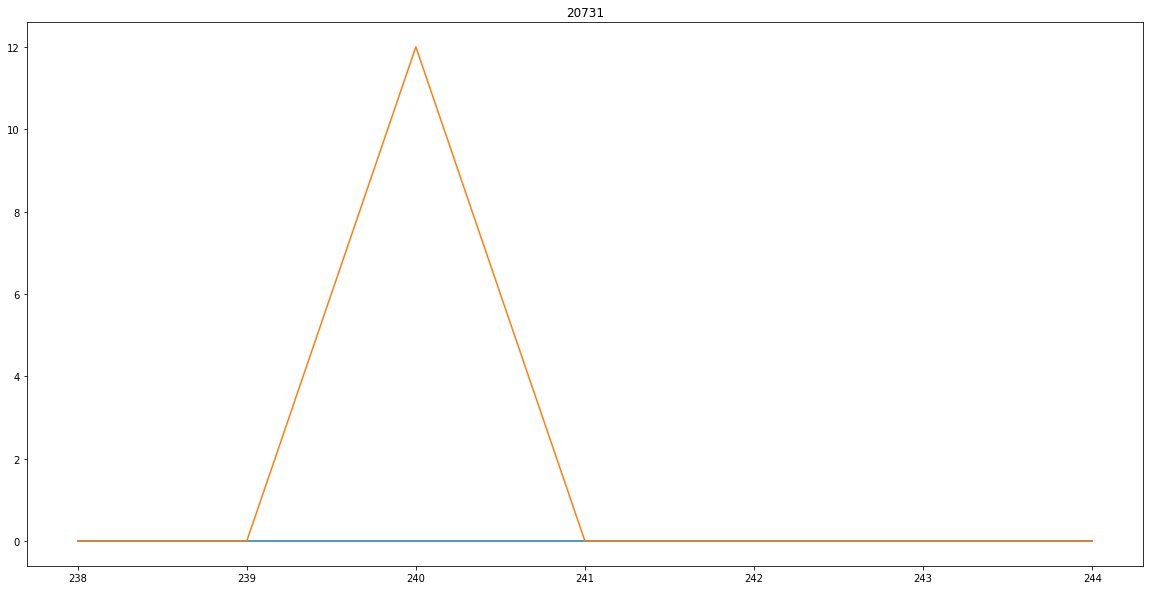

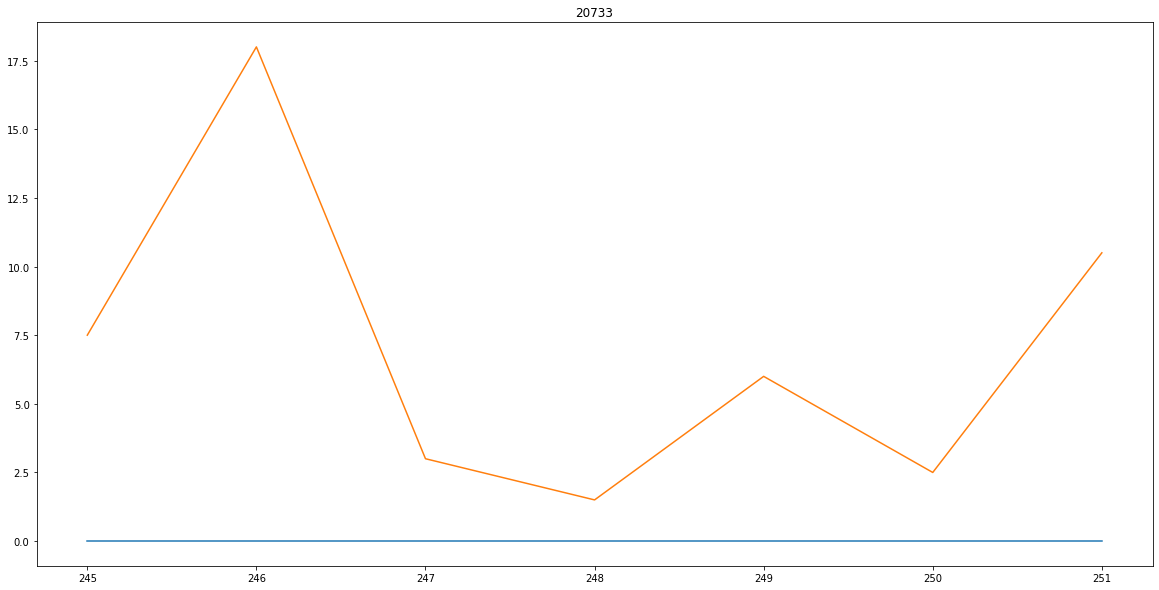

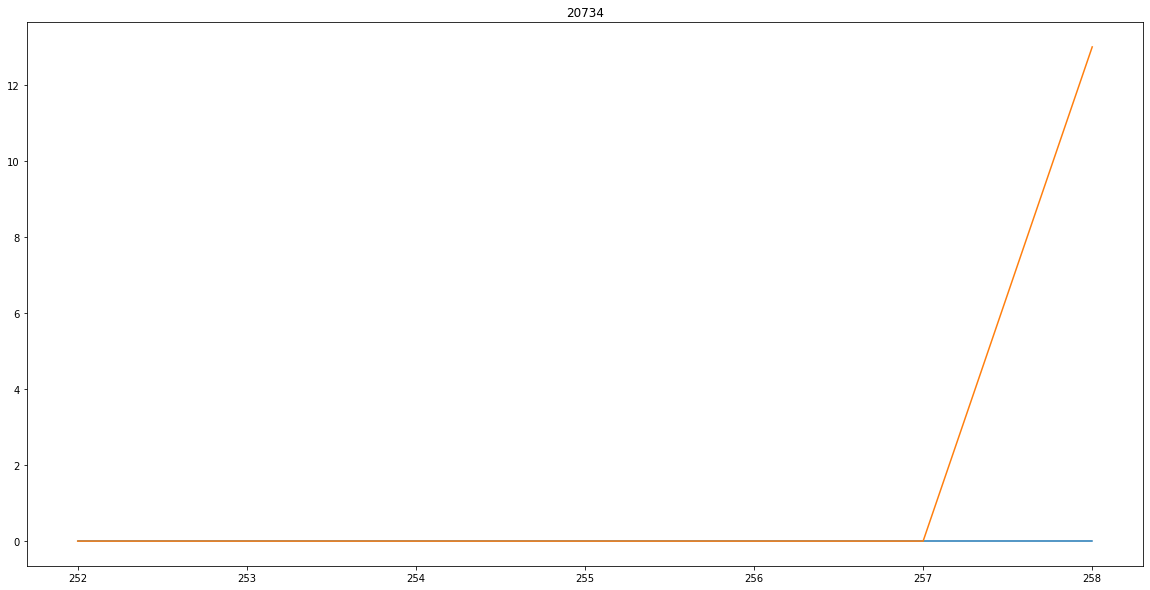

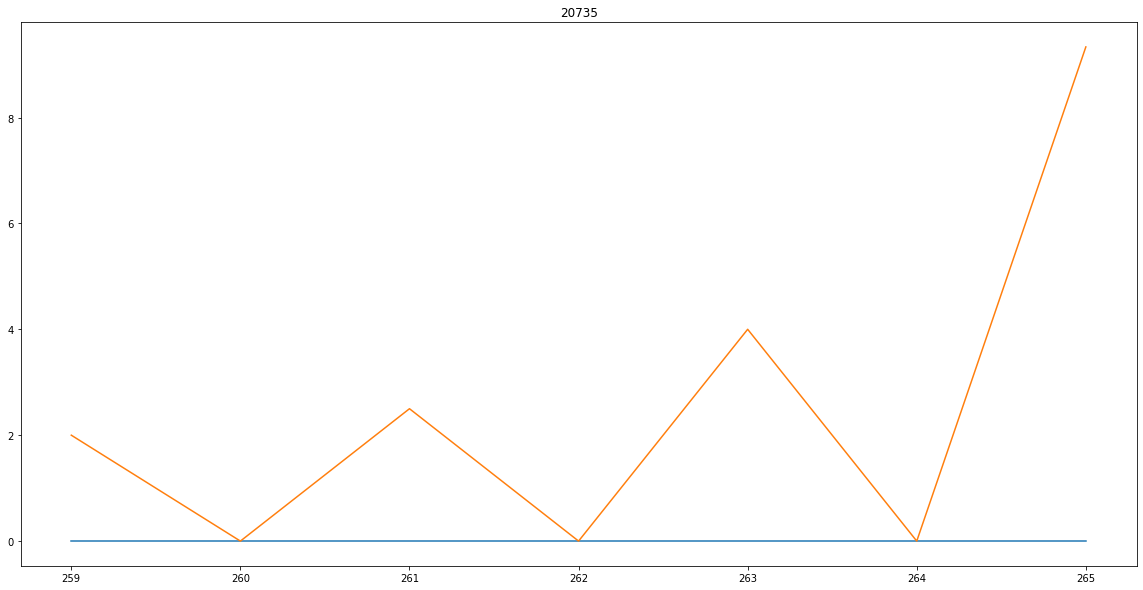

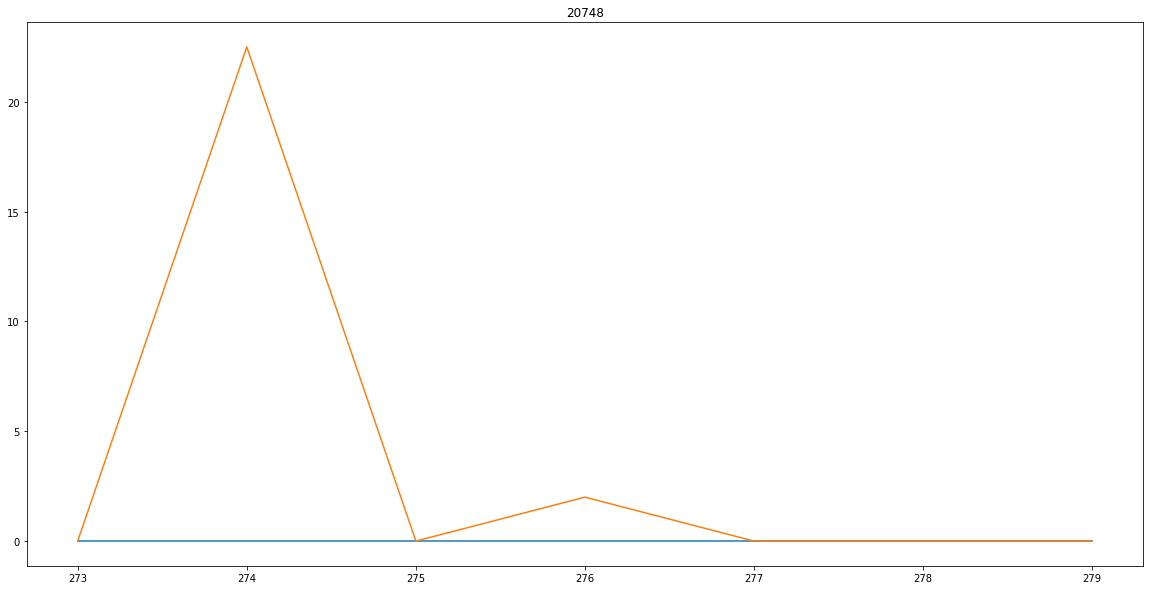

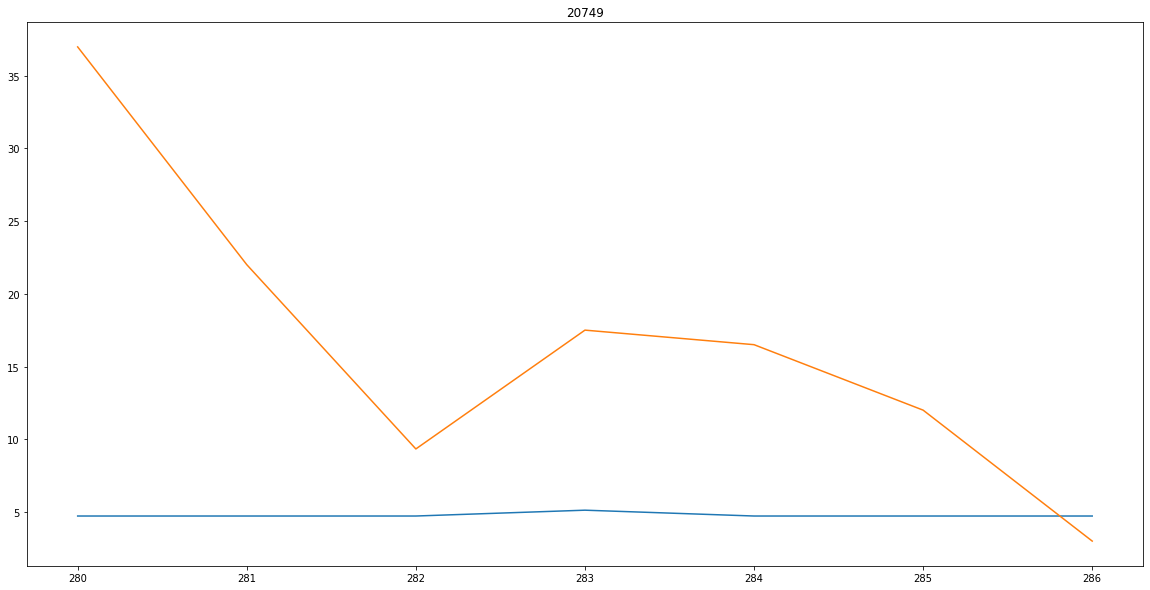

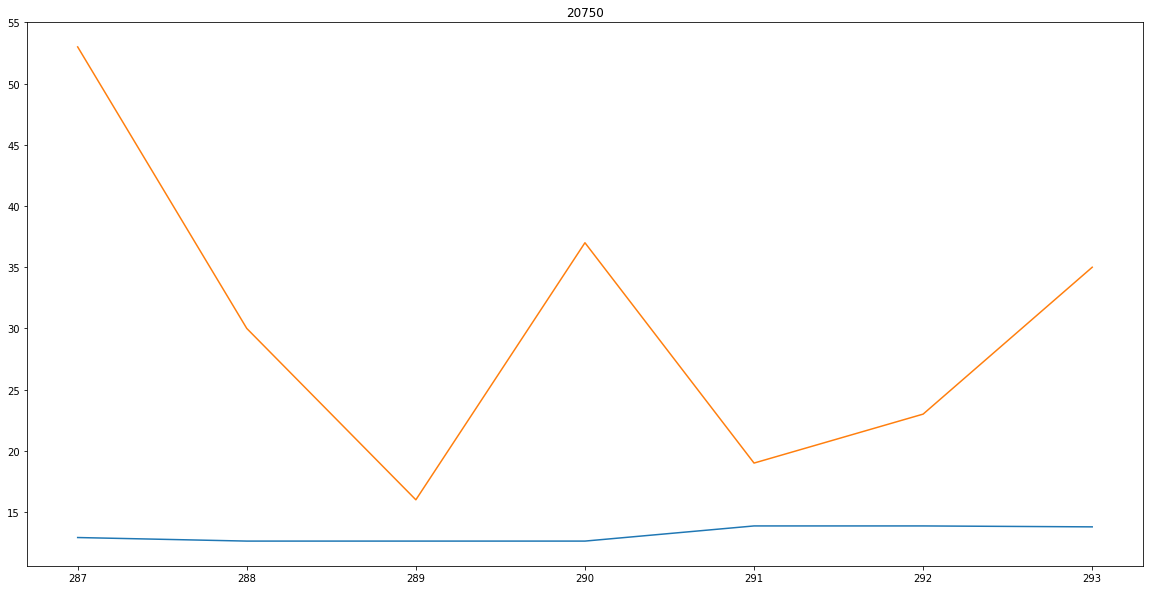

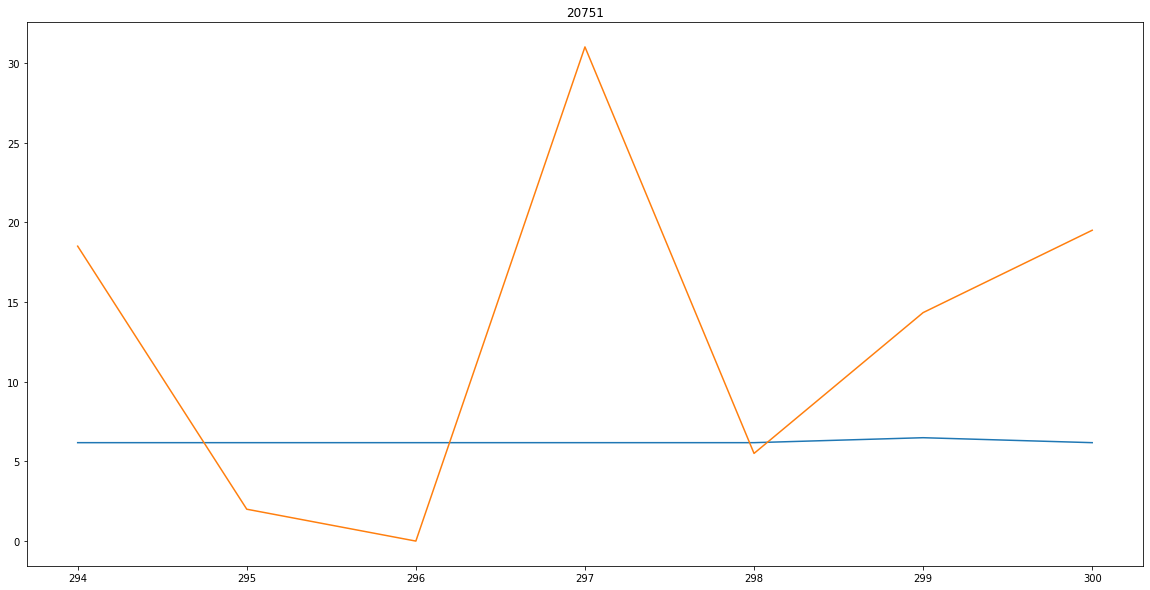

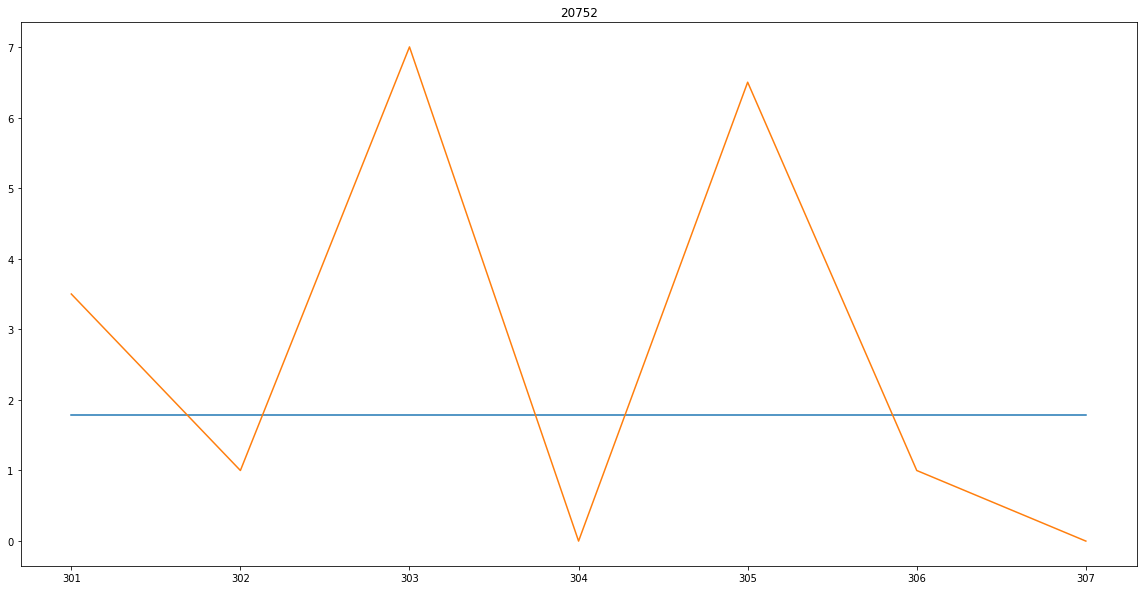

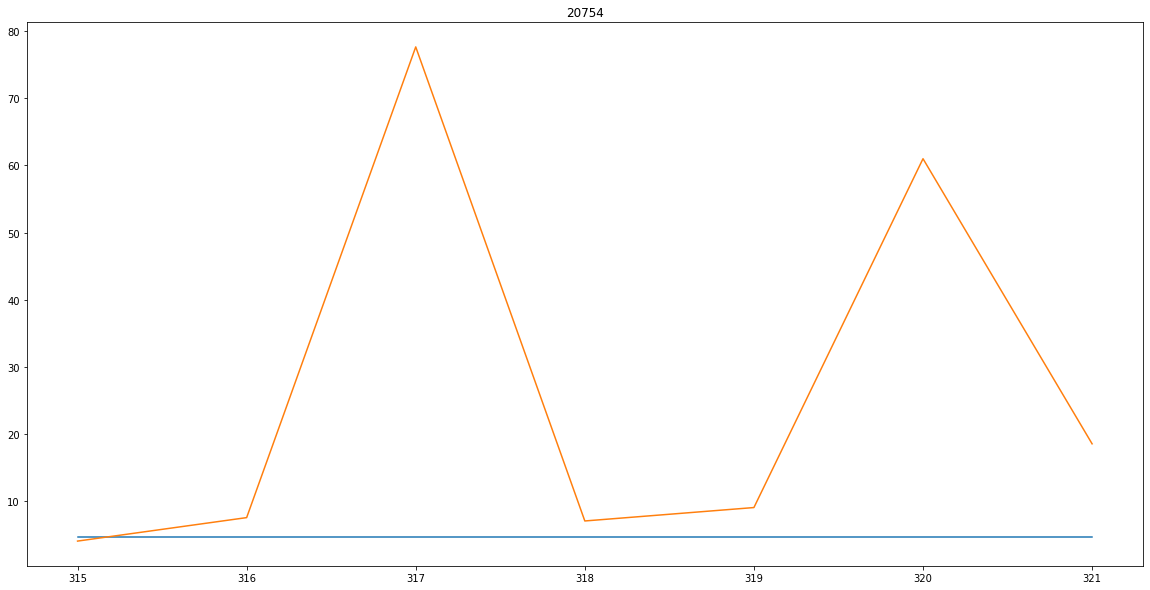

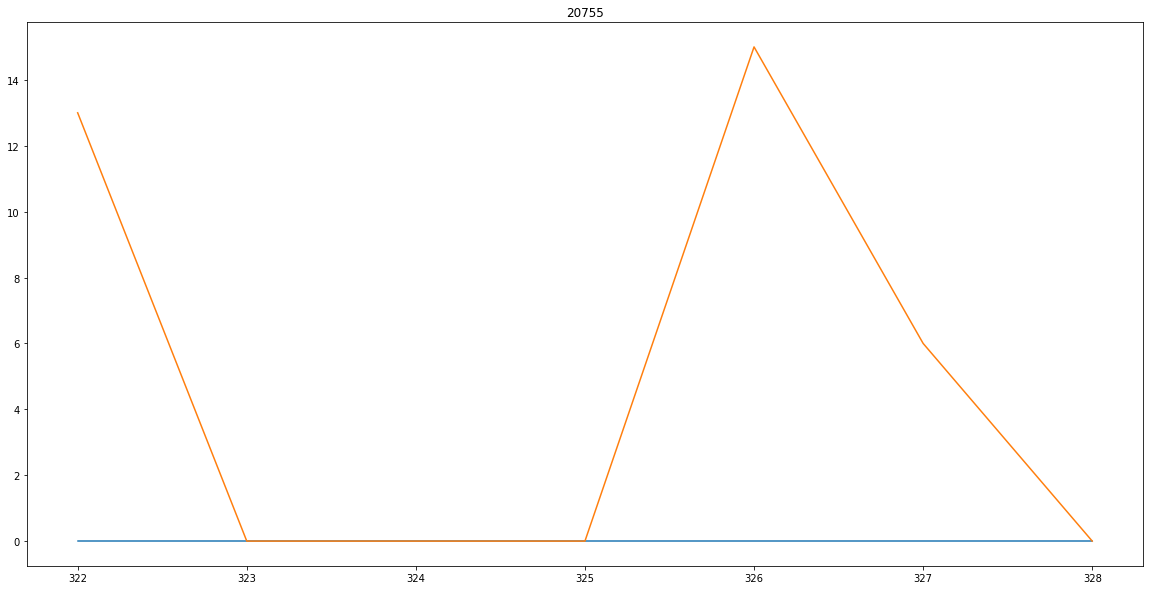

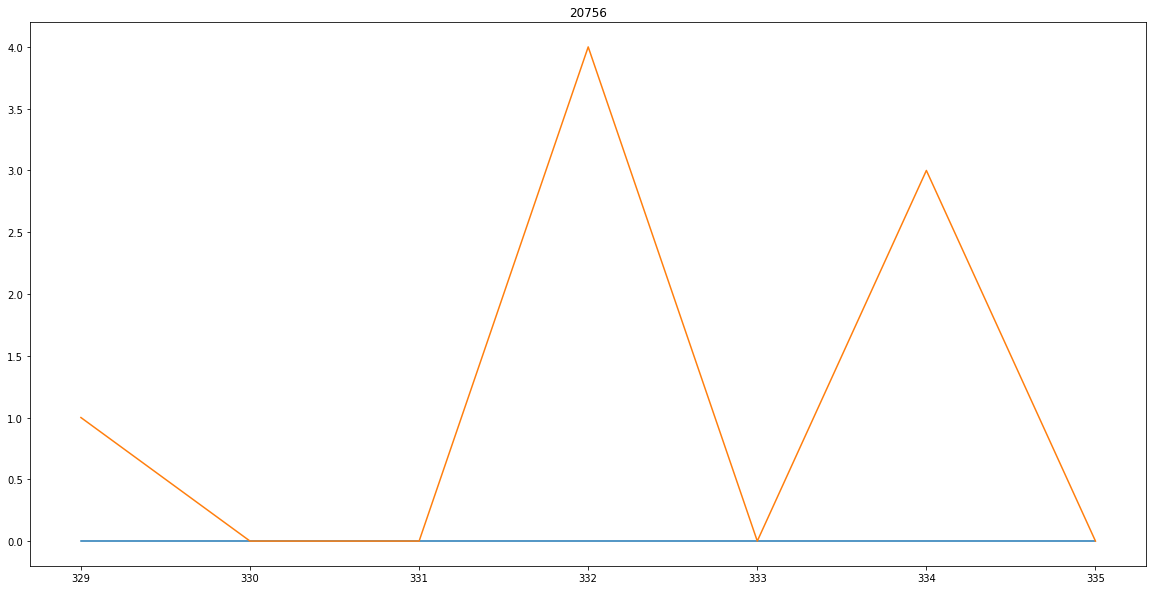

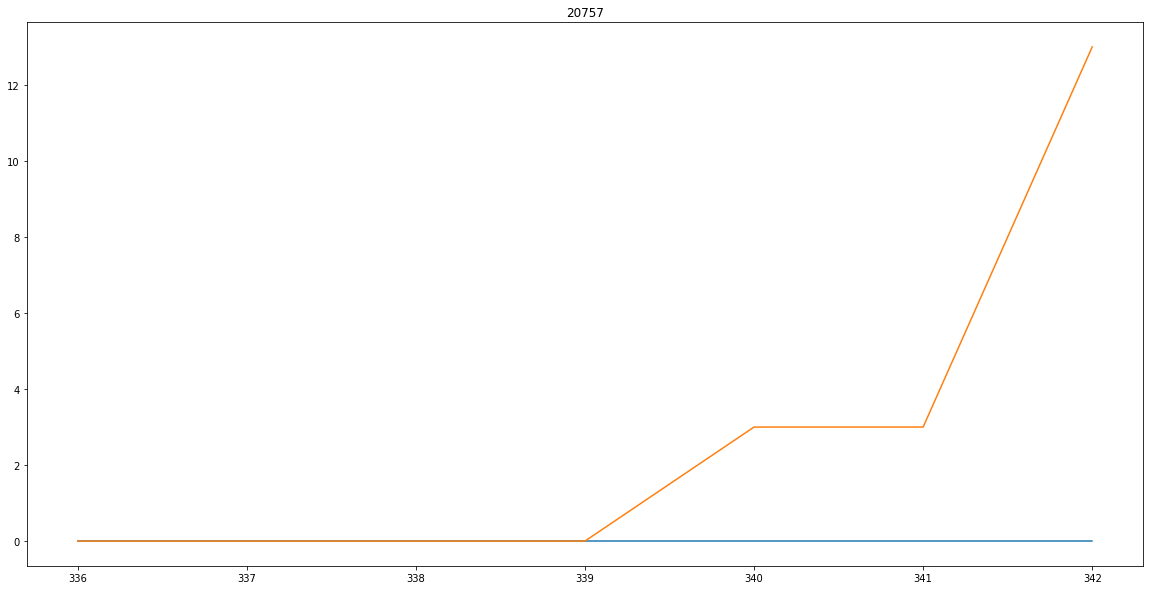

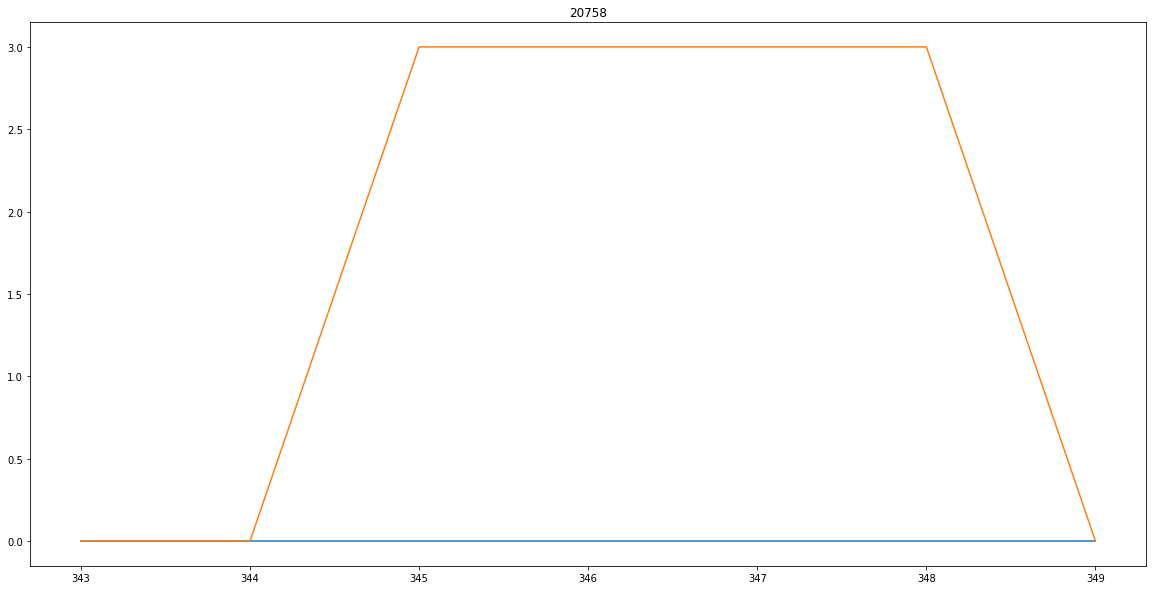

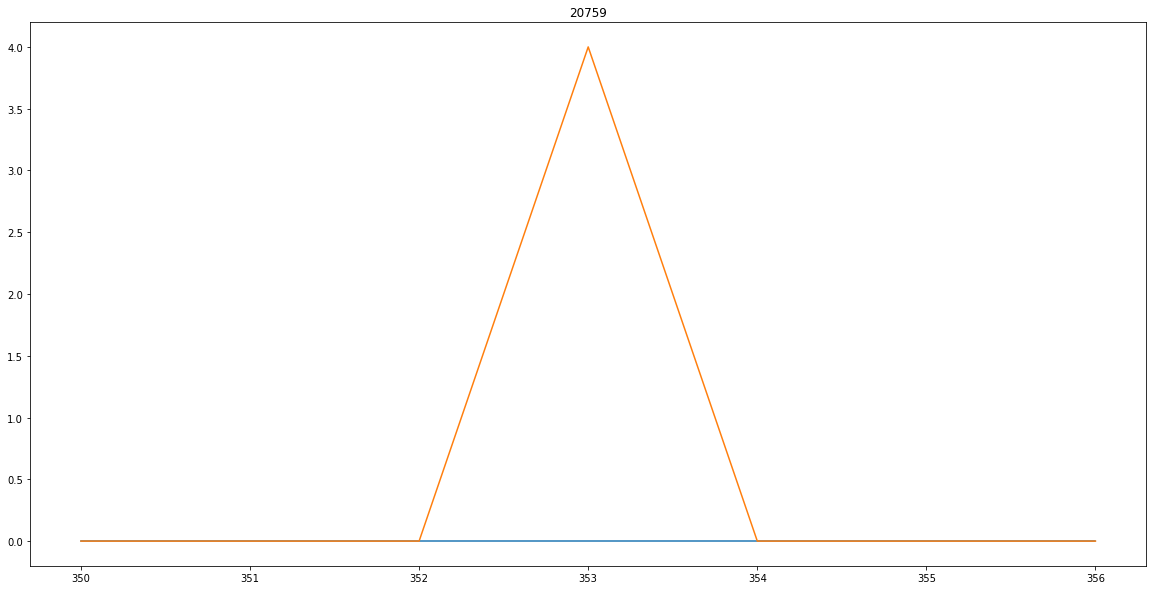

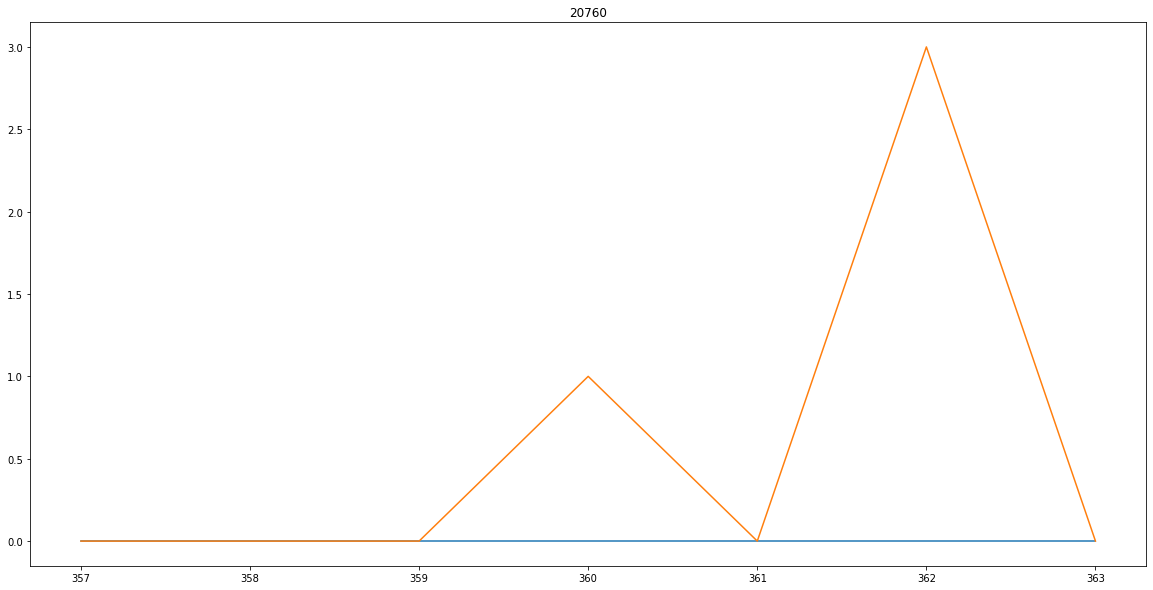

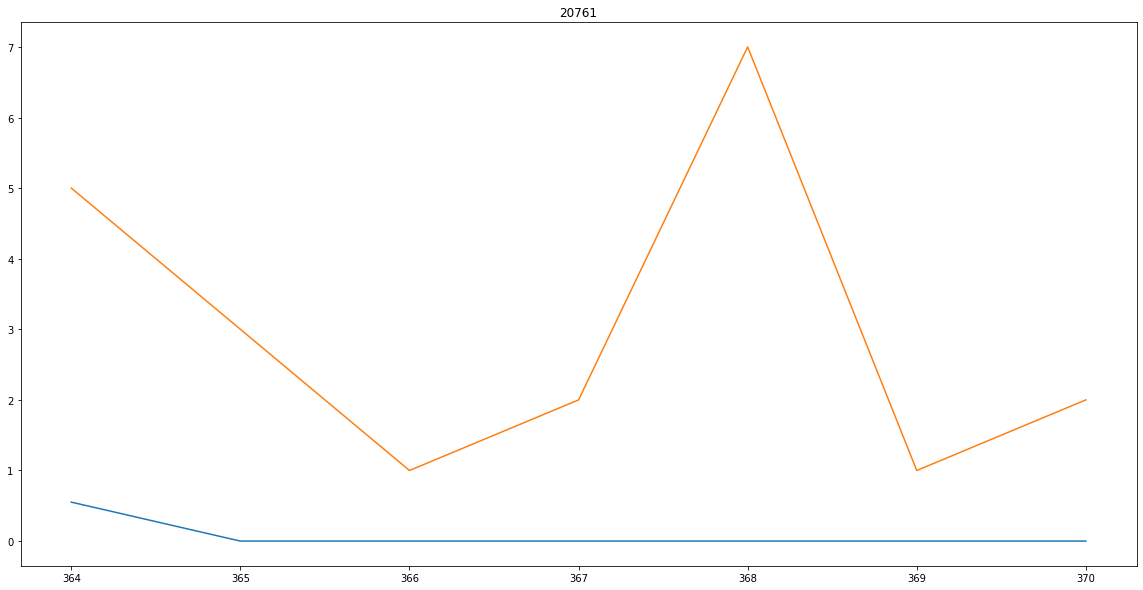

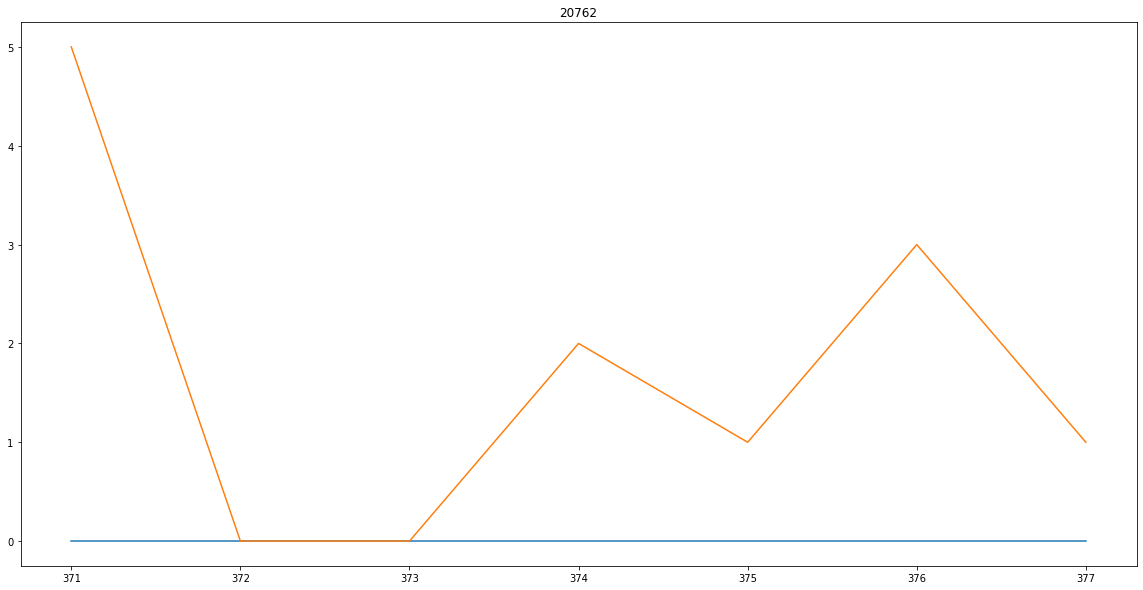

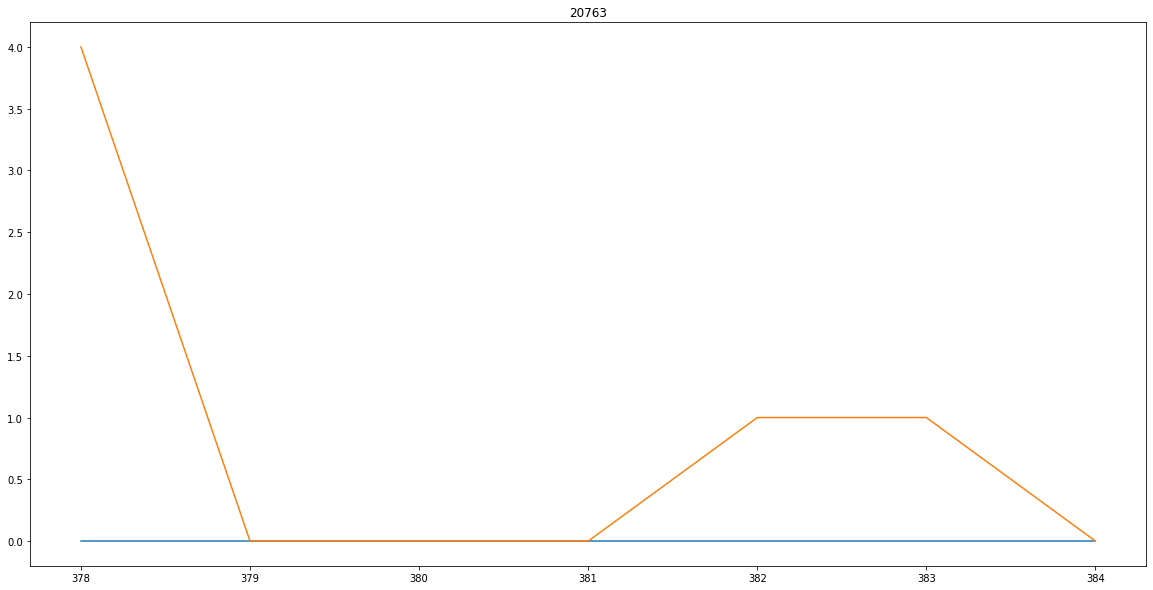

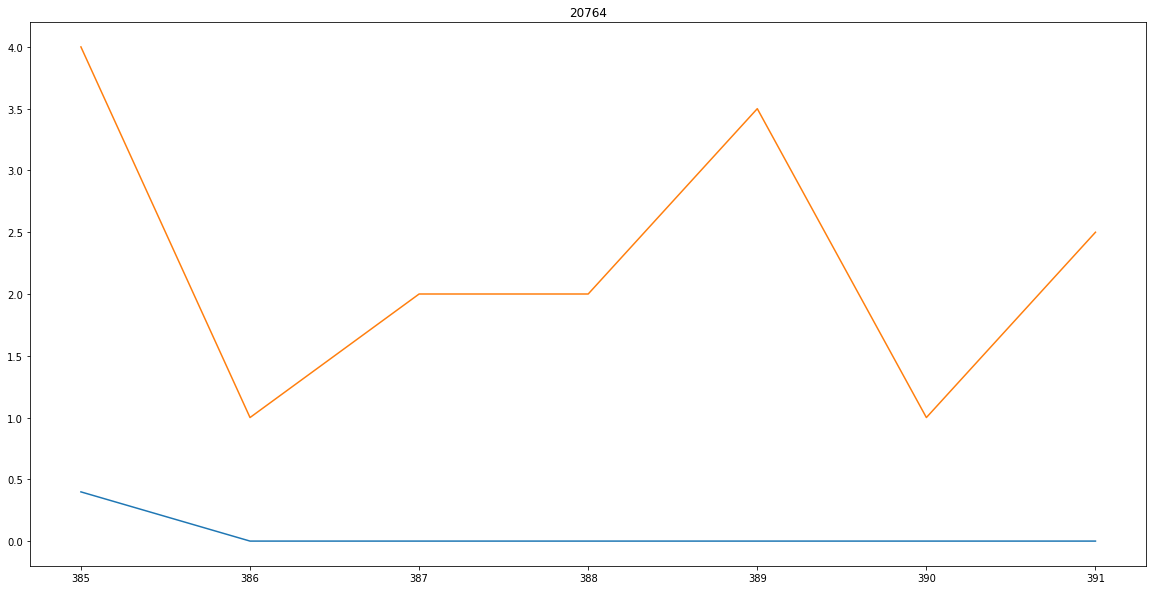

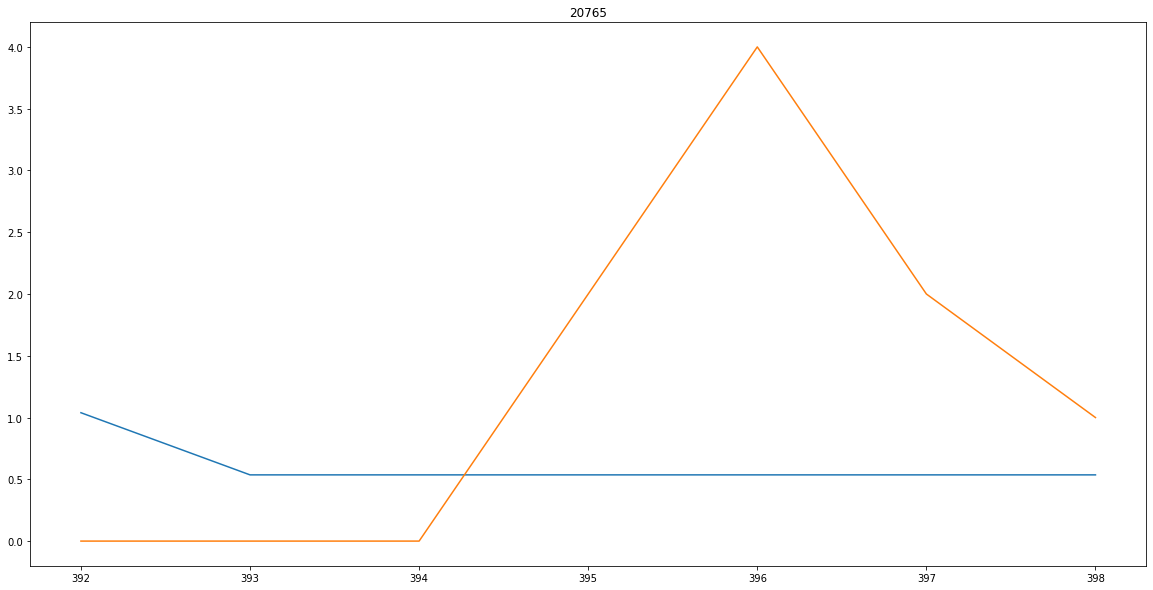

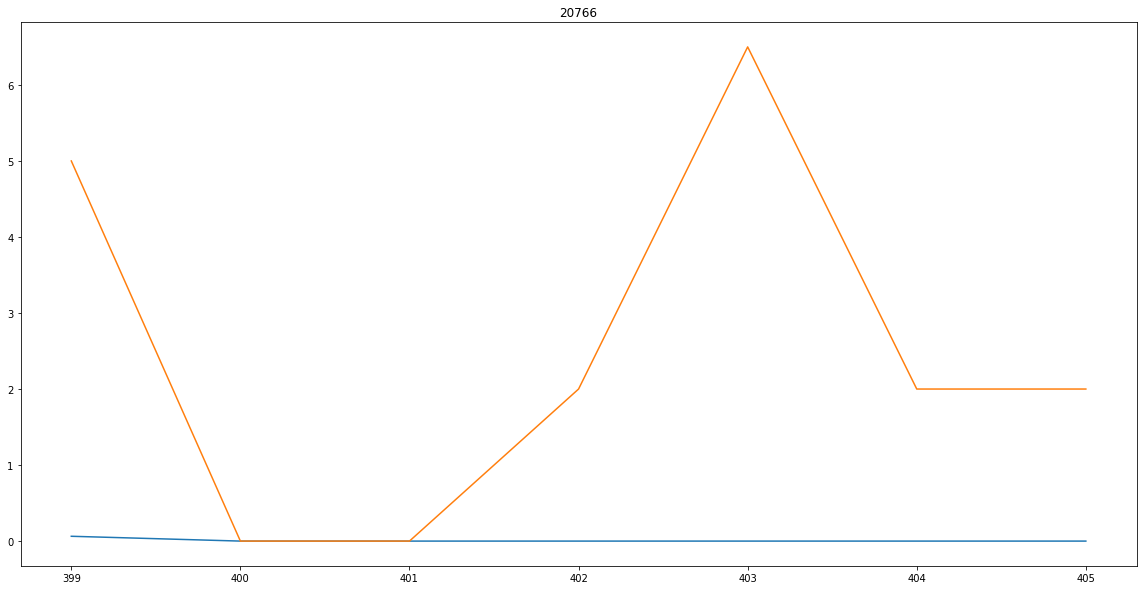

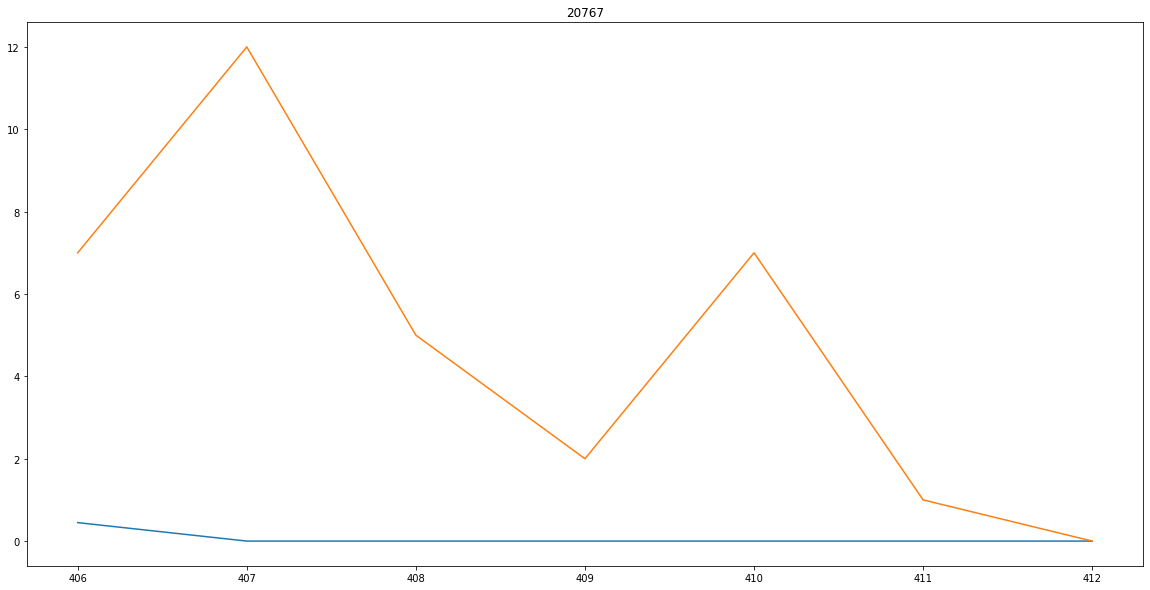

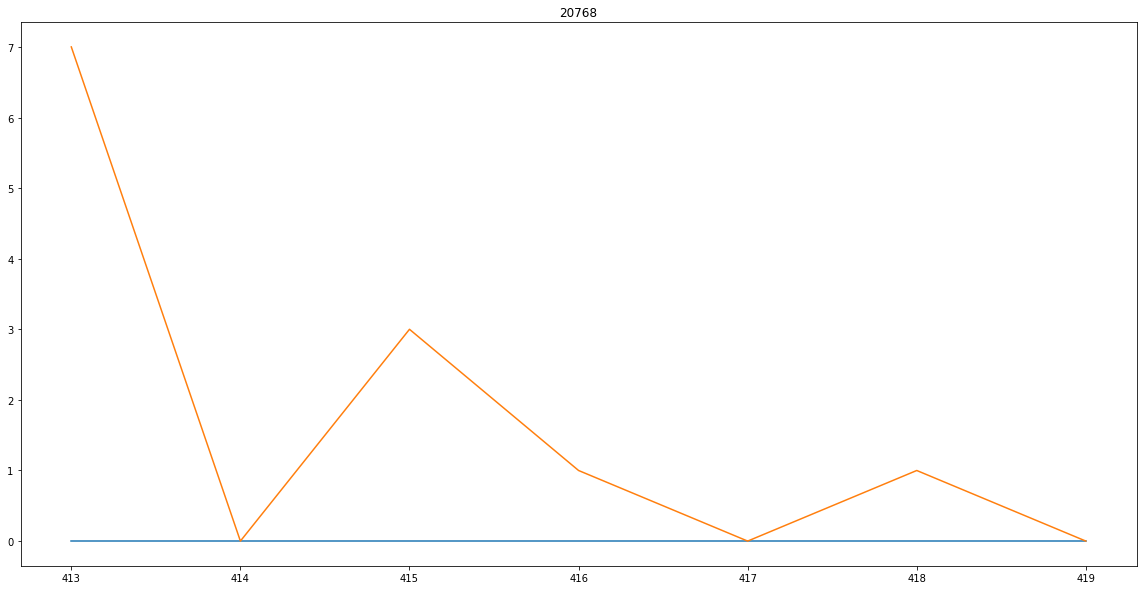

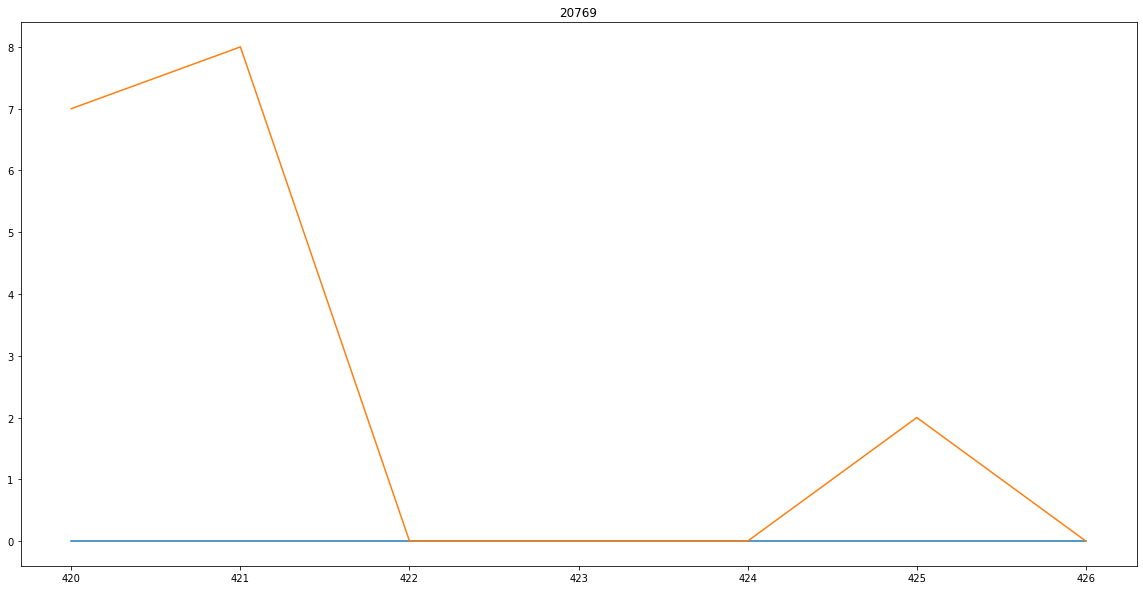

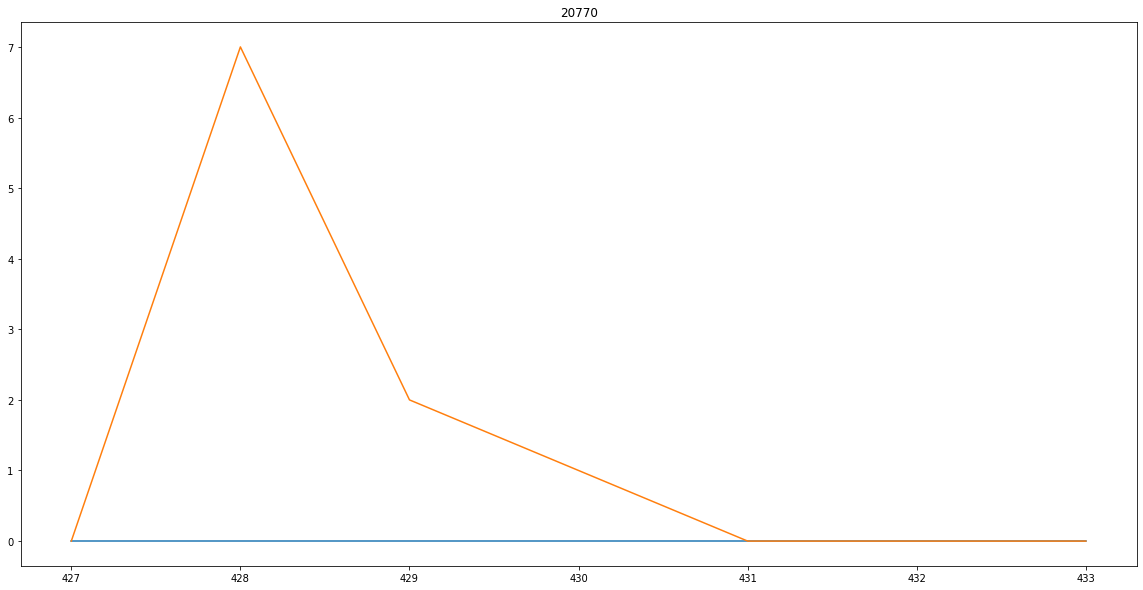

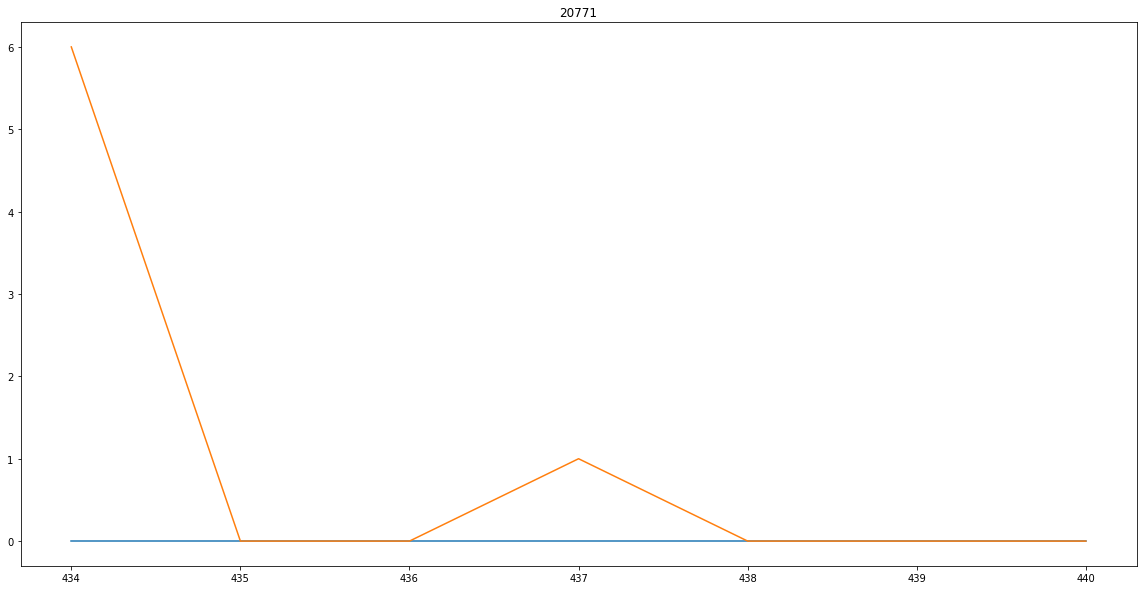

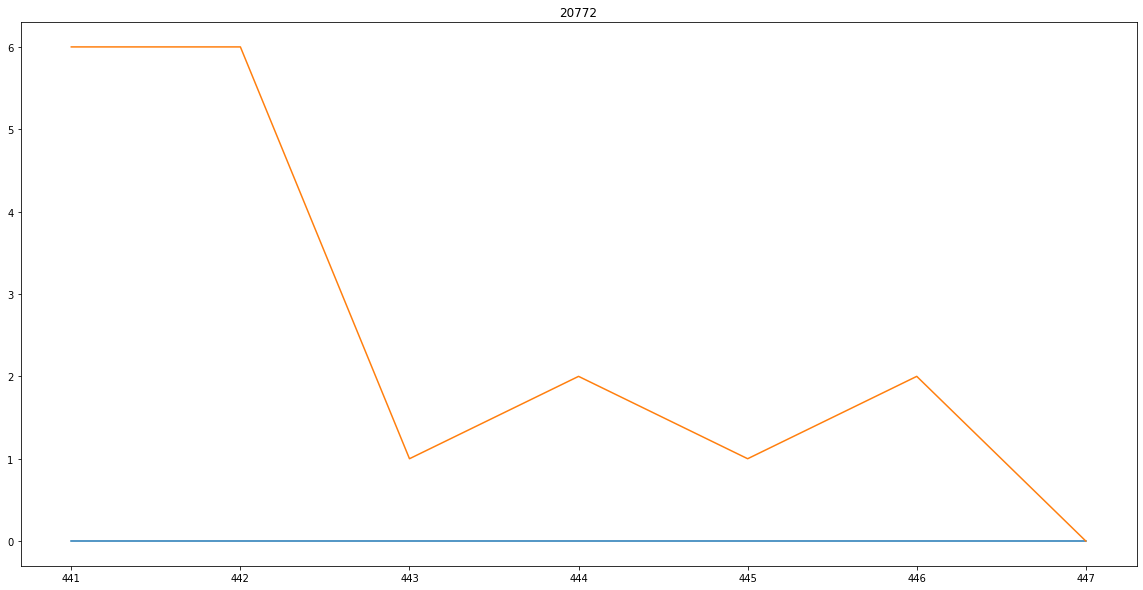

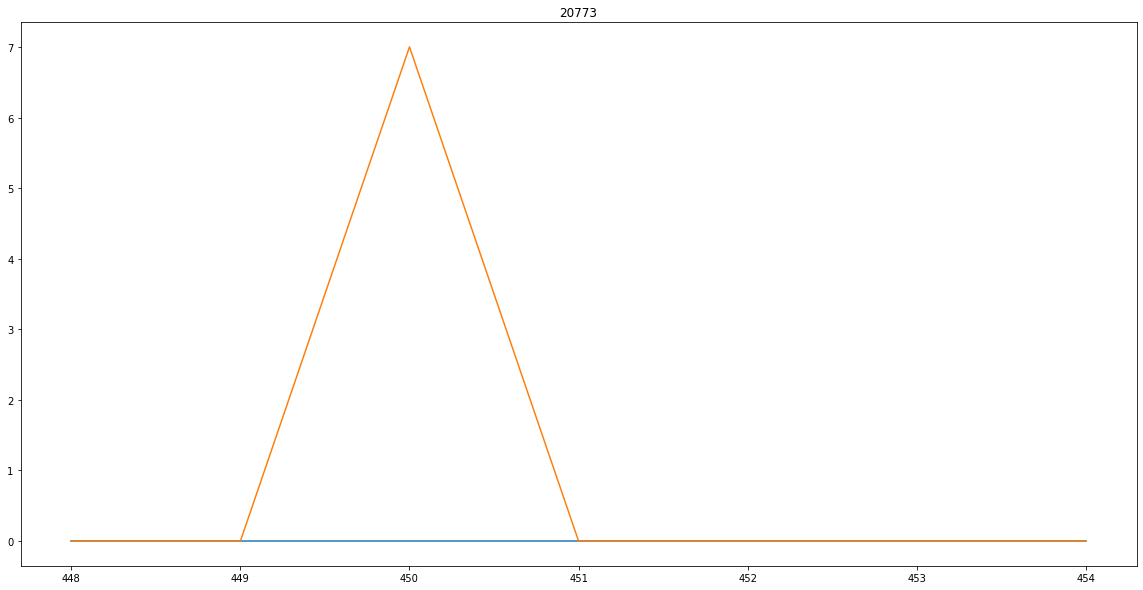

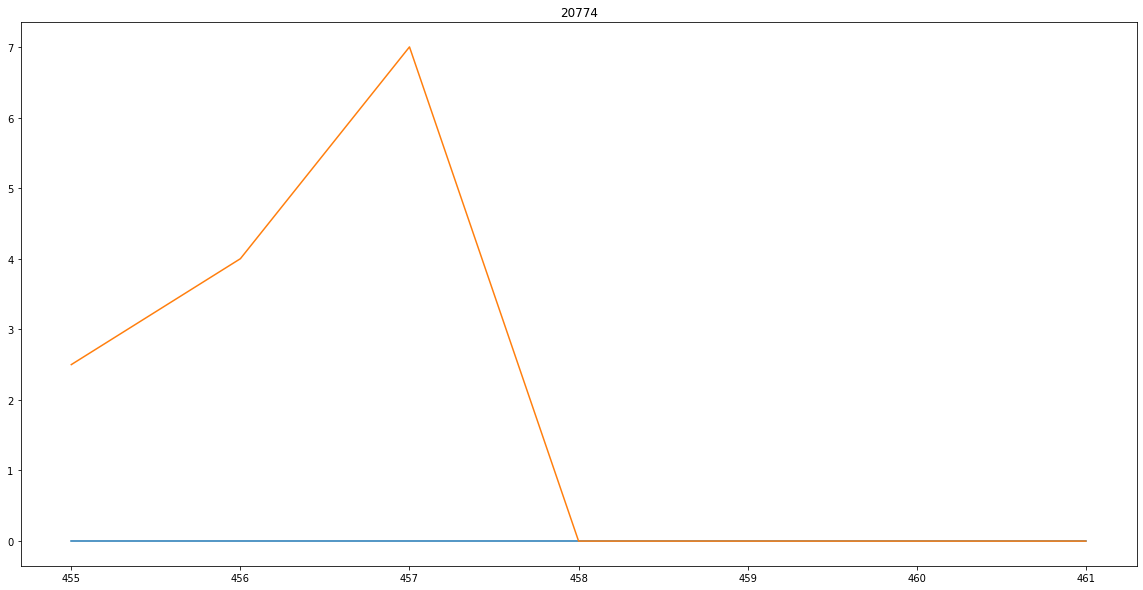

In [87]:
for i in t3['StockCode'].head(60).tolist():
  fig, ax = plt.subplots(figsize=(20,10))
  test1.loc[test1['StockCode']==i,'lforecast'].plot(ax=ax,title=i)
  test1.loc[test1['StockCode']==i,'Quantity'].plot(ax=ax,title=i)

# Forecast

In [93]:
lgb_train = lgb.Dataset(train_f,train_fy,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_f, val_fy, reference=lgb_train)


In [94]:
tuned_model = LightGBMTuner(params, train_set=lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=300,
                                     early_stopping_rounds=30,
                                    )

[I 2021-02-22 15:59:55,510] A new study created in memory with name: no-name-8cb7d22a-81a1-413f-81fe-e2eee077e14f


In [95]:
tuned_model.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['cluster', 'id_cat', 'month', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's mape: 0.426056
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429907
[3]	valid_0's mape: 0.417996
[4]	valid_0's mape: 0.413527
[5]	valid_0's mape: 0.402657
[6]	valid_0's mape: 0.399077
[7]	valid_0's mape: 0.396555
[8]	valid_0's mape: 0.386185
[9]	valid_0's mape: 0.383297
[10]	valid_0's mape: 0.383191
[11]	valid_0's mape: 0.383643
[12]	valid_0's mape: 0.381424
[13]	valid_0's mape: 0.380193
[14]	valid_0's mape: 0.373896
[15]	valid_0's mape: 0.368618
[16]	valid_0's mape: 0.363545
[17]	valid_0's mape: 0.359816
[18]	valid_0's mape: 0.356869
[19]	valid_0's mape: 0.354195
[20]	valid_0's mape: 0.352053
[21]	valid_0's mape: 0.351632
[22]	valid_0's mape: 0.350482
[23]	valid_0's mape: 0.349886
[24]	valid_0's mape: 0.346716
[25]	valid_0's mape: 0.344428
[26]	valid_0's mape: 0.34284
[27]	valid_0's mape: 0.342095
[28]	valid_0's mape: 0.340736
[29]	valid_0's mape: 0.340334
[30]	valid_0's mape: 0.340339
[31]	valid_0's mape: 0.338755
[32]	valid_0's map

feature_fraction, val_score: 0.336050:  14%|#4        | 1/7 [00:02<00:12,  2.10s/it]

[65]	valid_0's mape: 0.338017
[66]	valid_0's mape: 0.33821
[67]	valid_0's mape: 0.338028
[68]	valid_0's mape: 0.337936
[69]	valid_0's mape: 0.337698
[70]	valid_0's mape: 0.337755
[71]	valid_0's mape: 0.337391
Early stopping, best iteration is:
[41]	valid_0's mape: 0.33605
[1]	valid_0's mape: 0.426599
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428886
[3]	valid_0's mape: 0.41541
[4]	valid_0's mape: 0.403681
[5]	valid_0's mape: 0.394279
[6]	valid_0's mape: 0.390144
[7]	valid_0's mape: 0.382007
[8]	valid_0's mape: 0.376131
[9]	valid_0's mape: 0.37579
[10]	valid_0's mape: 0.370453
[11]	valid_0's mape: 0.366547
[12]	valid_0's mape: 0.362609
[13]	valid_0's mape: 0.361723
[14]	valid_0's mape: 0.358829
[15]	valid_0's mape: 0.356846
[16]	valid_0's mape: 0.353374
[17]	valid_0's mape: 0.351975
[18]	valid_0's mape: 0.351277
[19]	valid_0's mape: 0.350873
[20]	valid_0's mape: 0.35005
[21]	valid_0's mape: 0.347976
[22]	valid_0's mape: 0.347156
[23]	valid_0's ma

feature_fraction, val_score: 0.336050:  29%|##8       | 2/7 [00:05<00:13,  2.60s/it]

[153]	valid_0's mape: 0.341211
Early stopping, best iteration is:
[123]	valid_0's mape: 0.33941
[1]	valid_0's mape: 0.425896
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.412316
[3]	valid_0's mape: 0.401093
[4]	valid_0's mape: 0.392018
[5]	valid_0's mape: 0.383071
[6]	valid_0's mape: 0.376387
[7]	valid_0's mape: 0.370467
[8]	valid_0's mape: 0.366694
[9]	valid_0's mape: 0.362621
[10]	valid_0's mape: 0.358422
[11]	valid_0's mape: 0.355137
[12]	valid_0's mape: 0.353124
[13]	valid_0's mape: 0.351526
[14]	valid_0's mape: 0.350531
[15]	valid_0's mape: 0.349673
[16]	valid_0's mape: 0.348251
[17]	valid_0's mape: 0.346385
[18]	valid_0's mape: 0.345834
[19]	valid_0's mape: 0.344929
[20]	valid_0's mape: 0.344685
[21]	valid_0's mape: 0.344939
[22]	valid_0's mape: 0.344446
[23]	valid_0's mape: 0.343742
[24]	valid_0's mape: 0.343514
[25]	valid_0's mape: 0.343762
[26]	valid_0's mape: 0.344339
[27]	valid_0's mape: 0.344112
[28]	valid_0's mape: 0.343522
[29]	valid_

feature_fraction, val_score: 0.336050:  43%|####2     | 3/7 [00:11<00:13,  3.47s/it]

[213]	valid_0's mape: 0.337904
[214]	valid_0's mape: 0.337895
Early stopping, best iteration is:
[184]	valid_0's mape: 0.337524
[1]	valid_0's mape: 0.427133
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.412936
[3]	valid_0's mape: 0.421324
[4]	valid_0's mape: 0.429156
[5]	valid_0's mape: 0.435426
[6]	valid_0's mape: 0.437759
[7]	valid_0's mape: 0.428344
[8]	valid_0's mape: 0.427395
[9]	valid_0's mape: 0.425842
[10]	valid_0's mape: 0.421719
[11]	valid_0's mape: 0.41544
[12]	valid_0's mape: 0.411966
[13]	valid_0's mape: 0.405819
[14]	valid_0's mape: 0.403333
[15]	valid_0's mape: 0.40257
[16]	valid_0's mape: 0.396197
[17]	valid_0's mape: 0.395614
[18]	valid_0's mape: 0.391437
[19]	valid_0's mape: 0.392526
[20]	valid_0's mape: 0.392222
[21]	valid_0's mape: 0.392097
[22]	valid_0's mape: 0.390218
[23]	valid_0's mape: 0.389937
[24]	valid_0's mape: 0.388252
[25]	valid_0's mape: 0.38849
[26]	valid_0's mape: 0.387186
[27]	valid_0's mape: 0.384667
[28]	valid_0

feature_fraction, val_score: 0.336050:  57%|#####7    | 4/7 [00:14<00:10,  3.50s/it]

[157]	valid_0's mape: 0.352095
[158]	valid_0's mape: 0.351981
[159]	valid_0's mape: 0.352036
[160]	valid_0's mape: 0.351841
[161]	valid_0's mape: 0.352012
[162]	valid_0's mape: 0.352047
[163]	valid_0's mape: 0.352033
[164]	valid_0's mape: 0.352056
[165]	valid_0's mape: 0.352056
[166]	valid_0's mape: 0.351816
[167]	valid_0's mape: 0.351917
[168]	valid_0's mape: 0.351952
Early stopping, best iteration is:
[138]	valid_0's mape: 0.351037
[1]	valid_0's mape: 0.425896
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428424
[3]	valid_0's mape: 0.415346
[4]	valid_0's mape: 0.4054
[5]	valid_0's mape: 0.397277
[6]	valid_0's mape: 0.393241
[7]	valid_0's mape: 0.386031
[8]	valid_0's mape: 0.379743
[9]	valid_0's mape: 0.374098
[10]	valid_0's mape: 0.369019
[11]	valid_0's mape: 0.363758
[12]	valid_0's mape: 0.360073
[13]	valid_0's mape: 0.358579
[14]	valid_0's mape: 0.355765
[15]	valid_0's mape: 0.353501
[16]	valid_0's mape: 0.350549
[17]	valid_0's mape: 0.34892
[1

feature_fraction, val_score: 0.336050:  71%|#######1  | 5/7 [00:33<00:15,  7.98s/it]

[1]	valid_0's mape: 0.426929
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.431003
[3]	valid_0's mape: 0.416551
[4]	valid_0's mape: 0.412907
[5]	valid_0's mape: 0.418591
[6]	valid_0's mape: 0.415829
[7]	valid_0's mape: 0.419363
[8]	valid_0's mape: 0.409163
[9]	valid_0's mape: 0.406327
[10]	valid_0's mape: 0.404432
[11]	valid_0's mape: 0.403745
[12]	valid_0's mape: 0.401587
[13]	valid_0's mape: 0.399337
[14]	valid_0's mape: 0.391861
[15]	valid_0's mape: 0.385906
[16]	valid_0's mape: 0.380585
[17]	valid_0's mape: 0.376404
[18]	valid_0's mape: 0.373803
[19]	valid_0's mape: 0.370374
[20]	valid_0's mape: 0.36855
[21]	valid_0's mape: 0.368122
[22]	valid_0's mape: 0.364957
[23]	valid_0's mape: 0.361095
[24]	valid_0's mape: 0.359814
[25]	valid_0's mape: 0.357286
[26]	valid_0's mape: 0.354632
[27]	valid_0's mape: 0.353962
[28]	valid_0's mape: 0.352075
[29]	valid_0's mape: 0.350158
[30]	valid_0's mape: 0.349885
[31]	valid_0's mape: 0.349087
[32]	valid_0's map

feature_fraction, val_score: 0.336050:  86%|########5 | 6/7 [00:37<00:06,  6.75s/it]

[193]	valid_0's mape: 0.340506
[194]	valid_0's mape: 0.340495
[195]	valid_0's mape: 0.340535
[196]	valid_0's mape: 0.340613
[197]	valid_0's mape: 0.340496
[198]	valid_0's mape: 0.340469
[199]	valid_0's mape: 0.340461
[200]	valid_0's mape: 0.340446
[201]	valid_0's mape: 0.34034
[202]	valid_0's mape: 0.340338
[203]	valid_0's mape: 0.340338
[204]	valid_0's mape: 0.340362
[205]	valid_0's mape: 0.340324
[206]	valid_0's mape: 0.340313
[207]	valid_0's mape: 0.340307
Early stopping, best iteration is:
[177]	valid_0's mape: 0.340265
[1]	valid_0's mape: 0.426599
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428886
[3]	valid_0's mape: 0.417317
[4]	valid_0's mape: 0.420941
[5]	valid_0's mape: 0.409938
[6]	valid_0's mape: 0.406476
[7]	valid_0's mape: 0.402206
[8]	valid_0's mape: 0.393442
[9]	valid_0's mape: 0.390235
[10]	valid_0's mape: 0.390196
[11]	valid_0's mape: 0.390241
[12]	valid_0's mape: 0.387351
[13]	valid_0's mape: 0.386136
[14]	valid_0's mape: 0.3798

num_leaves, val_score: 0.336050:   0%|          | 0/20 [00:00<?, ?it/s]

[75]	valid_0's mape: 0.346328
[76]	valid_0's mape: 0.346182
[77]	valid_0's mape: 0.346058
[78]	valid_0's mape: 0.346067
[79]	valid_0's mape: 0.34598
[80]	valid_0's mape: 0.345935
[81]	valid_0's mape: 0.346081
Early stopping, best iteration is:
[51]	valid_0's mape: 0.345515
[1]	valid_0's mape: 0.425333
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.425321
[3]	valid_0's mape: 0.413513
[4]	valid_0's mape: 0.409169
[5]	valid_0's mape: 0.397838
[6]	valid_0's mape: 0.393901
[7]	valid_0's mape: 0.396545
[8]	valid_0's mape: 0.387951
[9]	valid_0's mape: 0.385105
[10]	valid_0's mape: 0.382858
[11]	valid_0's mape: 0.383821
[12]	valid_0's mape: 0.382012
[13]	valid_0's mape: 0.380194
[14]	valid_0's mape: 0.37319
[15]	valid_0's mape: 0.3682
[16]	valid_0's mape: 0.363279
[17]	valid_0's mape: 0.359913
[18]	valid_0's mape: 0.356502
[19]	valid_0's mape: 0.354124
[20]	valid_0's mape: 0.352568
[21]	valid_0's mape: 0.353487
[22]	valid_0's mape: 0.351709
[23]	valid_0's m

num_leaves, val_score: 0.336050:   5%|5         | 1/20 [00:04<01:17,  4.07s/it]

[75]	valid_0's mape: 0.343678
[76]	valid_0's mape: 0.343657
[77]	valid_0's mape: 0.343665
[78]	valid_0's mape: 0.343732
[79]	valid_0's mape: 0.343647
Early stopping, best iteration is:
[49]	valid_0's mape: 0.34145
[1]	valid_0's mape: 0.425696
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427379
[3]	valid_0's mape: 0.415449
[4]	valid_0's mape: 0.411245
[5]	valid_0's mape: 0.399299
[6]	valid_0's mape: 0.39531
[7]	valid_0's mape: 0.397943
[8]	valid_0's mape: 0.389467
[9]	valid_0's mape: 0.386701
[10]	valid_0's mape: 0.384423
[11]	valid_0's mape: 0.384857
[12]	valid_0's mape: 0.382861
[13]	valid_0's mape: 0.380929
[14]	valid_0's mape: 0.374096
[15]	valid_0's mape: 0.369341
[16]	valid_0's mape: 0.36422
[17]	valid_0's mape: 0.361203
[18]	valid_0's mape: 0.357852
[19]	valid_0's mape: 0.355161
[20]	valid_0's mape: 0.353403
[21]	valid_0's mape: 0.354457
[22]	valid_0's mape: 0.352042
[23]	valid_0's mape: 0.351633
[24]	valid_0's mape: 0.349528
[25]	valid_0's 

num_leaves, val_score: 0.336050:  10%|#         | 2/20 [00:07<01:10,  3.94s/it]

[77]	valid_0's mape: 0.344232
[78]	valid_0's mape: 0.344507
[79]	valid_0's mape: 0.344555
[80]	valid_0's mape: 0.34459
[81]	valid_0's mape: 0.344794
Early stopping, best iteration is:
[51]	valid_0's mape: 0.342246
[1]	valid_0's mape: 0.426024
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429763
[3]	valid_0's mape: 0.417809
[4]	valid_0's mape: 0.41404
[5]	valid_0's mape: 0.403207
[6]	valid_0's mape: 0.401264
[7]	valid_0's mape: 0.398738
[8]	valid_0's mape: 0.389584
[9]	valid_0's mape: 0.386367
[10]	valid_0's mape: 0.384981
[11]	valid_0's mape: 0.384752
[12]	valid_0's mape: 0.383
[13]	valid_0's mape: 0.381733
[14]	valid_0's mape: 0.375258
[15]	valid_0's mape: 0.369907
[16]	valid_0's mape: 0.364822
[17]	valid_0's mape: 0.361403
[18]	valid_0's mape: 0.358344
[19]	valid_0's mape: 0.35572
[20]	valid_0's mape: 0.354255
[21]	valid_0's mape: 0.354914
[22]	valid_0's mape: 0.353006
[23]	valid_0's mape: 0.35258
[24]	valid_0's mape: 0.348942
[25]	valid_0's mape

num_leaves, val_score: 0.336050:  15%|#5        | 3/20 [00:10<00:59,  3.48s/it]

[85]	valid_0's mape: 0.337154
[86]	valid_0's mape: 0.337227
Early stopping, best iteration is:
[56]	valid_0's mape: 0.336476
[1]	valid_0's mape: 0.425757
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427425
[3]	valid_0's mape: 0.414267
[4]	valid_0's mape: 0.409931
[5]	valid_0's mape: 0.399017
[6]	valid_0's mape: 0.394985
[7]	valid_0's mape: 0.397509
[8]	valid_0's mape: 0.389321
[9]	valid_0's mape: 0.386547
[10]	valid_0's mape: 0.3859
[11]	valid_0's mape: 0.387302
[12]	valid_0's mape: 0.385698
[13]	valid_0's mape: 0.384155
[14]	valid_0's mape: 0.377417
[15]	valid_0's mape: 0.372357
[16]	valid_0's mape: 0.367324
[17]	valid_0's mape: 0.364327
[18]	valid_0's mape: 0.360813
[19]	valid_0's mape: 0.35823
[20]	valid_0's mape: 0.356777
[21]	valid_0's mape: 0.357288
[22]	valid_0's mape: 0.356133
[23]	valid_0's mape: 0.355297
[24]	valid_0's mape: 0.353229
[25]	valid_0's mape: 0.351394
[26]	valid_0's mape: 0.349276
[27]	valid_0's mape: 0.349816
[28]	valid_0's 

num_leaves, val_score: 0.336050:  20%|##        | 4/20 [00:13<00:55,  3.48s/it]

[77]	valid_0's mape: 0.343329
[78]	valid_0's mape: 0.343113
[79]	valid_0's mape: 0.343205
[80]	valid_0's mape: 0.343236
[81]	valid_0's mape: 0.34327
[82]	valid_0's mape: 0.342901
Early stopping, best iteration is:
[52]	valid_0's mape: 0.341439
[1]	valid_0's mape: 0.425236
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.425244
[3]	valid_0's mape: 0.412039
[4]	valid_0's mape: 0.407741
[5]	valid_0's mape: 0.396193
[6]	valid_0's mape: 0.392119
[7]	valid_0's mape: 0.396962
[8]	valid_0's mape: 0.388521
[9]	valid_0's mape: 0.38557
[10]	valid_0's mape: 0.383649
[11]	valid_0's mape: 0.385287
[12]	valid_0's mape: 0.383885
[13]	valid_0's mape: 0.382543
[14]	valid_0's mape: 0.375749
[15]	valid_0's mape: 0.370707
[16]	valid_0's mape: 0.365966
[17]	valid_0's mape: 0.362149
[18]	valid_0's mape: 0.358593
[19]	valid_0's mape: 0.356059
[20]	valid_0's mape: 0.354338
[21]	valid_0's mape: 0.355431
[22]	valid_0's mape: 0.353201
[23]	valid_0's mape: 0.351973
[24]	valid_0's

num_leaves, val_score: 0.336050:  25%|##5       | 5/20 [00:18<00:57,  3.85s/it]

[85]	valid_0's mape: 0.344624
[86]	valid_0's mape: 0.344591
Early stopping, best iteration is:
[56]	valid_0's mape: 0.342085
[1]	valid_0's mape: 0.425395
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.425395
[3]	valid_0's mape: 0.412169
[4]	valid_0's mape: 0.407851
[5]	valid_0's mape: 0.396394
[6]	valid_0's mape: 0.392773
[7]	valid_0's mape: 0.397247
[8]	valid_0's mape: 0.38866
[9]	valid_0's mape: 0.385553
[10]	valid_0's mape: 0.383544
[11]	valid_0's mape: 0.384913
[12]	valid_0's mape: 0.382528
[13]	valid_0's mape: 0.380936
[14]	valid_0's mape: 0.374135
[15]	valid_0's mape: 0.369494
[16]	valid_0's mape: 0.36487
[17]	valid_0's mape: 0.361305
[18]	valid_0's mape: 0.357733
[19]	valid_0's mape: 0.355199
[20]	valid_0's mape: 0.353378
[21]	valid_0's mape: 0.353446
[22]	valid_0's mape: 0.351289
[23]	valid_0's mape: 0.350358
[24]	valid_0's mape: 0.348021
[25]	valid_0's mape: 0.346534
[26]	valid_0's mape: 0.345278
[27]	valid_0's mape: 0.346427
[28]	valid_0's

num_leaves, val_score: 0.336050:  30%|###       | 6/20 [00:23<00:58,  4.15s/it]

[81]	valid_0's mape: 0.343666
Early stopping, best iteration is:
[51]	valid_0's mape: 0.341061
[1]	valid_0's mape: 0.425969
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42947
[3]	valid_0's mape: 0.41671
[4]	valid_0's mape: 0.412005
[5]	valid_0's mape: 0.401109
[6]	valid_0's mape: 0.39887
[7]	valid_0's mape: 0.397982
[8]	valid_0's mape: 0.388524
[9]	valid_0's mape: 0.385358
[10]	valid_0's mape: 0.382912
[11]	valid_0's mape: 0.383052
[12]	valid_0's mape: 0.381026
[13]	valid_0's mape: 0.377686
[14]	valid_0's mape: 0.371469
[15]	valid_0's mape: 0.366845
[16]	valid_0's mape: 0.361776
[17]	valid_0's mape: 0.35831
[18]	valid_0's mape: 0.353902
[19]	valid_0's mape: 0.351365
[20]	valid_0's mape: 0.349907
[21]	valid_0's mape: 0.349592
[22]	valid_0's mape: 0.348493
[23]	valid_0's mape: 0.348208
[24]	valid_0's mape: 0.345224
[25]	valid_0's mape: 0.34358
[26]	valid_0's mape: 0.342409
[27]	valid_0's mape: 0.342327
[28]	valid_0's mape: 0.341276
[29]	valid_0's ma

num_leaves, val_score: 0.336050:  35%|###5      | 7/20 [00:25<00:47,  3.66s/it]

[72]	valid_0's mape: 0.339216
[73]	valid_0's mape: 0.339077
[74]	valid_0's mape: 0.339015
[75]	valid_0's mape: 0.339045
[76]	valid_0's mape: 0.338611
[77]	valid_0's mape: 0.338532
[78]	valid_0's mape: 0.338315
Early stopping, best iteration is:
[48]	valid_0's mape: 0.337327
[1]	valid_0's mape: 0.425446
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.426168
[3]	valid_0's mape: 0.414248
[4]	valid_0's mape: 0.410225
[5]	valid_0's mape: 0.398552
[6]	valid_0's mape: 0.394534
[7]	valid_0's mape: 0.397385
[8]	valid_0's mape: 0.38936
[9]	valid_0's mape: 0.386585
[10]	valid_0's mape: 0.384742
[11]	valid_0's mape: 0.385796
[12]	valid_0's mape: 0.383782
[13]	valid_0's mape: 0.382234
[14]	valid_0's mape: 0.375263
[15]	valid_0's mape: 0.370532
[16]	valid_0's mape: 0.365484
[17]	valid_0's mape: 0.362893
[18]	valid_0's mape: 0.359497
[19]	valid_0's mape: 0.356776
[20]	valid_0's mape: 0.355176
[21]	valid_0's mape: 0.356223
[22]	valid_0's mape: 0.354189
[23]	valid_0'

num_leaves, val_score: 0.336050:  40%|####      | 8/20 [00:29<00:44,  3.72s/it]

[1]	valid_0's mape: 0.425757
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427417
[3]	valid_0's mape: 0.414313
[4]	valid_0's mape: 0.41006
[5]	valid_0's mape: 0.399076
[6]	valid_0's mape: 0.395044
[7]	valid_0's mape: 0.397473
[8]	valid_0's mape: 0.388797
[9]	valid_0's mape: 0.386047
[10]	valid_0's mape: 0.385503
[11]	valid_0's mape: 0.386879
[12]	valid_0's mape: 0.384615
[13]	valid_0's mape: 0.382968
[14]	valid_0's mape: 0.376055
[15]	valid_0's mape: 0.371037
[16]	valid_0's mape: 0.365953
[17]	valid_0's mape: 0.362522
[18]	valid_0's mape: 0.35917
[19]	valid_0's mape: 0.356771
[20]	valid_0's mape: 0.355186
[21]	valid_0's mape: 0.355656
[22]	valid_0's mape: 0.353284
[23]	valid_0's mape: 0.35244
[24]	valid_0's mape: 0.349629
[25]	valid_0's mape: 0.348674
[26]	valid_0's mape: 0.346554
[27]	valid_0's mape: 0.346172
[28]	valid_0's mape: 0.345578
[29]	valid_0's mape: 0.345451
[30]	valid_0's mape: 0.345764
[31]	valid_0's mape: 0.344727
[32]	valid_0's mape:

num_leaves, val_score: 0.336050:  45%|####5     | 9/20 [00:32<00:39,  3.61s/it]

[75]	valid_0's mape: 0.342208
[76]	valid_0's mape: 0.341845
[77]	valid_0's mape: 0.341794
[78]	valid_0's mape: 0.341782
[79]	valid_0's mape: 0.341857
Early stopping, best iteration is:
[49]	valid_0's mape: 0.341094
[1]	valid_0's mape: 0.425366
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424948
[3]	valid_0's mape: 0.411635
[4]	valid_0's mape: 0.407128
[5]	valid_0's mape: 0.395564
[6]	valid_0's mape: 0.391493
[7]	valid_0's mape: 0.396015
[8]	valid_0's mape: 0.387728
[9]	valid_0's mape: 0.384615
[10]	valid_0's mape: 0.381955
[11]	valid_0's mape: 0.383801
[12]	valid_0's mape: 0.382198
[13]	valid_0's mape: 0.381203
[14]	valid_0's mape: 0.37404
[15]	valid_0's mape: 0.368866
[16]	valid_0's mape: 0.364109
[17]	valid_0's mape: 0.360105
[18]	valid_0's mape: 0.356376
[19]	valid_0's mape: 0.353853
[20]	valid_0's mape: 0.352485
[21]	valid_0's mape: 0.35291
[22]	valid_0's mape: 0.350904
[23]	valid_0's mape: 0.350056
[24]	valid_0's mape: 0.348352
[25]	valid_0's

num_leaves, val_score: 0.336050:  50%|#####     | 10/20 [00:38<00:40,  4.08s/it]

[85]	valid_0's mape: 0.34283
[86]	valid_0's mape: 0.342972
[87]	valid_0's mape: 0.342915
Early stopping, best iteration is:
[57]	valid_0's mape: 0.339696
[1]	valid_0's mape: 0.427187
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.43143
[3]	valid_0's mape: 0.419327
[4]	valid_0's mape: 0.417506
[5]	valid_0's mape: 0.406258
[6]	valid_0's mape: 0.403911
[7]	valid_0's mape: 0.401583
[8]	valid_0's mape: 0.392626
[9]	valid_0's mape: 0.389392
[10]	valid_0's mape: 0.389379
[11]	valid_0's mape: 0.3892
[12]	valid_0's mape: 0.388115
[13]	valid_0's mape: 0.386445
[14]	valid_0's mape: 0.378201
[15]	valid_0's mape: 0.37277
[16]	valid_0's mape: 0.367404
[17]	valid_0's mape: 0.364189
[18]	valid_0's mape: 0.360583
[19]	valid_0's mape: 0.3578
[20]	valid_0's mape: 0.35627
[21]	valid_0's mape: 0.357111
[22]	valid_0's mape: 0.355703
[23]	valid_0's mape: 0.353313
[24]	valid_0's mape: 0.351386
[25]	valid_0's mape: 0.350617
[26]	valid_0's mape: 0.350209
[27]	valid_0's mape:

num_leaves, val_score: 0.336050:  55%|#####5    | 11/20 [00:40<00:32,  3.56s/it]

[136]	valid_0's mape: 0.341293
[137]	valid_0's mape: 0.341204
[138]	valid_0's mape: 0.341195
Early stopping, best iteration is:
[108]	valid_0's mape: 0.340232
[1]	valid_0's mape: 0.427507
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.43707
[3]	valid_0's mape: 0.423919
[4]	valid_0's mape: 0.423959
[5]	valid_0's mape: 0.411507
[6]	valid_0's mape: 0.418723
[7]	valid_0's mape: 0.416691
[8]	valid_0's mape: 0.406332
[9]	valid_0's mape: 0.403437
[10]	valid_0's mape: 0.40366
[11]	valid_0's mape: 0.408227
[12]	valid_0's mape: 0.409833
[13]	valid_0's mape: 0.410505
[14]	valid_0's mape: 0.402779
[15]	valid_0's mape: 0.396275
[16]	valid_0's mape: 0.390944
[17]	valid_0's mape: 0.386896
[18]	valid_0's mape: 0.383534
[19]	valid_0's mape: 0.380614
[20]	valid_0's mape: 0.378748
[21]	valid_0's mape: 0.378446
[22]	valid_0's mape: 0.378809
[23]	valid_0's mape: 0.377598
[24]	valid_0's mape: 0.378688
[25]	valid_0's mape: 0.378188
[26]	valid_0's mape: 0.377571
[27]	valid

num_leaves, val_score: 0.336050:  60%|######    | 12/20 [00:43<00:26,  3.35s/it]


[270]	valid_0's mape: 0.360903
[271]	valid_0's mape: 0.360906
[272]	valid_0's mape: 0.360937
[273]	valid_0's mape: 0.360957
[274]	valid_0's mape: 0.360989
[275]	valid_0's mape: 0.361024
[276]	valid_0's mape: 0.361046
[277]	valid_0's mape: 0.361062
[278]	valid_0's mape: 0.360864
[279]	valid_0's mape: 0.360898
[280]	valid_0's mape: 0.360728
[281]	valid_0's mape: 0.360766
[282]	valid_0's mape: 0.360776
[283]	valid_0's mape: 0.360805
[284]	valid_0's mape: 0.36072
[285]	valid_0's mape: 0.360826
[286]	valid_0's mape: 0.360839
[287]	valid_0's mape: 0.360859
[288]	valid_0's mape: 0.360855
Early stopping, best iteration is:
[258]	valid_0's mape: 0.359827
[1]	valid_0's mape: 0.425847
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429369
[3]	valid_0's mape: 0.416539
[4]	valid_0's mape: 0.412316
[5]	valid_0's mape: 0.401486
[6]	valid_0's mape: 0.397086
[7]	valid_0's mape: 0.401075
[8]	valid_0's mape: 0.391644
[9]	valid_0's mape: 0.388841
[10]	valid_0's mape: 0

num_leaves, val_score: 0.336050:  65%|######5   | 13/20 [00:46<00:22,  3.17s/it]

[79]	valid_0's mape: 0.340191
[80]	valid_0's mape: 0.34022
[81]	valid_0's mape: 0.340295
[82]	valid_0's mape: 0.340126
[83]	valid_0's mape: 0.340173
[84]	valid_0's mape: 0.340087
[85]	valid_0's mape: 0.339978
[86]	valid_0's mape: 0.339793
Early stopping, best iteration is:
[56]	valid_0's mape: 0.339366
[1]	valid_0's mape: 0.425847
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429369
[3]	valid_0's mape: 0.416539
[4]	valid_0's mape: 0.412316
[5]	valid_0's mape: 0.401486
[6]	valid_0's mape: 0.397086
[7]	valid_0's mape: 0.401075
[8]	valid_0's mape: 0.391644
[9]	valid_0's mape: 0.388841
[10]	valid_0's mape: 0.38737
[11]	valid_0's mape: 0.388069
[12]	valid_0's mape: 0.386311
[13]	valid_0's mape: 0.384612
[14]	valid_0's mape: 0.378112
[15]	valid_0's mape: 0.373272
[16]	valid_0's mape: 0.368028
[17]	valid_0's mape: 0.364888
[18]	valid_0's mape: 0.36264
[19]	valid_0's mape: 0.359909
[20]	valid_0's mape: 0.357995
[21]	valid_0's mape: 0.358942
[22]	valid_0's 

num_leaves, val_score: 0.336050:  70%|#######   | 14/20 [00:48<00:18,  3.05s/it]

[80]	valid_0's mape: 0.34022
[81]	valid_0's mape: 0.340295
[82]	valid_0's mape: 0.340126
[83]	valid_0's mape: 0.340173
[84]	valid_0's mape: 0.340087
[85]	valid_0's mape: 0.339978
[86]	valid_0's mape: 0.339793
Early stopping, best iteration is:
[56]	valid_0's mape: 0.339366
[1]	valid_0's mape: 0.426155
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429588
[3]	valid_0's mape: 0.416751
[4]	valid_0's mape: 0.412052
[5]	valid_0's mape: 0.401056
[6]	valid_0's mape: 0.398408
[7]	valid_0's mape: 0.394201
[8]	valid_0's mape: 0.384626
[9]	valid_0's mape: 0.38154
[10]	valid_0's mape: 0.379033
[11]	valid_0's mape: 0.379305
[12]	valid_0's mape: 0.377657
[13]	valid_0's mape: 0.375927
[14]	valid_0's mape: 0.369529
[15]	valid_0's mape: 0.364529
[16]	valid_0's mape: 0.359418
[17]	valid_0's mape: 0.355883
[18]	valid_0's mape: 0.352152
[19]	valid_0's mape: 0.349123
[20]	valid_0's mape: 0.347389
[21]	valid_0's mape: 0.347631
[22]	valid_0's mape: 0.345964
[23]	valid_0's

num_leaves, val_score: 0.334437:  75%|#######5  | 15/20 [00:51<00:14,  2.83s/it]

[66]	valid_0's mape: 0.336357
[67]	valid_0's mape: 0.336098
[68]	valid_0's mape: 0.336016
[69]	valid_0's mape: 0.336081
[70]	valid_0's mape: 0.336081
[71]	valid_0's mape: 0.336556
Early stopping, best iteration is:
[41]	valid_0's mape: 0.334437
[1]	valid_0's mape: 0.426602
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.43013
[3]	valid_0's mape: 0.418637
[4]	valid_0's mape: 0.415797
[5]	valid_0's mape: 0.405247
[6]	valid_0's mape: 0.403531
[7]	valid_0's mape: 0.401142
[8]	valid_0's mape: 0.392235
[9]	valid_0's mape: 0.389147
[10]	valid_0's mape: 0.389176
[11]	valid_0's mape: 0.388534
[12]	valid_0's mape: 0.386498
[13]	valid_0's mape: 0.384936
[14]	valid_0's mape: 0.378305
[15]	valid_0's mape: 0.372713
[16]	valid_0's mape: 0.368134
[17]	valid_0's mape: 0.364489
[18]	valid_0's mape: 0.360762
[19]	valid_0's mape: 0.357871
[20]	valid_0's mape: 0.356314
[21]	valid_0's mape: 0.356638
[22]	valid_0's mape: 0.35581
[23]	valid_0's mape: 0.354671
[24]	valid_0's

num_leaves, val_score: 0.334437:  80%|########  | 16/20 [00:53<00:10,  2.64s/it]

[86]	valid_0's mape: 0.342946
[87]	valid_0's mape: 0.343014
Early stopping, best iteration is:
[57]	valid_0's mape: 0.341947
[1]	valid_0's mape: 0.425311
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424706
[3]	valid_0's mape: 0.411411
[4]	valid_0's mape: 0.406569
[5]	valid_0's mape: 0.394704
[6]	valid_0's mape: 0.390724
[7]	valid_0's mape: 0.394569
[8]	valid_0's mape: 0.386137
[9]	valid_0's mape: 0.382885
[10]	valid_0's mape: 0.380511
[11]	valid_0's mape: 0.382657
[12]	valid_0's mape: 0.380877
[13]	valid_0's mape: 0.379576
[14]	valid_0's mape: 0.372674
[15]	valid_0's mape: 0.368121
[16]	valid_0's mape: 0.363456
[17]	valid_0's mape: 0.35917
[18]	valid_0's mape: 0.355391
[19]	valid_0's mape: 0.353217
[20]	valid_0's mape: 0.351188
[21]	valid_0's mape: 0.352268
[22]	valid_0's mape: 0.349938
[23]	valid_0's mape: 0.348671
[24]	valid_0's mape: 0.346826
[25]	valid_0's mape: 0.345679
[26]	valid_0's mape: 0.344295
[27]	valid_0's mape: 0.344777
[28]	valid_0'

num_leaves, val_score: 0.334437:  80%|########  | 16/20 [00:58<00:10,  2.64s/it]

[74]	valid_0's mape: 0.340514
[75]	valid_0's mape: 0.340767
Early stopping, best iteration is:
[45]	valid_0's mape: 0.338603


num_leaves, val_score: 0.334437:  85%|########5 | 17/20 [00:58<00:10,  3.43s/it]

[1]	valid_0's mape: 0.425643
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.427235
[3]	valid_0's mape: 0.41438
[4]	valid_0's mape: 0.410028
[5]	valid_0's mape: 0.39916
[6]	valid_0's mape: 0.396718
[7]	valid_0's mape: 0.40061
[8]	valid_0's mape: 0.391353
[9]	valid_0's mape: 0.388447
[10]	valid_0's mape: 0.389135
[11]	valid_0's mape: 0.389596
[12]	valid_0's mape: 0.387788
[13]	valid_0's mape: 0.38541
[14]	valid_0's mape: 0.378965
[15]	valid_0's mape: 0.373913
[16]	valid_0's mape: 0.368653
[17]	valid_0's mape: 0.36607
[18]	valid_0's mape: 0.361913
[19]	valid_0's mape: 0.3588
[20]	valid_0's mape: 0.357167
[21]	valid_0's mape: 0.357324
[22]	valid_0's mape: 0.355809
[23]	valid_0's mape: 0.355149
[24]	valid_0's mape: 0.35357
[25]	valid_0's mape: 0.3516
[26]	valid_0's mape: 0.350438
[27]	valid_0's mape: 0.350404
[28]	valid_0's mape: 0.347854
[29]	valid_0's mape: 0.347404
[30]	valid_0's mape: 0.347733
[31]	valid_0's mape: 0.346795
[32]	valid_0's mape: 0.3468

num_leaves, val_score: 0.334437:  90%|######### | 18/20 [01:03<00:07,  3.86s/it]

[1]	valid_0's mape: 0.425615
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.4272
[3]	valid_0's mape: 0.414326
[4]	valid_0's mape: 0.40994
[5]	valid_0's mape: 0.398639
[6]	valid_0's mape: 0.395624
[7]	valid_0's mape: 0.398362
[8]	valid_0's mape: 0.389094
[9]	valid_0's mape: 0.386198
[10]	valid_0's mape: 0.384948
[11]	valid_0's mape: 0.385883
[12]	valid_0's mape: 0.384319
[13]	valid_0's mape: 0.382288
[14]	valid_0's mape: 0.375367
[15]	valid_0's mape: 0.370693
[16]	valid_0's mape: 0.365506
[17]	valid_0's mape: 0.362372
[18]	valid_0's mape: 0.35917
[19]	valid_0's mape: 0.355928
[20]	valid_0's mape: 0.353902
[21]	valid_0's mape: 0.354251
[22]	valid_0's mape: 0.352548
[23]	valid_0's mape: 0.351909
[24]	valid_0's mape: 0.350105
[25]	valid_0's mape: 0.34784
[26]	valid_0's mape: 0.345736
[27]	valid_0's mape: 0.34565
[28]	valid_0's mape: 0.343218
[29]	valid_0's mape: 0.342508
[30]	valid_0's mape: 0.34231
[31]	valid_0's mape: 0.34121
[32]	valid_0's mape: 0.34

num_leaves, val_score: 0.334437:  95%|#########5| 19/20 [01:06<00:03,  3.51s/it]

[70]	valid_0's mape: 0.339768
[71]	valid_0's mape: 0.34004
Early stopping, best iteration is:
[41]	valid_0's mape: 0.339063
[1]	valid_0's mape: 0.426563
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.430662
[3]	valid_0's mape: 0.418968
[4]	valid_0's mape: 0.414685
[5]	valid_0's mape: 0.404092
[6]	valid_0's mape: 0.401194
[7]	valid_0's mape: 0.398236
[8]	valid_0's mape: 0.389077
[9]	valid_0's mape: 0.386133
[10]	valid_0's mape: 0.385947
[11]	valid_0's mape: 0.385636
[12]	valid_0's mape: 0.383355
[13]	valid_0's mape: 0.382115
[14]	valid_0's mape: 0.376248
[15]	valid_0's mape: 0.370957
[16]	valid_0's mape: 0.366097
[17]	valid_0's mape: 0.362536
[18]	valid_0's mape: 0.35867
[19]	valid_0's mape: 0.356094
[20]	valid_0's mape: 0.354544
[21]	valid_0's mape: 0.355277
[22]	valid_0's mape: 0.354162
[23]	valid_0's mape: 0.353406
[24]	valid_0's mape: 0.350194
[25]	valid_0's mape: 0.348706
[26]	valid_0's mape: 0.346375
[27]	valid_0's mape: 0.345268
[28]	valid_0's

bagging, val_score: 0.334437:   0%|          | 0/10 [00:00<?, ?it/s]

[79]	valid_0's mape: 0.340131
[80]	valid_0's mape: 0.340077
[81]	valid_0's mape: 0.34015
[82]	valid_0's mape: 0.340025
[83]	valid_0's mape: 0.340069
[84]	valid_0's mape: 0.340087
[85]	valid_0's mape: 0.340041
Early stopping, best iteration is:
[55]	valid_0's mape: 0.338921
[1]	valid_0's mape: 0.425617
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.423949
[3]	valid_0's mape: 0.411347
[4]	valid_0's mape: 0.407042
[5]	valid_0's mape: 0.396484
[6]	valid_0's mape: 0.393436
[7]	valid_0's mape: 0.399079
[8]	valid_0's mape: 0.390845
[9]	valid_0's mape: 0.388442
[10]	valid_0's mape: 0.386124
[11]	valid_0's mape: 0.386946
[12]	valid_0's mape: 0.385178
[13]	valid_0's mape: 0.383765
[14]	valid_0's mape: 0.377552
[15]	valid_0's mape: 0.372622
[16]	valid_0's mape: 0.367711
[17]	valid_0's mape: 0.363658
[18]	valid_0's mape: 0.359282
[19]	valid_0's mape: 0.356363
[20]	valid_0's mape: 0.353898
[21]	valid_0's mape: 0.3546
[22]	valid_0's mape: 0.354105
[23]	valid_0's 

bagging, val_score: 0.334437:  10%|#         | 1/10 [00:04<00:43,  4.80s/it]

[1]	valid_0's mape: 0.425152
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.426392
[3]	valid_0's mape: 0.413059
[4]	valid_0's mape: 0.408708
[5]	valid_0's mape: 0.397993
[6]	valid_0's mape: 0.39482
[7]	valid_0's mape: 0.399453
[8]	valid_0's mape: 0.391158
[9]	valid_0's mape: 0.388593
[10]	valid_0's mape: 0.385967
[11]	valid_0's mape: 0.38759
[12]	valid_0's mape: 0.385374
[13]	valid_0's mape: 0.38332
[14]	valid_0's mape: 0.37711
[15]	valid_0's mape: 0.372094
[16]	valid_0's mape: 0.367392
[17]	valid_0's mape: 0.363296
[18]	valid_0's mape: 0.36104
[19]	valid_0's mape: 0.358388
[20]	valid_0's mape: 0.356017
[21]	valid_0's mape: 0.35644
[22]	valid_0's mape: 0.35529
[23]	valid_0's mape: 0.354412
[24]	valid_0's mape: 0.351516
[25]	valid_0's mape: 0.349719
[26]	valid_0's mape: 0.348958
[27]	valid_0's mape: 0.348745
[28]	valid_0's mape: 0.347141
[29]	valid_0's mape: 0.347292
[30]	valid_0's mape: 0.347367
[31]	valid_0's mape: 0.347455
[32]	valid_0's mape: 0.3

bagging, val_score: 0.334437:  20%|##        | 2/10 [00:08<00:35,  4.40s/it]


Early stopping, best iteration is:
[33]	valid_0's mape: 0.34705
[1]	valid_0's mape: 0.425863
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429369
[3]	valid_0's mape: 0.415898
[4]	valid_0's mape: 0.411813
[5]	valid_0's mape: 0.400903
[6]	valid_0's mape: 0.399187
[7]	valid_0's mape: 0.404344
[8]	valid_0's mape: 0.395305
[9]	valid_0's mape: 0.392331
[10]	valid_0's mape: 0.389495
[11]	valid_0's mape: 0.389932
[12]	valid_0's mape: 0.388024
[13]	valid_0's mape: 0.385888
[14]	valid_0's mape: 0.380291
[15]	valid_0's mape: 0.375492
[16]	valid_0's mape: 0.370329
[17]	valid_0's mape: 0.366773
[18]	valid_0's mape: 0.363414
[19]	valid_0's mape: 0.360287
[20]	valid_0's mape: 0.358477
[21]	valid_0's mape: 0.35951
[22]	valid_0's mape: 0.355062
[23]	valid_0's mape: 0.354172
[24]	valid_0's mape: 0.351565
[25]	valid_0's mape: 0.349072
[26]	valid_0's mape: 0.346
[27]	valid_0's mape: 0.34606
[28]	valid_0's mape: 0.343823
[29]	valid_0's mape: 0.34354
[30]	valid_0's map

bagging, val_score: 0.334437:  30%|###       | 3/10 [00:12<00:31,  4.48s/it]

[1]	valid_0's mape: 0.425421
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.423643
[3]	valid_0's mape: 0.411404
[4]	valid_0's mape: 0.406573
[5]	valid_0's mape: 0.395946
[6]	valid_0's mape: 0.393017
[7]	valid_0's mape: 0.394183
[8]	valid_0's mape: 0.385612
[9]	valid_0's mape: 0.383029
[10]	valid_0's mape: 0.381818
[11]	valid_0's mape: 0.382308
[12]	valid_0's mape: 0.380926
[13]	valid_0's mape: 0.379323
[14]	valid_0's mape: 0.373014
[15]	valid_0's mape: 0.368049
[16]	valid_0's mape: 0.363208
[17]	valid_0's mape: 0.359626
[18]	valid_0's mape: 0.35582
[19]	valid_0's mape: 0.353501
[20]	valid_0's mape: 0.351569
[21]	valid_0's mape: 0.35187
[22]	valid_0's mape: 0.350821
[23]	valid_0's mape: 0.35119
[24]	valid_0's mape: 0.350294
[25]	valid_0's mape: 0.349515
[26]	valid_0's mape: 0.347532
[27]	valid_0's mape: 0.346899
[28]	valid_0's mape: 0.346342
[29]	valid_0's mape: 0.346504
[30]	valid_0's mape: 0.346728
[31]	valid_0's mape: 0.346059
[32]	valid_0's mape:

bagging, val_score: 0.334437:  40%|####      | 4/10 [00:17<00:27,  4.50s/it]

[77]	valid_0's mape: 0.349319
Early stopping, best iteration is:
[47]	valid_0's mape: 0.344341
[1]	valid_0's mape: 0.425171
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.423323
[3]	valid_0's mape: 0.410355
[4]	valid_0's mape: 0.406599
[5]	valid_0's mape: 0.395305
[6]	valid_0's mape: 0.393712
[7]	valid_0's mape: 0.397308
[8]	valid_0's mape: 0.387946
[9]	valid_0's mape: 0.385139
[10]	valid_0's mape: 0.383839
[11]	valid_0's mape: 0.384945
[12]	valid_0's mape: 0.382571
[13]	valid_0's mape: 0.380476
[14]	valid_0's mape: 0.373893
[15]	valid_0's mape: 0.368605
[16]	valid_0's mape: 0.363378
[17]	valid_0's mape: 0.360026
[18]	valid_0's mape: 0.355752
[19]	valid_0's mape: 0.353408
[20]	valid_0's mape: 0.351631
[21]	valid_0's mape: 0.35253
[22]	valid_0's mape: 0.350716
[23]	valid_0's mape: 0.350407
[24]	valid_0's mape: 0.348831
[25]	valid_0's mape: 0.347287
[26]	valid_0's mape: 0.345883
[27]	valid_0's mape: 0.346907
[28]	valid_0's mape: 0.346311
[29]	valid_0'

bagging, val_score: 0.334437:  50%|#####     | 5/10 [00:21<00:21,  4.21s/it]

[61]	valid_0's mape: 0.347762
[62]	valid_0's mape: 0.347659
[63]	valid_0's mape: 0.348408
Early stopping, best iteration is:
[33]	valid_0's mape: 0.344744
[1]	valid_0's mape: 0.425518
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.426781
[3]	valid_0's mape: 0.414885
[4]	valid_0's mape: 0.411009
[5]	valid_0's mape: 0.400287
[6]	valid_0's mape: 0.396799
[7]	valid_0's mape: 0.395005
[8]	valid_0's mape: 0.386004
[9]	valid_0's mape: 0.38349
[10]	valid_0's mape: 0.382824
[11]	valid_0's mape: 0.382783
[12]	valid_0's mape: 0.382665
[13]	valid_0's mape: 0.381028
[14]	valid_0's mape: 0.374944
[15]	valid_0's mape: 0.370081
[16]	valid_0's mape: 0.365197
[17]	valid_0's mape: 0.361466
[18]	valid_0's mape: 0.358597
[19]	valid_0's mape: 0.355733
[20]	valid_0's mape: 0.354813
[21]	valid_0's mape: 0.355965
[22]	valid_0's mape: 0.355217
[23]	valid_0's mape: 0.355353
[24]	valid_0's mape: 0.352736
[25]	valid_0's mape: 0.352049
[26]	valid_0's mape: 0.350931
[27]	valid_0'

bagging, val_score: 0.334437:  60%|######    | 6/10 [00:25<00:16,  4.20s/it]

[71]	valid_0's mape: 0.349182
Early stopping, best iteration is:
[41]	valid_0's mape: 0.34407
[1]	valid_0's mape: 0.42601
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424249
[3]	valid_0's mape: 0.410633
[4]	valid_0's mape: 0.406075
[5]	valid_0's mape: 0.395098
[6]	valid_0's mape: 0.392827
[7]	valid_0's mape: 0.397267
[8]	valid_0's mape: 0.387862
[9]	valid_0's mape: 0.385118
[10]	valid_0's mape: 0.382641
[11]	valid_0's mape: 0.38326
[12]	valid_0's mape: 0.382265
[13]	valid_0's mape: 0.379709
[14]	valid_0's mape: 0.373129
[15]	valid_0's mape: 0.368224
[16]	valid_0's mape: 0.363344
[17]	valid_0's mape: 0.359372
[18]	valid_0's mape: 0.357182
[19]	valid_0's mape: 0.353867
[20]	valid_0's mape: 0.351986
[21]	valid_0's mape: 0.352549
[22]	valid_0's mape: 0.350226
[23]	valid_0's mape: 0.349062
[24]	valid_0's mape: 0.345954
[25]	valid_0's mape: 0.343214
[26]	valid_0's mape: 0.34188
[27]	valid_0's mape: 0.342024
[28]	valid_0's mape: 0.340699
[29]	valid_0's m

bagging, val_score: 0.334437:  70%|#######   | 7/10 [00:29<00:12,  4.18s/it]

[1]	valid_0's mape: 0.425955
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.425065
[3]	valid_0's mape: 0.412151
[4]	valid_0's mape: 0.40843
[5]	valid_0's mape: 0.397528
[6]	valid_0's mape: 0.393651
[7]	valid_0's mape: 0.390903
[8]	valid_0's mape: 0.380704
[9]	valid_0's mape: 0.378086
[10]	valid_0's mape: 0.375879
[11]	valid_0's mape: 0.375333
[12]	valid_0's mape: 0.373042
[13]	valid_0's mape: 0.371317
[14]	valid_0's mape: 0.364919
[15]	valid_0's mape: 0.360296
[16]	valid_0's mape: 0.355225
[17]	valid_0's mape: 0.351458
[18]	valid_0's mape: 0.34787
[19]	valid_0's mape: 0.345321
[20]	valid_0's mape: 0.343415
[21]	valid_0's mape: 0.34453
[22]	valid_0's mape: 0.342917
[23]	valid_0's mape: 0.342841
[24]	valid_0's mape: 0.340868
[25]	valid_0's mape: 0.339188
[26]	valid_0's mape: 0.338038
[27]	valid_0's mape: 0.337813
[28]	valid_0's mape: 0.336896
[29]	valid_0's mape: 0.336864
[30]	valid_0's mape: 0.336343
[31]	valid_0's mape: 0.33544
[32]	valid_0's mape: 

bagging, val_score: 0.333780:  80%|########  | 8/10 [00:32<00:07,  3.97s/it]

[59]	valid_0's mape: 0.336068
[60]	valid_0's mape: 0.337126
[61]	valid_0's mape: 0.337578
[62]	valid_0's mape: 0.337407
Early stopping, best iteration is:
[32]	valid_0's mape: 0.33378
[1]	valid_0's mape: 0.425858
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.429523
[3]	valid_0's mape: 0.416986
[4]	valid_0's mape: 0.412797
[5]	valid_0's mape: 0.402171
[6]	valid_0's mape: 0.399757
[7]	valid_0's mape: 0.398347
[8]	valid_0's mape: 0.388784
[9]	valid_0's mape: 0.385996
[10]	valid_0's mape: 0.384649
[11]	valid_0's mape: 0.384809
[12]	valid_0's mape: 0.383305
[13]	valid_0's mape: 0.381354
[14]	valid_0's mape: 0.375243
[15]	valid_0's mape: 0.370516
[16]	valid_0's mape: 0.365746
[17]	valid_0's mape: 0.36191
[18]	valid_0's mape: 0.359013
[19]	valid_0's mape: 0.355934
[20]	valid_0's mape: 0.35467
[21]	valid_0's mape: 0.355344
[22]	valid_0's mape: 0.3532
[23]	valid_0's mape: 0.352519
[24]	valid_0's mape: 0.349574
[25]	valid_0's mape: 0.34701
[26]	valid_0's map

bagging, val_score: 0.333780:  90%|######### | 9/10 [00:35<00:03,  3.64s/it]

[67]	valid_0's mape: 0.342436
[68]	valid_0's mape: 0.342484
[69]	valid_0's mape: 0.342491
[70]	valid_0's mape: 0.342553
Early stopping, best iteration is:
[40]	valid_0's mape: 0.339271
[1]	valid_0's mape: 0.425308
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.423771
[3]	valid_0's mape: 0.410969
[4]	valid_0's mape: 0.406738
[5]	valid_0's mape: 0.395957
[6]	valid_0's mape: 0.392895
[7]	valid_0's mape: 0.397973
[8]	valid_0's mape: 0.389055
[9]	valid_0's mape: 0.386457
[10]	valid_0's mape: 0.384695
[11]	valid_0's mape: 0.386086
[12]	valid_0's mape: 0.383799
[13]	valid_0's mape: 0.381324
[14]	valid_0's mape: 0.375167
[15]	valid_0's mape: 0.370129
[16]	valid_0's mape: 0.365165
[17]	valid_0's mape: 0.361079
[18]	valid_0's mape: 0.35787
[19]	valid_0's mape: 0.354955
[20]	valid_0's mape: 0.353391
[21]	valid_0's mape: 0.353688
[22]	valid_0's mape: 0.352948
[23]	valid_0's mape: 0.352343
[24]	valid_0's mape: 0.351012
[25]	valid_0's mape: 0.349987
[26]	valid_0'

feature_fraction_stage2, val_score: 0.333780:   0%|          | 0/6 [00:00<?, ?it/s]

[70]	valid_0's mape: 0.349929
[71]	valid_0's mape: 0.349468
Early stopping, best iteration is:
[41]	valid_0's mape: 0.345929
[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369269
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's mape: 0.341868
[28]	valid_0's 

feature_fraction_stage2, val_score: 0.333524:  17%|#6        | 1/6 [00:03<00:17,  3.44s/it]

[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369269
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's mape: 0.341868
[28]	valid_0's mape: 0.339495
[29]	valid_0's mape: 0.337376
[30]	valid_0's mape: 0.33683
[31]	valid_0's mape: 0.336169
[32]	valid_0's mape: 

feature_fraction_stage2, val_score: 0.333524:  33%|###3      | 2/6 [00:06<00:13,  3.46s/it]

[64]	valid_0's mape: 0.33613
Early stopping, best iteration is:
[34]	valid_0's mape: 0.333524
[1]	valid_0's mape: 0.425955
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.425065
[3]	valid_0's mape: 0.412151
[4]	valid_0's mape: 0.40843
[5]	valid_0's mape: 0.397528
[6]	valid_0's mape: 0.393651
[7]	valid_0's mape: 0.390903
[8]	valid_0's mape: 0.380704
[9]	valid_0's mape: 0.378086
[10]	valid_0's mape: 0.375879
[11]	valid_0's mape: 0.375333
[12]	valid_0's mape: 0.373042
[13]	valid_0's mape: 0.371317
[14]	valid_0's mape: 0.364919
[15]	valid_0's mape: 0.360296
[16]	valid_0's mape: 0.355225
[17]	valid_0's mape: 0.351458
[18]	valid_0's mape: 0.34787
[19]	valid_0's mape: 0.345321
[20]	valid_0's mape: 0.343415
[21]	valid_0's mape: 0.34453
[22]	valid_0's mape: 0.342917
[23]	valid_0's mape: 0.342841
[24]	valid_0's mape: 0.340868
[25]	valid_0's mape: 0.339188
[26]	valid_0's mape: 0.338038
[27]	valid_0's mape: 0.337813
[28]	valid_0's mape: 0.336896
[29]	valid_0's m

feature_fraction_stage2, val_score: 0.333524:  50%|#####     | 3/6 [00:10<00:10,  3.48s/it]

[60]	valid_0's mape: 0.337126
[61]	valid_0's mape: 0.337578
[62]	valid_0's mape: 0.337407
Early stopping, best iteration is:
[32]	valid_0's mape: 0.33378
[1]	valid_0's mape: 0.425955
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.425065
[3]	valid_0's mape: 0.412151
[4]	valid_0's mape: 0.40843
[5]	valid_0's mape: 0.397528
[6]	valid_0's mape: 0.393651
[7]	valid_0's mape: 0.390903
[8]	valid_0's mape: 0.380704
[9]	valid_0's mape: 0.378086
[10]	valid_0's mape: 0.375879
[11]	valid_0's mape: 0.375333
[12]	valid_0's mape: 0.373042
[13]	valid_0's mape: 0.371317
[14]	valid_0's mape: 0.364919
[15]	valid_0's mape: 0.360296
[16]	valid_0's mape: 0.355225
[17]	valid_0's mape: 0.351458
[18]	valid_0's mape: 0.34787
[19]	valid_0's mape: 0.345321
[20]	valid_0's mape: 0.343415
[21]	valid_0's mape: 0.34453
[22]	valid_0's mape: 0.342917
[23]	valid_0's mape: 0.342841
[24]	valid_0's mape: 0.340868
[25]	valid_0's mape: 0.339188
[26]	valid_0's mape: 0.338038
[27]	valid_0's m

feature_fraction_stage2, val_score: 0.333524:  67%|######6   | 4/6 [00:13<00:06,  3.47s/it]

[59]	valid_0's mape: 0.336068
[60]	valid_0's mape: 0.337126
[61]	valid_0's mape: 0.337578
[62]	valid_0's mape: 0.337407
Early stopping, best iteration is:
[32]	valid_0's mape: 0.33378
[1]	valid_0's mape: 0.42643
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428888
[3]	valid_0's mape: 0.41646
[4]	valid_0's mape: 0.422374
[5]	valid_0's mape: 0.412069
[6]	valid_0's mape: 0.408317
[7]	valid_0's mape: 0.405553
[8]	valid_0's mape: 0.396709
[9]	valid_0's mape: 0.393689
[10]	valid_0's mape: 0.391791
[11]	valid_0's mape: 0.392265
[12]	valid_0's mape: 0.389808
[13]	valid_0's mape: 0.387972
[14]	valid_0's mape: 0.382117
[15]	valid_0's mape: 0.3779
[16]	valid_0's mape: 0.372886
[17]	valid_0's mape: 0.369462
[18]	valid_0's mape: 0.36628
[19]	valid_0's mape: 0.363501
[20]	valid_0's mape: 0.362326
[21]	valid_0's mape: 0.361077
[22]	valid_0's mape: 0.358825
[23]	valid_0's mape: 0.358621
[24]	valid_0's mape: 0.356097
[25]	valid_0's mape: 0.353269
[26]	valid_0's map

feature_fraction_stage2, val_score: 0.333524:  83%|########3 | 5/6 [00:19<00:04,  4.09s/it]

[92]	valid_0's mape: 0.343929
Early stopping, best iteration is:
[62]	valid_0's mape: 0.342532
[1]	valid_0's mape: 0.42643
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.428888
[3]	valid_0's mape: 0.41646
[4]	valid_0's mape: 0.422374
[5]	valid_0's mape: 0.412069
[6]	valid_0's mape: 0.408317
[7]	valid_0's mape: 0.405553
[8]	valid_0's mape: 0.396709
[9]	valid_0's mape: 0.393689
[10]	valid_0's mape: 0.391791
[11]	valid_0's mape: 0.392265
[12]	valid_0's mape: 0.389808
[13]	valid_0's mape: 0.387972
[14]	valid_0's mape: 0.382117
[15]	valid_0's mape: 0.3779
[16]	valid_0's mape: 0.372886
[17]	valid_0's mape: 0.369462
[18]	valid_0's mape: 0.36628
[19]	valid_0's mape: 0.363501
[20]	valid_0's mape: 0.362326
[21]	valid_0's mape: 0.361077
[22]	valid_0's mape: 0.358825
[23]	valid_0's mape: 0.358621
[24]	valid_0's mape: 0.356097
[25]	valid_0's mape: 0.353269
[26]	valid_0's mape: 0.352241
[27]	valid_0's mape: 0.351446
[28]	valid_0's mape: 0.348612
[29]	valid_0's ma

regularization_factors, val_score: 0.333524:   0%|          | 0/20 [00:00<?, ?it/s]

[92]	valid_0's mape: 0.343929
Early stopping, best iteration is:
[62]	valid_0's mape: 0.342532
[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369269
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's mape: 0.341868
[28]	valid_0's mape: 0.339495
[29]	valid_0's 

regularization_factors, val_score: 0.333524:   5%|5         | 1/20 [00:03<01:05,  3.45s/it]

[64]	valid_0's mape: 0.336416
Early stopping, best iteration is:
[34]	valid_0's mape: 0.333903
[1]	valid_0's mape: 0.425535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42474
[3]	valid_0's mape: 0.409792
[4]	valid_0's mape: 0.406373
[5]	valid_0's mape: 0.402688
[6]	valid_0's mape: 0.400097
[7]	valid_0's mape: 0.398039
[8]	valid_0's mape: 0.386728
[9]	valid_0's mape: 0.384104
[10]	valid_0's mape: 0.382127
[11]	valid_0's mape: 0.381805
[12]	valid_0's mape: 0.379161
[13]	valid_0's mape: 0.377368
[14]	valid_0's mape: 0.369744
[15]	valid_0's mape: 0.363812
[16]	valid_0's mape: 0.358125
[17]	valid_0's mape: 0.353449
[18]	valid_0's mape: 0.351132
[19]	valid_0's mape: 0.347958
[20]	valid_0's mape: 0.345381
[21]	valid_0's mape: 0.346325
[22]	valid_0's mape: 0.344159
[23]	valid_0's mape: 0.34297
[24]	valid_0's mape: 0.341419
[25]	valid_0's mape: 0.339764
[26]	valid_0's mape: 0.337554
[27]	valid_0's mape: 0.336811
[28]	valid_0's mape: 0.334931
[29]	valid_0's

regularization_factors, val_score: 0.327695:  10%|#         | 2/20 [00:07<01:07,  3.73s/it]

[75]	valid_0's mape: 0.332665
[76]	valid_0's mape: 0.332502
[77]	valid_0's mape: 0.332555
Early stopping, best iteration is:
[47]	valid_0's mape: 0.327695
[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369268
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's 

regularization_factors, val_score: 0.327695:  15%|#5        | 3/20 [00:12<01:07,  3.98s/it]

[1]	valid_0's mape: 0.425543
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424796
[3]	valid_0's mape: 0.409747
[4]	valid_0's mape: 0.406334
[5]	valid_0's mape: 0.40259
[6]	valid_0's mape: 0.403194
[7]	valid_0's mape: 0.401099
[8]	valid_0's mape: 0.389984
[9]	valid_0's mape: 0.387339
[10]	valid_0's mape: 0.385915
[11]	valid_0's mape: 0.386164
[12]	valid_0's mape: 0.384329
[13]	valid_0's mape: 0.382406
[14]	valid_0's mape: 0.374888
[15]	valid_0's mape: 0.368559
[16]	valid_0's mape: 0.363028
[17]	valid_0's mape: 0.35838
[18]	valid_0's mape: 0.356017
[19]	valid_0's mape: 0.352614
[20]	valid_0's mape: 0.35036
[21]	valid_0's mape: 0.350383
[22]	valid_0's mape: 0.347393
[23]	valid_0's mape: 0.345032
[24]	valid_0's mape: 0.343472
[25]	valid_0's mape: 0.341622
[26]	valid_0's mape: 0.33902
[27]	valid_0's mape: 0.338119
[28]	valid_0's mape: 0.337042
[29]	valid_0's mape: 0.335766
[30]	valid_0's mape: 0.335444
[31]	valid_0's mape: 0.334647
[32]	valid_0's mape: 

regularization_factors, val_score: 0.327695:  20%|##        | 4/20 [00:17<01:07,  4.20s/it][I 2021-02-22 16:03:05,527] Trial 46 finished with value: 0.3308176581966869 and parameters: {'lambda_l1': 3.5624516686522136e-05, 'lambda_l2': 1.3625392579422113}. Best is trial 44 with value: 0.32769513639694475.


[78]	valid_0's mape: 0.335355
[79]	valid_0's mape: 0.335151
[80]	valid_0's mape: 0.335254
[81]	valid_0's mape: 0.335345
Early stopping, best iteration is:
[51]	valid_0's mape: 0.330818


regularization_factors, val_score: 0.327695:  20%|##        | 4/20 [00:17<01:07,  4.20s/it]

[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369269
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's mape: 0.341868
[28]	valid_0's mape: 0.339495
[29]	valid_0's mape: 0.337376
[30]	valid_0's mape: 0.33683
[31]	valid_0's mape: 0.336169
[32]	valid_0's mape: 

regularization_factors, val_score: 0.327695:  25%|##5       | 5/20 [00:20<01:00,  4.00s/it]

[64]	valid_0's mape: 0.33613
Early stopping, best iteration is:
[34]	valid_0's mape: 0.333524
[1]	valid_0's mape: 0.42559
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409711
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.402169
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369239
[16]	valid_0's mape: 0.363589
[17]	valid_0's mape: 0.359147
[18]	valid_0's mape: 0.356751
[19]	valid_0's mape: 0.352468
[20]	valid_0's mape: 0.349913
[21]	valid_0's mape: 0.35078
[22]	valid_0's mape: 0.348701
[23]	valid_0's mape: 0.348068
[24]	valid_0's mape: 0.346943
[25]	valid_0's mape: 0.344628
[26]	valid_0's mape: 0.342303
[27]	valid_0's mape: 0.341494
[28]	valid_0's mape: 0.340036
[29]	valid_0's 

regularization_factors, val_score: 0.327695:  30%|###       | 6/20 [00:25<00:58,  4.19s/it]

[81]	valid_0's mape: 0.337196
Early stopping, best iteration is:
[51]	valid_0's mape: 0.333469
[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369269
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's mape: 0.341868
[28]	valid_0's mape: 0.339495
[29]	valid_0's 

regularization_factors, val_score: 0.327695:  35%|###5      | 7/20 [00:28<00:51,  4.00s/it]

[63]	valid_0's mape: 0.336069
[64]	valid_0's mape: 0.33613
Early stopping, best iteration is:
[34]	valid_0's mape: 0.333524
[1]	valid_0's mape: 0.425591
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424786
[3]	valid_0's mape: 0.409713
[4]	valid_0's mape: 0.406291
[5]	valid_0's mape: 0.402564
[6]	valid_0's mape: 0.401605
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388356
[10]	valid_0's mape: 0.386512
[11]	valid_0's mape: 0.386444
[12]	valid_0's mape: 0.38497
[13]	valid_0's mape: 0.38321
[14]	valid_0's mape: 0.375807
[15]	valid_0's mape: 0.369837
[16]	valid_0's mape: 0.364258
[17]	valid_0's mape: 0.35981
[18]	valid_0's mape: 0.357567
[19]	valid_0's mape: 0.353083
[20]	valid_0's mape: 0.350916
[21]	valid_0's mape: 0.352191
[22]	valid_0's mape: 0.350376
[23]	valid_0's mape: 0.349626
[24]	valid_0's mape: 0.348497
[25]	valid_0's mape: 0.346176
[26]	valid_0's mape: 0.343631
[27]	valid_0's mape: 0.342751
[28]	valid_0's ma

regularization_factors, val_score: 0.327695:  40%|####      | 8/20 [00:33<00:50,  4.18s/it]

[81]	valid_0's mape: 0.336034
Early stopping, best iteration is:
[51]	valid_0's mape: 0.331928
[1]	valid_0's mape: 0.42559
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424785
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386326
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369239
[16]	valid_0's mape: 0.363589
[17]	valid_0's mape: 0.359147
[18]	valid_0's mape: 0.356773
[19]	valid_0's mape: 0.352563
[20]	valid_0's mape: 0.349901
[21]	valid_0's mape: 0.350777
[22]	valid_0's mape: 0.34872
[23]	valid_0's mape: 0.348081
[24]	valid_0's mape: 0.347067
[25]	valid_0's mape: 0.344768
[26]	valid_0's mape: 0.342246
[27]	valid_0's mape: 0.341399
[28]	valid_0's mape: 0.339189
[29]	valid_0's 

regularization_factors, val_score: 0.327695:  45%|####5     | 9/20 [00:38<00:47,  4.31s/it]

[79]	valid_0's mape: 0.33602
[80]	valid_0's mape: 0.336005
[81]	valid_0's mape: 0.336071
Early stopping, best iteration is:
[51]	valid_0's mape: 0.331722
[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369269
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's m

regularization_factors, val_score: 0.327695:  50%|#####     | 10/20 [00:41<00:40,  4.06s/it]

[64]	valid_0's mape: 0.33613
Early stopping, best iteration is:
[34]	valid_0's mape: 0.333524
[1]	valid_0's mape: 0.425448
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424757
[3]	valid_0's mape: 0.409777
[4]	valid_0's mape: 0.406367
[5]	valid_0's mape: 0.402685
[6]	valid_0's mape: 0.400044
[7]	valid_0's mape: 0.400591
[8]	valid_0's mape: 0.389403
[9]	valid_0's mape: 0.386733
[10]	valid_0's mape: 0.385076
[11]	valid_0's mape: 0.38442
[12]	valid_0's mape: 0.382341
[13]	valid_0's mape: 0.38012
[14]	valid_0's mape: 0.372534
[15]	valid_0's mape: 0.366599
[16]	valid_0's mape: 0.360991
[17]	valid_0's mape: 0.356198
[18]	valid_0's mape: 0.35371
[19]	valid_0's mape: 0.349577
[20]	valid_0's mape: 0.346892
[21]	valid_0's mape: 0.348107
[22]	valid_0's mape: 0.346155
[23]	valid_0's mape: 0.345012
[24]	valid_0's mape: 0.342977
[25]	valid_0's mape: 0.341347
[26]	valid_0's mape: 0.338568
[27]	valid_0's mape: 0.337878
[28]	valid_0's mape: 0.336565
[29]	valid_0's m

regularization_factors, val_score: 0.327695:  55%|#####5    | 11/20 [00:46<00:37,  4.20s/it]

[75]	valid_0's mape: 0.335384
[76]	valid_0's mape: 0.335508
[77]	valid_0's mape: 0.335569
Early stopping, best iteration is:
[47]	valid_0's mape: 0.330543
[1]	valid_0's mape: 0.425532
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424753
[3]	valid_0's mape: 0.409744
[4]	valid_0's mape: 0.406339
[5]	valid_0's mape: 0.402629
[6]	valid_0's mape: 0.401739
[7]	valid_0's mape: 0.399749
[8]	valid_0's mape: 0.388537
[9]	valid_0's mape: 0.385944
[10]	valid_0's mape: 0.384774
[11]	valid_0's mape: 0.384457
[12]	valid_0's mape: 0.38237
[13]	valid_0's mape: 0.380509
[14]	valid_0's mape: 0.372945
[15]	valid_0's mape: 0.36691
[16]	valid_0's mape: 0.361196
[17]	valid_0's mape: 0.356671
[18]	valid_0's mape: 0.354384
[19]	valid_0's mape: 0.35033
[20]	valid_0's mape: 0.348051
[21]	valid_0's mape: 0.348912
[22]	valid_0's mape: 0.347052
[23]	valid_0's mape: 0.346527
[24]	valid_0's mape: 0.344789
[25]	valid_0's mape: 0.342905
[26]	valid_0's mape: 0.340842
[27]	valid_0's 

regularization_factors, val_score: 0.327695:  60%|######    | 12/20 [00:50<00:34,  4.30s/it]

[78]	valid_0's mape: 0.334247
[79]	valid_0's mape: 0.334136
Early stopping, best iteration is:
[49]	valid_0's mape: 0.330438
[1]	valid_0's mape: 0.425451
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424739
[3]	valid_0's mape: 0.409768
[4]	valid_0's mape: 0.406357
[5]	valid_0's mape: 0.402617
[6]	valid_0's mape: 0.398864
[7]	valid_0's mape: 0.396866
[8]	valid_0's mape: 0.386036
[9]	valid_0's mape: 0.383427
[10]	valid_0's mape: 0.382176
[11]	valid_0's mape: 0.382272
[12]	valid_0's mape: 0.379831
[13]	valid_0's mape: 0.377814
[14]	valid_0's mape: 0.370344
[15]	valid_0's mape: 0.364435
[16]	valid_0's mape: 0.358841
[17]	valid_0's mape: 0.354519
[18]	valid_0's mape: 0.352249
[19]	valid_0's mape: 0.34846
[20]	valid_0's mape: 0.34592
[21]	valid_0's mape: 0.346336
[22]	valid_0's mape: 0.344422
[23]	valid_0's mape: 0.343475
[24]	valid_0's mape: 0.341775
[25]	valid_0's mape: 0.339786
[26]	valid_0's mape: 0.337891
[27]	valid_0's mape: 0.337071
[28]	valid_0's

regularization_factors, val_score: 0.327695:  65%|######5   | 13/20 [00:54<00:30,  4.29s/it]

[74]	valid_0's mape: 0.335203
Early stopping, best iteration is:
[44]	valid_0's mape: 0.331069
[1]	valid_0's mape: 0.42559
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424782
[3]	valid_0's mape: 0.409709
[4]	valid_0's mape: 0.406287
[5]	valid_0's mape: 0.402561
[6]	valid_0's mape: 0.4016
[7]	valid_0's mape: 0.402165
[8]	valid_0's mape: 0.391082
[9]	valid_0's mape: 0.388432
[10]	valid_0's mape: 0.387036
[11]	valid_0's mape: 0.387068
[12]	valid_0's mape: 0.385156
[13]	valid_0's mape: 0.383367
[14]	valid_0's mape: 0.37572
[15]	valid_0's mape: 0.369706
[16]	valid_0's mape: 0.36404
[17]	valid_0's mape: 0.359295
[18]	valid_0's mape: 0.356914
[19]	valid_0's mape: 0.353583
[20]	valid_0's mape: 0.351516
[21]	valid_0's mape: 0.351969
[22]	valid_0's mape: 0.349993
[23]	valid_0's mape: 0.349207
[24]	valid_0's mape: 0.347587
[25]	valid_0's mape: 0.345566
[26]	valid_0's mape: 0.343412
[27]	valid_0's mape: 0.342591
[28]	valid_0's mape: 0.340646
[29]	valid_0's ma

regularization_factors, val_score: 0.327695:  70%|#######   | 14/20 [00:59<00:26,  4.40s/it]

[78]	valid_0's mape: 0.337685
[79]	valid_0's mape: 0.337521
[80]	valid_0's mape: 0.3375
[81]	valid_0's mape: 0.337539
Early stopping, best iteration is:
[51]	valid_0's mape: 0.333466
[1]	valid_0's mape: 0.425544
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424789
[3]	valid_0's mape: 0.409829
[4]	valid_0's mape: 0.406401
[5]	valid_0's mape: 0.402742
[6]	valid_0's mape: 0.399005
[7]	valid_0's mape: 0.397026
[8]	valid_0's mape: 0.386283
[9]	valid_0's mape: 0.383702
[10]	valid_0's mape: 0.382505
[11]	valid_0's mape: 0.382463
[12]	valid_0's mape: 0.380945
[13]	valid_0's mape: 0.378902
[14]	valid_0's mape: 0.371232
[15]	valid_0's mape: 0.364932
[16]	valid_0's mape: 0.359299
[17]	valid_0's mape: 0.354805
[18]	valid_0's mape: 0.352309
[19]	valid_0's mape: 0.348199
[20]	valid_0's mape: 0.346084
[21]	valid_0's mape: 0.347168
[22]	valid_0's mape: 0.34536
[23]	valid_0's mape: 0.344435
[24]	valid_0's mape: 0.343644
[25]	valid_0's mape: 0.341886
[26]	valid_0's 

regularization_factors, val_score: 0.327695:  75%|#######5  | 15/20 [01:04<00:22,  4.46s/it]

[78]	valid_0's mape: 0.332871
[79]	valid_0's mape: 0.332734
[80]	valid_0's mape: 0.332996
[81]	valid_0's mape: 0.333153
Early stopping, best iteration is:
[51]	valid_0's mape: 0.329094


[I 2021-02-22 16:03:52,549] Trial 57 finished with value: 0.3290939096216785 and parameters: {'lambda_l1': 0.8575756007080727, 'lambda_l2': 1.0595966625188612e-06}. Best is trial 44 with value: 0.32769513639694475.
regularization_factors, val_score: 0.327695:  75%|#######5  | 15/20 [01:04<00:22,  4.46s/it]

[1]	valid_0's mape: 0.42559
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424783
[3]	valid_0's mape: 0.40971
[4]	valid_0's mape: 0.406288
[5]	valid_0's mape: 0.402562
[6]	valid_0's mape: 0.401603
[7]	valid_0's mape: 0.402168
[8]	valid_0's mape: 0.391084
[9]	valid_0's mape: 0.388353
[10]	valid_0's mape: 0.38651
[11]	valid_0's mape: 0.386313
[12]	valid_0's mape: 0.384868
[13]	valid_0's mape: 0.383001
[14]	valid_0's mape: 0.375425
[15]	valid_0's mape: 0.369521
[16]	valid_0's mape: 0.363939
[17]	valid_0's mape: 0.359287
[18]	valid_0's mape: 0.357013
[19]	valid_0's mape: 0.353665
[20]	valid_0's mape: 0.351103
[21]	valid_0's mape: 0.352295
[22]	valid_0's mape: 0.349723
[23]	valid_0's mape: 0.349017
[24]	valid_0's mape: 0.347224
[25]	valid_0's mape: 0.345191
[26]	valid_0's mape: 0.342846
[27]	valid_0's mape: 0.341984
[28]	valid_0's mape: 0.338937
[29]	valid_0's mape: 0.337141
[30]	valid_0's mape: 0.337071
[31]	valid_0's mape: 0.336338
[32]	valid_0's mape:

regularization_factors, val_score: 0.327695:  80%|########  | 16/20 [01:08<00:18,  4.50s/it]

[79]	valid_0's mape: 0.337024
[80]	valid_0's mape: 0.337122
[81]	valid_0's mape: 0.337217
Early stopping, best iteration is:
[51]	valid_0's mape: 0.332274
[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369268
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's 

regularization_factors, val_score: 0.327695:  85%|########5 | 17/20 [01:13<00:13,  4.45s/it]

[75]	valid_0's mape: 0.336987
[76]	valid_0's mape: 0.33684
[77]	valid_0's mape: 0.336896
Early stopping, best iteration is:
[47]	valid_0's mape: 0.333293
[1]	valid_0's mape: 0.425542
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424786
[3]	valid_0's mape: 0.409738
[4]	valid_0's mape: 0.406325
[5]	valid_0's mape: 0.402532
[6]	valid_0's mape: 0.401941
[7]	valid_0's mape: 0.399917
[8]	valid_0's mape: 0.388913
[9]	valid_0's mape: 0.386294
[10]	valid_0's mape: 0.384663
[11]	valid_0's mape: 0.384522
[12]	valid_0's mape: 0.382741
[13]	valid_0's mape: 0.380752
[14]	valid_0's mape: 0.373272
[15]	valid_0's mape: 0.366822
[16]	valid_0's mape: 0.361178
[17]	valid_0's mape: 0.356471
[18]	valid_0's mape: 0.353659
[19]	valid_0's mape: 0.349603
[20]	valid_0's mape: 0.347178
[21]	valid_0's mape: 0.347673
[22]	valid_0's mape: 0.34556
[23]	valid_0's mape: 0.344503
[24]	valid_0's mape: 0.342782
[25]	valid_0's mape: 0.340774
[26]	valid_0's mape: 0.338489
[27]	valid_0's

regularization_factors, val_score: 0.327695:  90%|######### | 18/20 [01:16<00:08,  4.16s/it]

[1]	valid_0's mape: 0.42559
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409711
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.402169
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386522
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382817
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369239
[16]	valid_0's mape: 0.363588
[17]	valid_0's mape: 0.359147
[18]	valid_0's mape: 0.356772
[19]	valid_0's mape: 0.352562
[20]	valid_0's mape: 0.3499
[21]	valid_0's mape: 0.350777
[22]	valid_0's mape: 0.34872
[23]	valid_0's mape: 0.348081
[24]	valid_0's mape: 0.347066
[25]	valid_0's mape: 0.344768
[26]	valid_0's mape: 0.342245
[27]	valid_0's mape: 0.341399
[28]	valid_0's mape: 0.339188
[29]	valid_0's mape: 0.33733
[30]	valid_0's mape: 0.336927
[31]	valid_0's mape: 0.336242
[32]	valid_0's mape: 0

regularization_factors, val_score: 0.327695:  95%|#########5| 19/20 [01:21<00:04,  4.31s/it]

[81]	valid_0's mape: 0.334675
Early stopping, best iteration is:
[51]	valid_0's mape: 0.331427
[1]	valid_0's mape: 0.425589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.424784
[3]	valid_0's mape: 0.409712
[4]	valid_0's mape: 0.406289
[5]	valid_0's mape: 0.402563
[6]	valid_0's mape: 0.401604
[7]	valid_0's mape: 0.40217
[8]	valid_0's mape: 0.391086
[9]	valid_0's mape: 0.388368
[10]	valid_0's mape: 0.386523
[11]	valid_0's mape: 0.386325
[12]	valid_0's mape: 0.384802
[13]	valid_0's mape: 0.382818
[14]	valid_0's mape: 0.375169
[15]	valid_0's mape: 0.369268
[16]	valid_0's mape: 0.363618
[17]	valid_0's mape: 0.35916
[18]	valid_0's mape: 0.35681
[19]	valid_0's mape: 0.352301
[20]	valid_0's mape: 0.349652
[21]	valid_0's mape: 0.351068
[22]	valid_0's mape: 0.348985
[23]	valid_0's mape: 0.348318
[24]	valid_0's mape: 0.347358
[25]	valid_0's mape: 0.345414
[26]	valid_0's mape: 0.342757
[27]	valid_0's mape: 0.341868
[28]	valid_0's mape: 0.339495
[29]	valid_0's 

  0%|          | 0/5 [00:00<?, ?it/s]

[62]	valid_0's mape: 0.335693
[63]	valid_0's mape: 0.336069
[64]	valid_0's mape: 0.33613
Early stopping, best iteration is:
[34]	valid_0's mape: 0.333524


min_data_in_leaf, val_score: 0.327695:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's mape: 0.425535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42474
[3]	valid_0's mape: 0.409792
[4]	valid_0's mape: 0.406373
[5]	valid_0's mape: 0.402688
[6]	valid_0's mape: 0.400097
[7]	valid_0's mape: 0.398039
[8]	valid_0's mape: 0.386728
[9]	valid_0's mape: 0.384104
[10]	valid_0's mape: 0.382127
[11]	valid_0's mape: 0.381805
[12]	valid_0's mape: 0.379161
[13]	valid_0's mape: 0.377371
[14]	valid_0's mape: 0.369746
[15]	valid_0's mape: 0.363814
[16]	valid_0's mape: 0.358127
[17]	valid_0's mape: 0.353506
[18]	valid_0's mape: 0.35105
[19]	valid_0's mape: 0.347894
[20]	valid_0's mape: 0.345207
[21]	valid_0's mape: 0.345126
[22]	valid_0's mape: 0.342966
[23]	valid_0's mape: 0.3418
[24]	valid_0's mape: 0.340566
[25]	valid_0's mape: 0.338756
[26]	valid_0's mape: 0.33667
[27]	valid_0's mape: 0.335942
[28]	valid_0's mape: 0.335542
[29]	valid_0's mape: 0.333745
[30]	valid_0's mape: 0.333358
[31]	valid_0's mape: 0.332605
[32]	valid_0's mape: 0

min_data_in_leaf, val_score: 0.327695:  20%|##        | 1/5 [00:04<00:19,  4.80s/it]

[1]	valid_0's mape: 0.450382
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.4439
[3]	valid_0's mape: 0.44867
[4]	valid_0's mape: 0.431437
[5]	valid_0's mape: 0.418671
[6]	valid_0's mape: 0.418683
[7]	valid_0's mape: 0.415367
[8]	valid_0's mape: 0.405961
[9]	valid_0's mape: 0.397311
[10]	valid_0's mape: 0.395707
[11]	valid_0's mape: 0.387199
[12]	valid_0's mape: 0.381606
[13]	valid_0's mape: 0.383113
[14]	valid_0's mape: 0.381843
[15]	valid_0's mape: 0.383451
[16]	valid_0's mape: 0.378102
[17]	valid_0's mape: 0.377117
[18]	valid_0's mape: 0.372698
[19]	valid_0's mape: 0.374125
[20]	valid_0's mape: 0.373845
[21]	valid_0's mape: 0.370887
[22]	valid_0's mape: 0.370583
[23]	valid_0's mape: 0.366379
[24]	valid_0's mape: 0.363579
[25]	valid_0's mape: 0.364058
[26]	valid_0's mape: 0.365224
[27]	valid_0's mape: 0.365179
[28]	valid_0's mape: 0.361357
[29]	valid_0's mape: 0.359926
[30]	valid_0's mape: 0.359584
[31]	valid_0's mape: 0.359358
[32]	valid_0's mape:

min_data_in_leaf, val_score: 0.327695:  40%|####      | 2/5 [00:09<00:14,  4.76s/it]

[83]	valid_0's mape: 0.351577
[84]	valid_0's mape: 0.351915
[85]	valid_0's mape: 0.351757
Early stopping, best iteration is:
[55]	valid_0's mape: 0.347727
[1]	valid_0's mape: 0.425535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42474
[3]	valid_0's mape: 0.409792
[4]	valid_0's mape: 0.406373
[5]	valid_0's mape: 0.402688
[6]	valid_0's mape: 0.400097
[7]	valid_0's mape: 0.398039
[8]	valid_0's mape: 0.386728
[9]	valid_0's mape: 0.384104
[10]	valid_0's mape: 0.382127
[11]	valid_0's mape: 0.382338
[12]	valid_0's mape: 0.379681
[13]	valid_0's mape: 0.377888
[14]	valid_0's mape: 0.370267
[15]	valid_0's mape: 0.364378
[16]	valid_0's mape: 0.358681
[17]	valid_0's mape: 0.354251
[18]	valid_0's mape: 0.351877
[19]	valid_0's mape: 0.347879
[20]	valid_0's mape: 0.34513
[21]	valid_0's mape: 0.345066
[22]	valid_0's mape: 0.342907
[23]	valid_0's mape: 0.341776
[24]	valid_0's mape: 0.340264
[25]	valid_0's mape: 0.338551
[26]	valid_0's mape: 0.336705
[27]	valid_0's

min_data_in_leaf, val_score: 0.327695:  60%|######    | 3/5 [00:13<00:08,  4.41s/it]

[64]	valid_0's mape: 0.333354
Early stopping, best iteration is:
[34]	valid_0's mape: 0.329955
[1]	valid_0's mape: 0.425535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42474
[3]	valid_0's mape: 0.409792
[4]	valid_0's mape: 0.406373
[5]	valid_0's mape: 0.402688
[6]	valid_0's mape: 0.400097
[7]	valid_0's mape: 0.398039
[8]	valid_0's mape: 0.386693
[9]	valid_0's mape: 0.384057
[10]	valid_0's mape: 0.382441
[11]	valid_0's mape: 0.382603
[12]	valid_0's mape: 0.380674
[13]	valid_0's mape: 0.377263
[14]	valid_0's mape: 0.369564
[15]	valid_0's mape: 0.36356
[16]	valid_0's mape: 0.357937
[17]	valid_0's mape: 0.353511
[18]	valid_0's mape: 0.351246
[19]	valid_0's mape: 0.347318
[20]	valid_0's mape: 0.344613
[21]	valid_0's mape: 0.345826
[22]	valid_0's mape: 0.343896
[23]	valid_0's mape: 0.343312
[24]	valid_0's mape: 0.341937
[25]	valid_0's mape: 0.339897
[26]	valid_0's mape: 0.337642
[27]	valid_0's mape: 0.336864
[28]	valid_0's mape: 0.33423
[29]	valid_0's 

min_data_in_leaf, val_score: 0.327695:  60%|######    | 3/5 [00:17<00:08,  4.41s/it]

[78]	valid_0's mape: 0.332341
[79]	valid_0's mape: 0.332246
[80]	valid_0's mape: 0.332367
[81]	valid_0's mape: 0.332414
Early stopping, best iteration is:
[51]	valid_0's mape: 0.327837


min_data_in_leaf, val_score: 0.327695:  80%|########  | 4/5 [00:17<00:04,  4.54s/it]

[1]	valid_0's mape: 0.425535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42474
[3]	valid_0's mape: 0.409789
[4]	valid_0's mape: 0.406368
[5]	valid_0's mape: 0.4027
[6]	valid_0's mape: 0.400232
[7]	valid_0's mape: 0.398122
[8]	valid_0's mape: 0.386888
[9]	valid_0's mape: 0.38425
[10]	valid_0's mape: 0.382196
[11]	valid_0's mape: 0.382251
[12]	valid_0's mape: 0.379967
[13]	valid_0's mape: 0.377733
[14]	valid_0's mape: 0.370204
[15]	valid_0's mape: 0.364058
[16]	valid_0's mape: 0.358629
[17]	valid_0's mape: 0.354183
[18]	valid_0's mape: 0.351761
[19]	valid_0's mape: 0.347632
[20]	valid_0's mape: 0.345034
[21]	valid_0's mape: 0.345913
[22]	valid_0's mape: 0.343742
[23]	valid_0's mape: 0.342789
[24]	valid_0's mape: 0.34108
[25]	valid_0's mape: 0.338952
[26]	valid_0's mape: 0.336096
[27]	valid_0's mape: 0.335374
[28]	valid_0's mape: 0.334005
[29]	valid_0's mape: 0.332382
[30]	valid_0's mape: 0.332278
[31]	valid_0's mape: 0.331603
[32]	valid_0's mape: 0

min_data_in_leaf, val_score: 0.327695: 100%|##########| 5/5 [00:22<00:00,  4.56s/it]

[81]	valid_0's mape: 0.33407
Early stopping, best iteration is:
[51]	valid_0's mape: 0.329171


In [96]:
best_params = tuned_model.best_params

In [97]:
lgb_train = lgb.Dataset(train_f,train_fy,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_f, val_fy, reference=lgb_train)

In [98]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=1000,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['cluster', 'id_cat', 'month', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's mape: 0.425535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.42474
[3]	valid_0's mape: 0.409792
[4]	valid_0's mape: 0.406373
[5]	valid_0's mape: 0.402688
[6]	valid_0's mape: 0.400097
[7]	valid_0's mape: 0.398039
[8]	valid_0's mape: 0.386728
[9]	valid_0's mape: 0.384104
[10]	valid_0's mape: 0.382127
[11]	valid_0's mape: 0.381805
[12]	valid_0's mape: 0.379161
[13]	valid_0's mape: 0.377368
[14]	valid_0's mape: 0.369744
[15]	valid_0's mape: 0.363812
[16]	valid_0's mape: 0.358125
[17]	valid_0's mape: 0.353449
[18]	valid_0's mape: 0.351132
[19]	valid_0's mape: 0.347958
[20]	valid_0's mape: 0.345381
[21]	valid_0's mape: 0.346325
[22]	valid_0's mape: 0.344159
[23]	valid_0's mape: 0.34297
[24]	valid_0's mape: 0.341419
[25]	valid_0's mape: 0.339764
[26]	valid_0's mape: 0.337554
[27]	valid_0's mape: 0.336811
[28]	valid_0's mape: 0.334931
[29]	valid_0's mape: 0.33314
[30]	valid_0's mape: 0.333038
[31]	valid_0's mape: 0.332411
[32]	valid_0's mape:

In [99]:
val['forecast'] = model.predict(val_f)
vale = val.copy()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
val.head()

,StockCode,Quantity,Price,holiday,ds,year,timeelapsed,cumsum,cumdist,averagedistance,cluster,wom,week_no,month,mean,std,tQuantity,lag1,lag4,lag52,forecast
68,20677,116.166667,1.583599,-1.0,2011-09-19,2011,1.0,3163.066667,0.0,0.013333,9,2,38,38,45.452,40.057125,1.765346,-0.984893,-0.223481,-0.835107,0.162285
69,20677,32.500000,1.583599,-1.0,2011-09-26,2011,1.0,3195.566667,0.0,0.013333,9,3,39,39,45.452,40.057125,-0.323338,1.765346,-0.435678,-0.627071,0.216463
70,20677,156.000000,1.583599,-1.0,2011-10-03,2011,1.0,3351.566667,0.0,0.013333,9,0,40,40,45.452,40.057125,2.759759,-0.323338,-0.572982,-0.785179,-0.095681
71,20677,9.000000,1.583599,-1.0,2011-10-10,2011,1.0,3360.566667,0.0,0.013333,9,1,41,41,45.452,40.057125,-0.910000,2.759759,-0.984893,-0.772696,0.308753
72,20677,18.833333,1.583599,-1.0,2011-10-17,2011,1.0,3379.400000,0.0,0.013333,9,2,42,42,45.452,40.057125,-0.664518,-0.910000,1.765346,-0.785179,-0.045970


In [101]:
for lag in range(2,5):
  vale['lag'+str(lag)] = vale.groupby(['StockCode'])['tQuantity'].shift(lag)


In [102]:
fr = recursive_forecast(vale,data,model,id_encoder,8,'tQuantity')
fr.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



       index     StockCode    Quantity  ...       ds52  id_cat  lforecast
0         74         20677   26.500000  ... 2010-11-08     1.0  20.644733
1        170         20679   30.333333  ... 2010-11-08     2.0   0.000000
2        266         20681    4.000000  ... 2010-11-08     3.0   1.241431
3        362         20682    6.000000  ... 2010-11-08     4.0   9.549929
4        458         20684    3.000000  ... 2010-11-08     5.0   1.862990
...      ...           ...         ...  ...        ...     ...        ...
3451  305529             M    3.000000  ... 2010-11-08  3453.0   0.787347
3452  305625          PADS    0.000000  ... 2010-11-08  3454.0   0.000000
3453  305721          POST  372.333333  ... 2010-11-08  3455.0   0.000000
3454  305817  gift_0001_20    1.000000  ... 2010-11-08  3456.0   0.000000
3455  305913  gift_0001_30    0.000000  ... 2010-11-08  3457.0   0.184170

[3456 rows x 28 columns]
       index     StockCode    Quantity  ...       ds52  id_cat  lforecast
0         74

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



       index     StockCode    Quantity  ...       ds52  id_cat  lforecast
0         74         20677   26.500000  ... 2010-11-29     1.0  20.644733
1        170         20679   30.333333  ... 2010-11-29     2.0   0.000000
2        266         20681    4.000000  ... 2010-11-29     3.0   1.241431
3        362         20682    6.000000  ... 2010-11-29     4.0   9.549929
4        458         20684    3.000000  ... 2010-11-29     5.0   1.862990
...      ...           ...         ...  ...        ...     ...        ...
3451  305529             M    3.000000  ... 2010-11-29  3453.0   0.787347
3452  305625          PADS    0.000000  ... 2010-11-29  3454.0   0.000000
3453  305721          POST  372.333333  ... 2010-11-29  3455.0   0.000000
3454  305817  gift_0001_20    1.000000  ... 2010-11-29  3456.0   0.000000
3455  305913  gift_0001_30    0.000000  ... 2010-11-29  3457.0   0.000000

[3456 rows x 28 columns]
       index     StockCode    Quantity  ...       ds52  id_cat  lforecast
0         74

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



       index     StockCode    Quantity  ...       ds52  id_cat  lforecast
0         74         20677   26.500000  ... 2010-12-20     1.0  20.644733
1        170         20679   30.333333  ... 2010-12-20     2.0   0.000000
2        266         20681    4.000000  ... 2010-12-20     3.0   1.241431
3        362         20682    6.000000  ... 2010-12-20     4.0   9.549929
4        458         20684    3.000000  ... 2010-12-20     5.0   1.862990
...      ...           ...         ...  ...        ...     ...        ...
3451  305529             M    3.000000  ... 2010-12-20  3453.0   0.787347
3452  305625          PADS    0.000000  ... 2010-12-20  3454.0   0.000000
3453  305721          POST  372.333333  ... 2010-12-20  3455.0   0.000000
3454  305817  gift_0001_20    1.000000  ... 2010-12-20  3456.0   0.000000
3455  305913  gift_0001_30    0.000000  ... 2010-12-20  3457.0   0.000000

[3456 rows x 28 columns]


,index,StockCode,Quantity,Price,holiday,ds,year,timeelapsed,cumsum,cumdist,averagedistance,cluster,wom,week_no,month,mean,std,tQuantity,lag1,lag4,lag52,forecast,lag2,lag3,lag5,ds52,id_cat,lforecast
0,74,20677,26.500000,1.583599,-1.0,2011-11-07,2011,1.0,3429.544733,0.0,0.013333,9,4,44,44,45.452000,40.057125,-0.473124,0.032668,-0.910000,-0.885036,-0.619297,-0.664518,-0.664518,2.759759,2010-11-08,1.0,20.644733
1,170,20679,30.333333,6.618982,-1.0,2011-11-07,2011,1.0,2955.402020,0.0,0.000000,9,4,44,44,30.785438,69.504593,-0.006505,-0.023547,-0.183951,-0.107697,-0.619297,0.204513,0.204513,-0.241501,2010-11-08,2.0,0.000000
2,266,20681,4.000000,3.824902,-1.0,2011-11-07,2011,1.0,939.989050,0.0,1.906250,12,4,44,44,9.778621,13.168624,-0.438817,0.159655,-0.742570,-0.097096,-0.648298,-0.742570,-0.742570,-0.666632,2010-11-08,3.0,1.241431
3,362,20682,6.000000,3.834104,-1.0,2011-11-07,2011,1.0,2069.883262,0.0,0.041667,15,4,44,44,21.461806,19.234506,-0.803858,-0.023945,0.573875,-0.457258,-0.619297,0.443900,0.443900,-0.803858,2010-11-08,4.0,9.549929
4,458,20684,3.000000,3.572652,-1.0,2011-11-07,2011,1.0,486.612990,0.0,0.864583,12,4,44,44,5.049479,8.628946,-0.237512,0.049452,-0.585179,-0.469290,-0.369279,-0.585179,-0.585179,-0.585179,2010-11-08,5.0,1.862990


In [103]:
forecast = fr[['ds','StockCode','lforecast']]

In [104]:
forecast['year'] = forecast['ds'].dt.year
forecast['Week No'] = forecast['ds'].dt.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
forecast = forecast.rename(columns={'lforecast':'Quantity'})

In [106]:
forecast[['StockCode','year','Week No','Quantity']].to_csv('../../outputs/lgb_clusterdistanceforecast.csv',index=False)